In [1]:
# Import all the necessary modules
import os
import sys
import os, sys
# from .../research/notebooks -> go up two levels to repo root
repo_root = os.path.abspath(os.path.join(os.getcwd(), "..", ".."))
if repo_root not in sys.path:
    sys.path.insert(0, repo_root)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.ticker as mtick
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score 
import pandas_datareader as pdr
import math
import datetime
from datetime import datetime, timezone
import itertools
import ast
import yfinance as yf
import seaborn as sn
import yaml
from pathlib import Path
from IPython.display import display, HTML
from strategy_signal.trend_following_signal import (
    apply_jupyter_fullscreen_css, get_trend_donchian_signal_for_portfolio_with_rolling_r_sqr_vol_of_vol
)
from portfolio.strategy_performance import (calculate_sharpe_ratio, calculate_calmar_ratio, calculate_CAGR, calculate_risk_and_performance_metrics,
                                          calculate_compounded_cumulative_returns, estimate_fee_per_trade, rolling_sharpe_ratio)
from utils import coinbase_utils as cn
from portfolio import strategy_performance as perf
from sizing import position_sizing_binary_utils as size_bin
from sizing import position_sizing_continuous_utils as size_cont
from strategy_signal import trend_following_signal as tf
from strategy_signal import trend_following_expanded_universe as tf_exp
%matplotlib inline

In [2]:
import importlib
importlib.reload(cn)
importlib.reload(perf)
importlib.reload(tf)
importlib.reload(tf_exp)
importlib.reload(size_bin)
importlib.reload(size_cont)

<module 'sizing.position_sizing_continuous_utils' from '/Users/adheerchauhan/Documents/git/trend_following/sizing/position_sizing_continuous_utils.py'>

In [3]:
import warnings
warnings.filterwarnings('ignore')
pd.set_option('Display.max_rows', None)
pd.set_option('Display.max_columns',None)
apply_jupyter_fullscreen_css()

## Helper Functions

In [5]:
## Load Config file for the strategy
def load_prod_strategy_config(strategy_version='v0.1.0'):
    nb_cwd = Path.cwd()  # git/trend_following/research/notebooks
    config_path = (
            nb_cwd.parents[1]  # -> git/trend_following
            / "live_strategy"
            / f"trend_following_strategy_{strategy_version}-live"
            / "config"
            / f"trend_strategy_config_{strategy_version}.yaml"
    )

    print(config_path)  # sanity check
    print(config_path.exists())  # should be True

    with open(config_path, "r") as f:
        cfg = yaml.safe_load(f)

    return cfg

In [6]:
from collections import OrderedDict

def print_strategy_params():
    """
    Pretty-print the strategy’s configuration values, with a blank line
    separating each logical section.
    """

    # ---- Define sections (title is just for dev readability) --------------
    sections = [
        ("Dates & universe", OrderedDict([
            ("start_date",      start_date),
            ("end_date",        end_date),
            ("warm_up_days",    WARMUP_DAYS),
            ("ticker_list",     ticker_list),
        ])),

        ("Moving-average / trend", OrderedDict([
            ("fast_mavg",                  fast_mavg),
            ("slow_mavg",                  slow_mavg),
            ("mavg_stepsize",              mavg_stepsize),
            ("mavg_z_score_window",        mavg_z_score_window),
            ("moving_avg_type",            moving_avg_type),
            ("ma_crossover_signal_weight", ma_crossover_signal_weight),
        ])),

        ("Donchian channel", OrderedDict([
            ("entry_rolling_donchian_window", entry_rolling_donchian_window),
            ("exit_rolling_donchian_window", exit_rolling_donchian_window),
            ("use_donchian_exit_gate", use_donchian_exit_gate),
            ("donchian_signal_weight",  donchian_signal_weight),
        ])),

        ("Volatility & risk", OrderedDict([
            ("volatility_window",            volatility_window),
            ("annualized_target_volatility", annualized_target_volatility),
            ("rolling_cov_window",           rolling_cov_window),
            ("rolling_atr_window",           rolling_atr_window),
            ("atr_multiplier",               atr_multiplier),
            ("log_std_window",               log_std_window),
            ("coef_of_variation_window",     coef_of_variation_window),
            ("vol_of_vol_z_score_window",    vol_of_vol_z_score_window),
            ("vol_of_vol_p_min",             vol_of_vol_p_min),
            ("r2_strong_threshold",          r2_strong_threshold)
        ])),

        ("Signal gating / quality", OrderedDict([
            ("lower_r_sqr_limit",             lower_r_sqr_limit),
            ("upper_r_sqr_limit",             upper_r_sqr_limit),
            ("rolling_r2_window",             rolling_r2_window),
            ("r2_smooth_window",              r2_smooth_window),
            ("r2_confirm_days",               r2_confirm_days),
            ("rolling_sharpe_window",         rolling_sharpe_window),
            ("use_activation",                use_activation),
            ("tanh_activation_constant_dict", tanh_activation_constant_dict),
            ("weighted_signal_ewm_window",    weighted_signal_ewm_window)
        ])),

        ("Trading toggles & thresholds", OrderedDict([
            ("long_only",                  long_only),
            ("use_coinbase_data",          use_coinbase_data),
            ("use_saved_files",            use_saved_files),
            ("saved_file_end_date",        saved_file_end_date),
            ("use_specific_start_date",    use_specific_start_date),
            ("signal_start_date",          signal_start_date),
            ("price_or_returns_calc",      price_or_returns_calc),
            ("notional_threshold_pct",     notional_threshold_pct),
            ("cooldown_counter_threshold", cooldown_counter_threshold),
            ("warmup_days",                WARMUP_DAYS)
        ])),

        ("Capital & execution", OrderedDict([
            ("initial_capital",        initial_capital),
            ("cash_buffer_percentage", cash_buffer_percentage),
            ("transaction_cost_est",   transaction_cost_est),
            ("passive_trade_rate",     passive_trade_rate),
            ("annual_trading_days",    annual_trading_days),
        ])),
    ]

    # ---- Compute width for neat alignment ---------------------------------
    longest_key = max(len(k) for _, sec in sections for k in sec)

    print("\nStrategy Parameters\n" + "-" * (longest_key + 30))
    for _, sec in sections:
        for k, v in sec.items():
            print(f"{k:<{longest_key}} : {v}")
        print()  # blank line between sections
    print("-" * (longest_key + 30) + "\n")

# ---------------------------------------------------------------------------
# Example usage (uncomment after your own parameter definitions are in scope)
# ---------------------------------------------------------------------------
# if __name__ == "__main__":
#     print_strategy_params()

In [12]:
def plot_signal_performance(df_1, df_2, ticker):

    fig = plt.figure(figsize=(20,12))
    layout = (2,2)
    signal_ax = plt.subplot2grid(layout, (0,0))
    price_ax = signal_ax.twinx()
    equity_curve_ax = plt.subplot2grid(layout, (0,1))
    sharpe_ax = plt.subplot2grid(layout, (1,0))
    portfolio_value_ax = plt.subplot2grid(layout, (1,1))

    _ = signal_ax.plot(df_1.index, df_1[f'{ticker}_final_signal'], label='Orig Signal', alpha=0.9)
    _ = signal_ax.plot(df_2.index, df_2[f'{ticker}_final_signal'], label='New Signal', alpha=0.9)
    _ = price_ax.plot(df_1.index, df_2[f'{ticker}_open'], label='Price', alpha=0.7, linestyle='--', color='magenta')
    _ = signal_ax.set_title(f'Orignal Signal vs New Signal')
    _ = signal_ax.set_ylabel('Signal')
    _ = signal_ax.set_xlabel('Date')
    _ = signal_ax.legend(loc='upper left')
    _ = signal_ax.grid()

    _ = equity_curve_ax.plot(df_1.index, df_1[f'equity_curve'], label='Orig Signal', alpha=0.9)
    _ = equity_curve_ax.plot(df_2.index, df_2[f'equity_curve'], label='New Signal', alpha=0.9)
    _ = equity_curve_ax.set_title(f'Equity Curve')
    _ = equity_curve_ax.set_ylabel('Equity Curve')
    _ = equity_curve_ax.set_xlabel('Date')
    _ = equity_curve_ax.legend(loc='upper left')
    _ = equity_curve_ax.grid()

    _ = sharpe_ax.plot(df_1.index, df_1[f'portfolio_rolling_sharpe_50'], label='Orig Signal', alpha=0.9)
    _ = sharpe_ax.plot(df_2.index, df_2[f'portfolio_rolling_sharpe_50'], label='New Signal', alpha=0.9)
    _ = sharpe_ax.set_title(f'Rolling Sharpe')
    _ = sharpe_ax.set_ylabel(f'Rolling Sharpe')
    _ = sharpe_ax.set_xlabel('Date')
    _ = sharpe_ax.legend(loc='upper left')
    _ = sharpe_ax.grid()

    _ = portfolio_value_ax.plot(df_1.index, df_1[f'total_portfolio_value'], label='Orig Signal', alpha=0.9)
    _ = portfolio_value_ax.plot(df_2.index, df_2[f'total_portfolio_value'], label='New Signal', alpha=0.9)
    _ = portfolio_value_ax.set_title(f'Total Portfolio Value')
    _ = portfolio_value_ax.set_ylabel('Portfolio Value')
    _ = portfolio_value_ax.set_xlabel('Date')
    _ = portfolio_value_ax.legend(loc='upper left')
    _ = portfolio_value_ax.grid()

    plt.tight_layout()

    return

In [14]:
cfg = load_prod_strategy_config(strategy_version='v0.2.0')

/Users/adheerchauhan/Documents/git/trend_following/live_strategy/trend_following_strategy_v0.2.0-live/config/trend_strategy_config_v0.2.0.yaml
True


In [16]:
import pandas as pd

# assume cfg is already loaded from YAML as shown in your message

# --- Prod Configuration (from cfg) ---
start_date  = pd.Timestamp(cfg['run']['start_date']).date()
end_date    = pd.Timestamp(cfg['run']['end_date']).date()
warmup_days = int(cfg['run']['warmup_days'])

portfolio_name = cfg['portfolio']['name']
ticker_list = list(cfg['universe']['tickers'])

## Get Sleeve Budgets
sleeve_budgets = cfg['universe']['sleeves']
ticker_to_sleeve = {}
for sleeve in sleeve_budgets.keys():
    sleeve_tickers = sleeve_budgets[sleeve]['tickers']
    for ticker in sleeve_tickers:
        ticker_to_sleeve[ticker] = sleeve
risk_min_signal = float(cfg['risk_and_sizing']['risk_min_signal'])
sleeve_risk_mode = str(cfg['risk_and_sizing']['sleeve_risk_mode']).strip().lower()
risk_sleeve_budget_tolerance = float(cfg['risk_and_sizing']['risk_sleeve_budget_tolerance'])
risk_optimizer_step = float(cfg['risk_and_sizing']['risk_optimizer_step'])
risk_max_iterations = int(cfg['risk_and_sizing']['risk_max_iterations'])

# signals.moving_average
fast_mavg        = int(cfg['signals']['moving_average']['fast_mavg'])
slow_mavg        = int(cfg['signals']['moving_average']['slow_mavg'])
mavg_stepsize    = int(cfg['signals']['moving_average']['mavg_stepsize'])
mavg_z_score_window = int(cfg['signals']['moving_average']['mavg_z_score_window'])

# signals.donchian
entry_rolling_donchian_window = int(cfg['signals']['donchian']['entry_rolling_donchian_window'])
exit_rolling_donchian_window  = int(cfg['signals']['donchian']['exit_rolling_donchian_window'])
use_donchian_exit_gate        = bool(cfg['signals']['donchian']['use_donchian_exit_gate'])

# signals.weighting
ma_crossover_signal_weight = float(cfg['signals']['weighting']['ma_crossover_signal_weight'])
donchian_signal_weight     = float(cfg['signals']['weighting']['donchian_signal_weight'])
weighted_signal_ewm_window = int(cfg['signals']['weighting']['weighted_signal_ewm_window'])  # (new config but same value)

# signals.filters.rolling_r2
rolling_r2_window   = int(cfg['signals']['filters']['rolling_r2']['rolling_r2_window'])
lower_r_sqr_limit   = float(cfg['signals']['filters']['rolling_r2']['lower_r_sqr_limit'])
upper_r_sqr_limit   = float(cfg['signals']['filters']['rolling_r2']['upper_r_sqr_limit'])
r2_smooth_window    = int(cfg['signals']['filters']['rolling_r2']['r2_smooth_window'])
r2_confirm_days     = int(cfg['signals']['filters']['rolling_r2']['r2_confirm_days'])
r2_strong_threshold = float(cfg['signals']['filters']['rolling_r2']['r2_strong_threshold'])

# signals.filters.vol_of_vol
log_std_window            = int(cfg['signals']['filters']['vol_of_vol']['log_std_window'])
coef_of_variation_window  = int(cfg['signals']['filters']['vol_of_vol']['coef_of_variation_window'])
vol_of_vol_z_score_window = int(cfg['signals']['filters']['vol_of_vol']['vol_of_vol_z_score_window'])
vol_of_vol_p_min          = float(cfg['signals']['filters']['vol_of_vol']['vol_of_vol_p_min'])

# signals.activation
use_activation              = bool(cfg['signals']['activation']['use_activation'])
tanh_activation_constant_dict = cfg['signals']['activation']['tanh_activation_constant_dict']  # likely None

# data / run toggles
moving_avg_type        = str(cfg['data']['moving_avg_type'])
long_only              = bool(cfg['run']['long_only'])
price_or_returns_calc  = str(cfg['data']['price_or_returns_calc'])

initial_capital        = float(cfg['run']['initial_capital'])

rolling_cov_window     = int(cfg['risk_and_sizing']['rolling_cov_window'])
volatility_window      = int(cfg['risk_and_sizing']['volatility_window'])

# stop loss strategy (new)
stop_loss_strategy     = str(cfg['risk_and_sizing']['stop_loss_strategy'])
rolling_atr_window     = int(cfg['risk_and_sizing']['rolling_atr_window'])
atr_multiplier         = float(cfg['risk_and_sizing']['atr_multiplier'])
highest_high_window    = int(cfg['risk_and_sizing']['highest_high_window'])

# cooldown (new)
cooldown_counter_threshold = int(cfg['execution_and_costs']['cooldown_counter_threshold'])

# target vol (new value)
annualized_target_volatility = float(cfg['risk_and_sizing']['annualized_target_volatility'])

transaction_cost_est   = float(cfg['execution_and_costs']['transaction_cost_est'])
passive_trade_rate     = float(cfg['execution_and_costs']['passive_trade_rate'])
notional_threshold_pct = float(cfg['execution_and_costs']['notional_threshold_pct'])

rolling_sharpe_window  = int(cfg['risk_and_sizing']['rolling_sharpe_window'])
cash_buffer_percentage = float(cfg['risk_and_sizing']['cash_buffer_percentage'])
annual_trading_days    = int(cfg['run']['annual_trading_days'])

use_coinbase_data      = bool(cfg['data']['use_coinbase_data'])
use_saved_files        = bool(cfg['data']['use_saved_files'])
saved_file_end_date    = str(cfg['data']['saved_file_end_date'])

use_specific_start_date = bool(cfg['run']['use_specific_start_date'])
signal_start_date       = pd.Timestamp(cfg['run']['signal_start_date']).date()


In [18]:
ticker_list

['BTC-USD',
 'ETH-USD',
 'SOL-USD',
 'ADA-USD',
 'AVAX-USD',
 'ICP-USD',
 'CRO-USD',
 'XTZ-USD',
 'FIL-USD',
 'LINK-USD',
 'FET-USD',
 'GRT-USD',
 'OXT-USD',
 'KRL-USD']

In [20]:
sleeve_budgets

{'L1_Core': {'weight': 0.5,
  'tickers': ['BTC-USD', 'ETH-USD', 'SOL-USD', 'ADA-USD', 'AVAX-USD']},
 'L1_Alt': {'weight': 0.15,
  'tickers': ['ICP-USD', 'CRO-USD', 'XTZ-USD', 'FIL-USD']},
 'AI': {'weight': 0.35,
  'tickers': ['LINK-USD', 'FET-USD', 'GRT-USD', 'OXT-USD', 'KRL-USD']}}

In [22]:
print(risk_min_signal)
print(sleeve_risk_mode)
print(risk_sleeve_budget_tolerance)
print(risk_optimizer_step)
print(risk_max_iterations)

0.0001
cap
1e-05
0.5
100


In [24]:
start_date = start_date
end_date = datetime.now(timezone.utc).date()#- pd.Timedelta(days=1)

In [26]:
start_date

datetime.date(2022, 4, 1)

In [28]:
end_date

datetime.date(2026, 1, 20)

## Expanded Universe Production Strategy

In [31]:
from strategy_signal.trend_following_expanded_universe import apply_target_volatility_position_sizing_continuous_strategy_with_rolling_r_sqr_vol_of_vol_with_risk_multiplier_sleeve_weights_opt, add_sleeve_series, summarize_sleeves_with_user_metrics

In [33]:
## Calculate a multiplier by date that when applied to the volatility adjusted signals, brings the
## risk contribution of each sleeve close to the allocated Risk Budget per sleeve
def risk_budget_by_sleeve_optimized_by_signal(signals, daily_cov_matrix, ticker_list, ticker_to_sleeve, sleeve_budgets,
                                              max_iter=100, tol=1e-5, step=0.5,
                                              min_signal_eps=1e-4,
                                              mode="cap" # "cap" = treat budgets as max, "target" = your current behaviour
                                             ):
    """
    signals: 1d np.array of base weights (vol-adjusted signals), length N
    daily_cov_matrix: NxN covariance matrix
    ticker_to_sleeve: dict {ticker: sleeve_name}
    sleeve_budgets:   dict {sleeve_name: {'weight': target_risk_share}}

    mode:
      - "cap": only reduce risk of sleeves whose risk_share > budget
      - "target": symmetric adjustment (your original behaviour)
    """
    ## Convert signals and covariance matrix to floating point numbers
    signals = np.asarray(signals, dtype=float)
    daily_cov_matrix = np.asarray(daily_cov_matrix, dtype=float)
    
    ## Get a list of all Sleeves in the Portfolio
    sleeves = list(sleeve_budgets.keys())

    ## Start with a Multiplier of 1 for Each Sleeve
    risk_multiplier = {s: 1.0 for s in sleeves}

    ## Identify active sleeves based on signal magnitude
    sleeve_signal_abs = {s: 0.0 for s in sleeves}
    for i, t in enumerate(ticker_list):
        s = ticker_to_sleeve[t]
        sleeve_signal_abs[s] += abs(signals[i])
    active_sleeves = {s for s in sleeves if sleeve_signal_abs[s] > min_signal_eps}

    ## If no sleeve has any signal, just return zeros
    if not active_sleeves:
        return np.zeros_like(signals, dtype=float), risk_multiplier

    ## If only one sleeve is active, no need for optimization – just use original signals
    if len(active_sleeves) == 1:
        return np.asarray(signals, dtype=float), risk_multiplier

    ## Renormalize budgets over active sleeves only (optional but helpful)
    total_budget_active = sum(sleeve_budgets[s]['weight'] for s in active_sleeves)
    eff_budget = {}
    for s in sleeves:
        if s in active_sleeves and total_budget_active > 0:
            eff_budget[s] = sleeve_budgets[s]['weight'] / total_budget_active
        else:
            eff_budget[s] = 0.0

    ## Iterate through to calculate the multiplier to minimize the max absolute error between the 
    ## allocated and actual risk budgets per sleeve
    for _ in range(max_iter):
        ## Build weights per ticker multiplying the vol adjusted signal with the current multiplier
        sleeve_risk_adj_weights = np.array([signals[i] * risk_multiplier[ticker_to_sleeve[t]] for i, t in enumerate(ticker_list)])

        ## If all signals are zero return
        if np.allclose(sleeve_risk_adj_weights, 0):
            return sleeve_risk_adj_weights, risk_multiplier

        ## Calculate the Portfolio Variance and Standard Deviaition for today given the current weights
        sigma2 = float(sleeve_risk_adj_weights @ daily_cov_matrix @ sleeve_risk_adj_weights)
        sigma = np.sqrt(sigma2)
        
        ## Calculate the Marginal Risk Contribution to Portfolio Risk
        ## This calculates the unit change in the portfolio volatility for a unit change in the weight of a coin
        ## This is essentially the first derivative of portfolio weight wrt signal weight w
        ## σ(w) = sqrt(w⊤Σw)
        ## ∂σ/∂w ​= 1 / (2*sqrt(w⊤Σw)) * 2Σw = Σw / σ​
        marginal_risk_unit = daily_cov_matrix @ sleeve_risk_adj_weights / sigma   # length N
        
        ## This calculates the risk contribution per coin
        ## This metric shows how much of the portfolio volatility comes from each coin in the portfolio
        ## Important Property: Sum of the risk contribution of all coins equals the portfolio volatility
        ## RCi ​= wi​ * marginali ​= wi​ * (Σw)i / σ
        risk_contribution_coin = sleeve_risk_adj_weights * marginal_risk_unit      # length N

        ## Calculate sleeve level volatility metrics and risk share
        ## RCs​ = i∈s∑ ​RCi​
        risk_contribution_sleeve = {s: 0.0 for s in sleeves}
        for i, t in enumerate(ticker_list):
            s = ticker_to_sleeve[t]
            risk_contribution_sleeve[s] += risk_contribution_coin[i]

        ## Calculate percent of risk contribution per sleeve or risk share
        ## s∑​risk_shares ​= 1/σ * ∑​RCs ​= 1/σ * ​i∑​RCi ​= 1
        risk_share_sleeve = {s: risk_contribution_sleeve[s] / sigma for s in sleeves}

        ## Calculate the maximum absolute difference between actual risk share per sleeve and desired risk budget
        ## If the maximum absolute difference is below the tolerance threshold, we exit and keep the calculated multiplier
        # risk_allocation_error = max(abs(risk_share_sleeve[s] - sleeve_budgets[s]['weight']) for s in sleeves)
        risk_allocation_error = max(abs(risk_share_sleeve[s] - eff_budget[s]) for s in active_sleeves)
        if risk_allocation_error < tol:
            break

        ## Multiplicative Update: 
        ## If a sleeve has too much risk, we shrink its multiplier
        ### For too much risk, desired risk budget / actual risk per sleeve is less than 1
        ### We square this fraction by the step leading to a smaller multiplier for the next iteration
        
        ## If a sleeve has too little risk, we grow its multiplier
        ### For too little risk, desired risk budget / actual risk per sleeve is greater than 1
        ### We square this fraction by the step leading to a larger multiplier for the next iteration
        for s in active_sleeves:
            rs = risk_share_sleeve[s]
            b = eff_budget[s]
            if rs <= 0:
                continue

            if mode == 'target':
                ratio = b / rs
                risk_multiplier[s] *= ratio ** step

            elif mode == 'cap':
                ## only shrink sleeves that are ABOVE their budget
                if rs > b and b > 0:
                    ratio = b / rs
                    risk_multiplier[s] *= ratio ** step
                ## if rs <= b, leave multiplier unchanged (don't lever up weak sleeves)

    ## Final Sleeve Risk Adjusted Weights
    sleeve_risk_adj_weights = np.array([signals[i] * risk_multiplier[ticker_to_sleeve[t]]
                                        for i, t in enumerate(ticker_list)], dtype=float)
    
    return sleeve_risk_adj_weights, risk_multiplier

In [35]:
def get_target_volatility_daily_portfolio_positions_with_risk_multiplier_sleeve_weights_opt(df, ticker_list, initial_capital, rolling_cov_window,
                                                                                            stop_loss_strategy, rolling_atr_window, atr_multiplier,
                                                                                            highest_high_window, cash_buffer_percentage,
                                                                                            annualized_target_volatility, transaction_cost_est=0.001,
                                                                                            passive_trade_rate=0.05, notional_threshold_pct=0.02,
                                                                                            min_trade_notional_abs=10, cooldown_counter_threshold=3,
                                                                                            annual_trading_days=365, use_specific_start_date=False,
                                                                                            signal_start_date=None, ticker_to_sleeve=None,
                                                                                            sleeve_budgets=None, risk_max_iterations=None, risk_sleeve_budget_tolerance=None,
                                                                                            risk_optimizer_step=None, risk_min_signal=None, sleeve_risk_mode=None):

    # ensure DatetimeIndex (tz-naive), normalized, sorted
    if not isinstance(df.index, pd.DatetimeIndex):
        df.index = pd.to_datetime(df.index, utc=True).tz_localize(None)
    elif df.index.tz is not None:
        df.index = df.index.tz_localize(None)
    df.index = df.index.normalize()
    df.sort_index(inplace=True)

    ## Calculate the covariance matrix for tickers in the portfolio
    returns_cols = [f'{ticker}_t_1_close_pct_returns' for ticker in ticker_list]
    cov_matrix = df[returns_cols].rolling(rolling_cov_window).cov(pairwise=True).dropna()

    ## Delete rows prior to the first available date of the covariance matrix
    cov_matrix_start_date = cov_matrix.index[0][0]
    df = df[df.index >= cov_matrix_start_date]

    ## Derive the Daily Target Portfolio Volatility
    daily_target_volatility = annualized_target_volatility / np.sqrt(annual_trading_days)

    ## Reorder dataframe columns
    for ticker in ticker_list:
        df[f'{ticker}_new_position_size'] = 0.0
        df[f'{ticker}_new_position_notional'] = 0.0
        df[f'{ticker}_open_position_size'] = 0.0
        df[f'{ticker}_open_position_notional'] = 0.0
        df[f'{ticker}_actual_position_size'] = 0.0
        df[f'{ticker}_actual_position_notional'] = 0.0
        df[f'{ticker}_short_sale_proceeds'] = 0.0
        df[f'{ticker}_new_position_entry_exit_price'] = 0.0
        df[f'{ticker}_target_vol_normalized_weight'] = 0.0
        df[f'{ticker}_target_notional'] = 0.0
        df[f'{ticker}_target_size'] = 0.0
        df[f'{ticker}_stop_loss'] = 0.0
        df[f'{ticker}_stopout_flag'] = False
        df[f'{ticker}_cooldown_counter'] = 0.0
        df[f'{ticker}_sleeve_risk_multiplier'] = 0.0
        df[f'{ticker}_sleeve_risk_adj_weights'] = 0.0
        df[f'{ticker}_event'] = np.nan
    ord_cols = size_bin.reorder_columns_by_ticker(df.columns, ticker_list)
    df = df[ord_cols]

    ## Portfolio Level Cash and Positions are all set to 0
    df['daily_portfolio_volatility'] = 0.0
    df['available_cash'] = 0.0
    df['count_of_positions'] = 0.0
    df['total_actual_position_notional'] = 0.0
    df['total_target_notional'] = 0.0
    df['total_portfolio_value'] = 0.0
    df['total_portfolio_value_upper_limit'] = 0.0
    df['target_vol_scaling_factor'] = 1.0
    df['cash_scaling_factor'] = 1.0
    df['final_scaling_factor'] = 1.0
    df[f'cash_shrink_factor'] = 1.0

    ## Cash and the Total Portfolio Value on Day 1 is the initial capital for the strategy
    if use_specific_start_date and signal_start_date is not None:
        # start_index_position = df.index.get_loc(signal_start_date)
        key = pd.Timestamp(signal_start_date).normalize()
        start_index_position = df.index.get_loc(key)
    else:
        start_index_position = 0
    df['available_cash'][start_index_position] = initial_capital
    df['total_portfolio_value'][start_index_position] = initial_capital

    ## Identify Daily Positions starting from day 2
    for date in df.index[start_index_position + 1:]:
        previous_date = df.index[df.index.get_loc(date) - 1]

        ## Start the day with the available cash from yesterday
        df['available_cash'].loc[date] = df['available_cash'].loc[previous_date]

        ## Roll Portfolio Value from the Previous Day
        total_portfolio_value = df['total_portfolio_value'].loc[previous_date]
        df['total_portfolio_value'].loc[date] = total_portfolio_value

        ## Update Total Portfolio Value Upper Limit based on the Total Portfolio Value
        total_portfolio_value_upper_limit = (df['total_portfolio_value'].loc[date] *
                                             (1 - cash_buffer_percentage))
        df['total_portfolio_value_upper_limit'].loc[date] = total_portfolio_value_upper_limit

        ## Calculate the target notional by ticker
        df = get_target_volatility_position_sizing_with_risk_multiplier_sleeve_weights_opt(df, cov_matrix, date, ticker_list, daily_target_volatility,
                                                                                           total_portfolio_value_upper_limit, ticker_to_sleeve, sleeve_budgets,
                                                                                           risk_max_iterations, risk_sleeve_budget_tolerance,
                                                                                           risk_optimizer_step, risk_min_signal, sleeve_risk_mode)

        ## Adjust Positions for Cash Available
        desired_positions, cash_shrink_factor = size_cont.get_cash_adjusted_desired_positions(
            df, date, previous_date, ticker_list, cash_buffer_percentage, transaction_cost_est, passive_trade_rate,
            total_portfolio_value, notional_threshold_pct, min_trade_notional_abs)

        ## Get the daily positions
        df = size_cont.get_daily_positions_and_portfolio_cash(
            df, date, previous_date, desired_positions, cash_shrink_factor, ticker_list,
            stop_loss_strategy, rolling_atr_window, atr_multiplier, highest_high_window,
            transaction_cost_est, passive_trade_rate, cooldown_counter_threshold)

    return df

In [37]:
def get_target_volatility_position_sizing_with_risk_multiplier_sleeve_weights_opt(df, cov_matrix, date, ticker_list, daily_target_volatility,
                                                                                  total_portfolio_value_upper_limit, ticker_to_sleeve, sleeve_budgets, risk_max_iterations, risk_sleeve_budget_tolerance,
                                                                                  risk_optimizer_step, risk_min_signal, sleeve_risk_mode):

    ## Scale weights of positions to ensure the portfolio is in line with the target volatility
    unscaled_weight_cols = [f'{ticker}_vol_adjusted_trend_signal' for ticker in ticker_list]
    scaled_weight_cols = [f'{ticker}_target_vol_normalized_weight' for ticker in ticker_list]
    target_notional_cols = [f'{ticker}_target_notional' for ticker in ticker_list]
    t_1_price_cols = [f'{ticker}_t_1_close' for ticker in ticker_list]
    returns_cols = [f'{ticker}_t_1_close_pct_returns' for ticker in ticker_list]
    sleeve_risk_multiplier_cols = [f'{ticker}_sleeve_risk_multiplier' for ticker in ticker_list]
    sleeve_risk_adj_cols = [f'{ticker}_sleeve_risk_adj_weights' for ticker in ticker_list]

    if date not in df.index or date not in cov_matrix.index:
        raise ValueError(f"Date {date} not found in DataFrame or covariance matrix index.")

    ## Iterate through each day and get the unscaled weights and calculate the daily covariance matrix
    daily_weights = df.loc[date, unscaled_weight_cols].values
    daily_cov_matrix = cov_matrix.loc[date].loc[returns_cols, returns_cols].values
    
    ## Apply the Sleeve Risk Adjusted Multiplier to the Daily Weights
    if ticker_to_sleeve is not None and sleeve_budgets is not None:
        rb_weights, sleeve_risk_multiplier = risk_budget_by_sleeve_optimized_by_signal(
            signals=daily_weights,
            daily_cov_matrix=daily_cov_matrix,
            ticker_list=ticker_list,
            ticker_to_sleeve=ticker_to_sleeve,
            sleeve_budgets=sleeve_budgets,
            max_iter=risk_max_iterations,
            tol=risk_sleeve_budget_tolerance,
            step=risk_optimizer_step,
            min_signal_eps=risk_min_signal,
            mode=sleeve_risk_mode
        )
        sleeve_risk_multiplier = np.array(
            [float(sleeve_risk_multiplier.get(ticker_to_sleeve[t], 1.0)) for t in ticker_list],
            dtype=float
        )
    else:
        rb_weights = daily_weights.copy()
        sleeve_risk_multiplier = np.ones(len(ticker_list))
    rb_weights = np.asarray(rb_weights, dtype=float)
    rb_weights = np.clip(rb_weights, 0.0, None)
    sleeve_risk_multiplier = np.asarray(sleeve_risk_multiplier, dtype=float)
    df.loc[date, sleeve_risk_adj_cols] = rb_weights
    df.loc[date, sleeve_risk_multiplier_cols] = sleeve_risk_multiplier
    
    ## If all weights are zero, we can just zero out and return
    if np.allclose(rb_weights, 0):
        df.loc[date, scaled_weight_cols] = 0.0
        df.loc[date, target_notional_cols] = 0.0
        df.loc[date, 'daily_portfolio_volatility'] = 0.0
        df.loc[date, 'target_vol_scaling_factor'] = 0.0
        df.loc[date, 'cash_scaling_factor'] = 1.0
        df.loc[date, 'final_scaling_factor'] = 0.0
        df.loc[date, 'total_target_notional'] = 0.0
        return df
        
    ## Calculate the portfolio volatility based on the new weights
    daily_portfolio_volatility = size_bin.calculate_portfolio_volatility(rb_weights, daily_cov_matrix)
    df.loc[date, 'daily_portfolio_volatility'] = daily_portfolio_volatility
    if daily_portfolio_volatility > 0:
        vol_scaling_factor = daily_target_volatility / daily_portfolio_volatility
    else:
        vol_scaling_factor = 0

    ## Apply Scaling Factor with No Leverage
    gross_weight_sum = np.sum(np.abs(rb_weights))
    cash_scaling_factor = 1.0 / np.maximum(gross_weight_sum, 1e-12)            # ∑ w ≤ 1  (long‑only)
    final_scaling_factor = min(vol_scaling_factor, cash_scaling_factor)

    df.loc[date, 'target_vol_scaling_factor'] = vol_scaling_factor
    df.loc[date, 'cash_scaling_factor'] = cash_scaling_factor
    df.loc[date, 'final_scaling_factor'] = final_scaling_factor

    # Scale the weights to target volatility
    scaled_weights = rb_weights * final_scaling_factor
    df.loc[date, scaled_weight_cols] = scaled_weights

    ## Calculate the target notional and size
    target_notionals = scaled_weights * total_portfolio_value_upper_limit
    df.loc[date, target_notional_cols] = target_notionals
    target_sizes = target_notionals / df.loc[date, t_1_price_cols].values

    for i, ticker in enumerate(ticker_list):
        df.loc[date, f'{ticker}_target_size'] = target_sizes[i]

    total_target_notional = target_notionals.sum()
    df.loc[date, 'total_target_notional'] = total_target_notional

    return df

In [39]:
def apply_target_volatility_position_sizing_continuous_strategy_with_rolling_r_sqr_vol_of_vol_with_risk_multiplier_sleeve_weights_opt(
    start_date, end_date, ticker_list, fast_mavg, slow_mavg, mavg_stepsize, mavg_z_score_window,
    entry_rolling_donchian_window, exit_rolling_donchian_window, use_donchian_exit_gate,
    ma_crossover_signal_weight, donchian_signal_weight, weighted_signal_ewm_window,
    rolling_r2_window=30, lower_r_sqr_limit=0.2, upper_r_sqr_limit=0.8, r2_smooth_window=3, r2_confirm_days=0,
    log_std_window=14, coef_of_variation_window=30, vol_of_vol_z_score_window=252, vol_of_vol_p_min=0.6,
    r2_strong_threshold=0.8, use_activation=True, tanh_activation_constant_dict=None, moving_avg_type='exponential',
    long_only=False, price_or_returns_calc='price', initial_capital=15000, rolling_cov_window=20,
    volatility_window=20, stop_loss_strategy='Chandelier', rolling_atr_window=20, atr_multiplier=0.5,
    highest_high_window=56, transaction_cost_est=0.001,
    passive_trade_rate=0.05, notional_threshold_pct=0.05, min_trade_notional_abs=10, cooldown_counter_threshold=3,
    use_coinbase_data=True, use_saved_files=True, saved_file_end_date='2025-07-31', rolling_sharpe_window=50,
    cash_buffer_percentage=0.10, annualized_target_volatility=0.20, annual_trading_days=365,
    use_specific_start_date=False, signal_start_date=None, sleeve_budgets=None, risk_max_iterations=None,
    risk_sleeve_budget_tolerance=None, risk_optimizer_step=None, risk_min_signal=None, sleeve_risk_mode=None):

    ## Check if data is available for all the tickers
    date_list = cn.coinbase_start_date_by_ticker_dict
    ticker_list = [ticker for ticker in ticker_list if pd.Timestamp(date_list[ticker]).date() < end_date]

    print('Generating Moving Average Ribbon Signal!!')
    ## Generate Trend Signal for all tickers

    df_trend = get_trend_donchian_signal_for_portfolio_with_rolling_r_sqr_vol_of_vol(
        start_date=start_date, end_date=end_date, ticker_list=ticker_list, fast_mavg=fast_mavg, slow_mavg=slow_mavg,
        mavg_stepsize=mavg_stepsize, mavg_z_score_window=mavg_z_score_window,
        entry_rolling_donchian_window=entry_rolling_donchian_window,
        exit_rolling_donchian_window=exit_rolling_donchian_window, use_donchian_exit_gate=use_donchian_exit_gate,
        ma_crossover_signal_weight=ma_crossover_signal_weight, donchian_signal_weight=donchian_signal_weight,
        weighted_signal_ewm_window=weighted_signal_ewm_window, rolling_r2_window=rolling_r2_window,
        lower_r_sqr_limit=lower_r_sqr_limit, upper_r_sqr_limit=upper_r_sqr_limit, r2_smooth_window=r2_smooth_window,
        r2_confirm_days=r2_confirm_days, log_std_window=log_std_window, coef_of_variation_window=coef_of_variation_window,
        vol_of_vol_z_score_window=vol_of_vol_z_score_window, vol_of_vol_p_min=vol_of_vol_p_min,
        r2_strong_threshold=r2_strong_threshold, use_activation=use_activation,
        tanh_activation_constant_dict=tanh_activation_constant_dict, moving_avg_type=moving_avg_type,
        long_only=long_only, price_or_returns_calc=price_or_returns_calc, use_coinbase_data=use_coinbase_data,
        use_saved_files=use_saved_files, saved_file_end_date=saved_file_end_date)

    print('Generating Volatility Adjusted Trend Signal!!')
    ## Get Volatility Adjusted Trend Signal
    df_signal = size_cont.get_volatility_adjusted_trend_signal_continuous(df_trend, ticker_list, volatility_window,
                                                                          annual_trading_days)

    print('Getting Average True Range for Stop Loss Calculation!!')
    ## Get Average True Range for Stop Loss Calculation
    df_atr = size_cont.get_average_true_range_portfolio(start_date=start_date, end_date=end_date,
                                                        ticker_list=ticker_list, rolling_atr_window=rolling_atr_window,
                                                        highest_high_window=highest_high_window,
                                                        price_or_returns_calc='price',
                                                        use_coinbase_data=use_coinbase_data,
                                                        use_saved_files=use_saved_files,
                                                        saved_file_end_date=saved_file_end_date)
    df_signal = pd.merge(df_signal, df_atr, left_index=True, right_index=True, how='left')

    print('Calculating Volatility Targeted Position Size and Cash Management!!')
    ## Get Target Volatility Position Sizing and Run Cash Management
    # cfg_v2 = load_prod_strategy_config(strategy_version='v0.2.0')
    # sleeve_budgets = cfg_v2['universe']['sleeves']
    ticker_to_sleeve = {}
    for sleeve in sleeve_budgets.keys():
        print(sleeve)
        sleeve_tickers = sleeve_budgets[sleeve]['tickers']
        for ticker in sleeve_tickers:
            ticker_to_sleeve[ticker] = sleeve
    
    df = get_target_volatility_daily_portfolio_positions_with_risk_multiplier_sleeve_weights_opt(
        df_signal, ticker_list=ticker_list, initial_capital=initial_capital, rolling_cov_window=rolling_cov_window,
        stop_loss_strategy=stop_loss_strategy, rolling_atr_window=rolling_atr_window, atr_multiplier=atr_multiplier,
        highest_high_window=highest_high_window,
        cash_buffer_percentage=cash_buffer_percentage, annualized_target_volatility=annualized_target_volatility,
        transaction_cost_est=transaction_cost_est, passive_trade_rate=passive_trade_rate,
        notional_threshold_pct=notional_threshold_pct, min_trade_notional_abs=min_trade_notional_abs,
        cooldown_counter_threshold=cooldown_counter_threshold, annual_trading_days=annual_trading_days,
        use_specific_start_date=use_specific_start_date, signal_start_date=signal_start_date,
        ticker_to_sleeve=ticker_to_sleeve, sleeve_budgets=sleeve_budgets, risk_max_iterations=risk_max_iterations,
        risk_sleeve_budget_tolerance=risk_sleeve_budget_tolerance, risk_optimizer_step=risk_optimizer_step,
        risk_min_signal=risk_min_signal, sleeve_risk_mode=sleeve_risk_mode)

    print('Calculating Portfolio Performance!!')
    ## Calculate Portfolio Performance
    df = size_bin.calculate_portfolio_returns(df, rolling_sharpe_window)

    return df

In [41]:
def add_sleeve_series(
    df,
    sleeves,
    target_risk_budget=None,    # e.g. {"core_l1": 0.45, "l1_alt": 0.20, "l2": 0.25, "ai": 0.10}
    budget_band=0.20,           # +/- 20% of target as “close enough”
    strategy_trade_count_col=None  # e.g. "strategy_trade_count"
):
    """
    For each sleeve:
      - {sleeve}_daily_pct_returns : value-weighted return of tickers in that sleeve
      - {sleeve}_gross_notional    : sum of abs notional (t-1) of sleeve
      - {sleeve}_risk_share        : sleeve gross / total gross (t-1)
      - {sleeve}_alloc_share       : sleeve NAV / total portfolio value (t-1)
      - {sleeve}_risk_share_target : desired risk budget for this sleeve (if provided)
      - {sleeve}_risk_share_diff   : realized risk_share - target
      - {sleeve}_in_budget_band    : 1 if risk_share is within budget_band of target, else 0
      - {sleeve}_trade_count       : sleeve-level trade count (allocated from strategy_trade_count_col via risk_share)

    Also adds:
      - invested_fraction_prev : NAV_{t-1} / total_portfolio_value_{t-1}
    """
    df = df.copy()

    # --- infer global ticker universe from sleeves ---
    all_tickers = sorted({t for tlist in sleeves.values() for t in tlist})
    pos_cols_all = [f"{t}_actual_position_notional" for t in all_tickers]

    # total gross & NAV from previous day
    pos_prev_all = df[pos_cols_all].shift(1)
    total_gross_notional_t_1 = pos_prev_all.abs().sum(axis=1)
    total_net_notional_t_1 = pos_prev_all.sum(axis=1)

    # total portfolio value (if missing, approximate as nav + cash)
    if "total_portfolio_value" not in df.columns:
        if "available_cash" in df.columns:
            df["total_portfolio_value"] = (
                df[pos_cols_all].sum(axis=1) + df["available_cash"]
            )
        else:
            df["total_portfolio_value"] = df[pos_cols_all].sum(axis=1)

    total_portfolio_value_t_1 = df["total_portfolio_value"].shift(1)

    # how much of the portfolio is invested at all? (for diagnostics)
    df["invested_fraction_t_1"] = np.where(
        total_portfolio_value_t_1 > 0,
        total_net_notional_t_1 / total_portfolio_value_t_1,
        0.0,
    )

    for sleeve_name, tlist in sleeves.items():
        sleeve_ret_cols = [f"{t}_daily_pct_returns" for t in tlist]
        sleeve_pos_cols = [f"{t}_actual_position_notional" for t in tlist]

        sleeve_notionals_t_1 = df[sleeve_pos_cols].shift(1)                ## Notional Cols for All Tickers in the Sleeve
        sleeve_gross_notional_t_1 = sleeve_notionals_t_1.abs().sum(axis=1) ## Absolute Sum Gross Notional
        sleeve_net_notional_t_1 = sleeve_notionals_t_1.sum(axis=1)         ## Position Notional Sum

        # sleeve PnL and value-weighted return
        sleeve_pnl = (sleeve_notionals_t_1.values * df[sleeve_ret_cols].values).sum(axis=1)
        sleeve_ret = np.where(
            sleeve_gross_notional_t_1.values > 0,
            sleeve_pnl / sleeve_gross_notional_t_1.values,
            0.0,
        )

        df[f"{sleeve_name}_daily_pct_returns"] = sleeve_ret
        df[f"{sleeve_name}_gross_notional"] = sleeve_gross_notional_t_1

        # risk share: conditional on total gross > 0
        risk_share = np.where(
            total_gross_notional_t_1.values > 0,
            sleeve_gross_notional_t_1.values / total_gross_notional_t_1.values,
            0.0,
        )
        df[f"{sleeve_name}_risk_share"] = risk_share

        # allocation share vs total portfolio value (includes cash)
        alloc_share = np.where(
            total_portfolio_value_t_1.values > 0,
            sleeve_net_notional_t_1.values / total_portfolio_value_t_1.values,
            0.0,
        )
        df[f"{sleeve_name}_alloc_share"] = alloc_share

        # --- risk-budget diagnostics ---
        if target_risk_budget is not None and sleeve_name in target_risk_budget:
            target = float(target_risk_budget[sleeve_name])
            df[f"{sleeve_name}_risk_share_target"] = target

            diff = risk_share - target
            df[f"{sleeve_name}_risk_share_diff"] = diff

            # within ±budget_band * target?
            lower = target * (1.0 - budget_band)
            upper = target * (1.0 + budget_band)
            in_band = np.where(
                (risk_share >= lower) & (risk_share <= upper),
                1,
                0,
            )
            df[f"{sleeve_name}_in_budget_band"] = in_band

        # --- allocate trade_count to sleeves (for cost-consistent metrics) ---
        if strategy_trade_count_col is not None and strategy_trade_count_col in df.columns:
            # proportional allocation by risk share
            df[f"{sleeve_name}_trade_count"] = (
                df[strategy_trade_count_col] * df[f"{sleeve_name}_risk_share"]
            )

    return df

import portfolio.strategy_performance as perf
from portfolio.strategy_performance import calculate_risk_and_performance_metrics

def summarize_sleeves_with_user_metrics(
    df,
    sleeves,
    target_risk_budget=None,
    include_transaction_costs_and_fees=False,
    transaction_cost_est=0.001,
    passive_trade_rate=0.05,
    annual_rf=0.05,
    annual_trading_days=365,
):
    """
    For each sleeve, compute your full risk/performance metrics using
    calculate_risk_and_performance_metrics, plus risk-budget diagnostics.

    Assumes df already has (from add_sleeve_series):
      - {sleeve}_daily_pct_returns
      - {sleeve}_trade_count      (if you passed strategy_trade_count_col)
      - {sleeve}_risk_share
      - {sleeve}_in_budget_band   (optional)
    """
    rows = []

    for sleeve_name in sleeves.keys():
        ret_col   = f"{sleeve_name}_daily_pct_returns"
        tc_col    = f"{sleeve_name}_trade_count"
        rs_col    = f"{sleeve_name}_risk_share"
        band_col  = f"{sleeve_name}_in_budget_band"

        if ret_col not in df.columns:
            continue

        # if we didn't allocate trade_count, fall back to zeros
        df_sleeve = pd.DataFrame(index=df.index)
        df_sleeve["sleeve_daily_return"] = df[ret_col]
        df_sleeve['sleeve_trade_count'] = np.where(df_sleeve['sleeve_daily_return'] != 0, 1, 0)

        # if tc_col in df.columns:
        #     df_sleeve["sleeve_trade_count"] = df[tc_col]
        # else:
        #     df_sleeve["sleeve_trade_count"] = 0.0

        # --- core metrics using YOUR definitions ---
        perf = calculate_risk_and_performance_metrics(
            df_sleeve,
            strategy_daily_return_col="sleeve_daily_return",
            strategy_trade_count_col="sleeve_trade_count",
            annual_rf=annual_rf,
            annual_trading_days=annual_trading_days,
            include_transaction_costs_and_fees=include_transaction_costs_and_fees,
            transaction_cost_est=transaction_cost_est,
            passive_trade_rate=passive_trade_rate,
        )
        # perf is a dict like:
        # {
        #   'annualized_return', 'annualized_sharpe_ratio', 'calmar_ratio',
        #   'annualized_std_dev', 'max_drawdown', 'max_drawdown_duration',
        #   'hit_rate', 't_statistic', 'p_value', 'trade_count'
        # }

        # --- risk-budget diagnostics ---
        if rs_col in df.columns:
            rs = df[rs_col].replace([np.inf, -np.inf], np.nan).dropna()
            if not rs.empty:
                perf["mean_risk_share"] = rs.mean()
                q = rs.quantile([0.05, 0.95])
                perf["p5_risk_share"] = q.loc[0.05]
                perf["p95_risk_share"] = q.loc[0.95]
            else:
                perf["mean_risk_share"] = np.nan
                perf["p5_risk_share"] = np.nan
                perf["p95_risk_share"] = np.nan
        else:
            perf["mean_risk_share"] = np.nan
            perf["p5_risk_share"] = np.nan
            perf["p95_risk_share"] = np.nan

        if target_risk_budget is not None and sleeve_name in target_risk_budget:
            target = float(target_risk_budget[sleeve_name])
            perf["target_risk_share"] = target
            if rs_col in df.columns:
                perf["mean_risk_share_diff"] = df[rs_col].mean() - target
            else:
                perf["mean_risk_share_diff"] = np.nan

            if band_col in df.columns:
                perf["pct_days_in_band"] = df[band_col].mean()
            else:
                perf["pct_days_in_band"] = np.nan
        else:
            perf["target_risk_share"] = np.nan
            perf["mean_risk_share_diff"] = np.nan
            perf["pct_days_in_band"] = np.nan

        perf["sleeve"] = sleeve_name
        rows.append(perf)

    if not rows:
        return pd.DataFrame()

    return pd.DataFrame(rows).set_index("sleeve")

In [43]:
client = cn.get_coinbase_rest_api_client(portfolio_name=portfolio_name)
portfolio_uuid = cn.get_portfolio_uuid(client, portfolio_name)
df_portfolio_positions = cn.get_portfolio_breakdown(client, portfolio_uuid)

In [45]:
df_portfolio_positions

,asset,account_uuid,asset_uuid,total_balance_fiat,available_to_trade_fiat,total_balance_crypto,allocation,cost_basis_value,cost_basis_currency,is_cash,average_entry_price_value,average_entry_price_currency,available_to_trade_crypto,unrealized_pnl,available_to_transfer_fiat,available_to_transfer_crpyto
0,USD,7ebde10b-30e9-5200-aea2-000837e4dcc5,,979.58490,979.58490,979.5849,0.999994,979.5848782407848,USD,True,1,USD,979.5849,0.000000,979.58490,979.5849
1,XTZ,aef2ec91-b878-545b-b576-d82d64c217e8,69e559ec-547a-520a-aeb3-01cac23f1826,0.00567,0.00567,0.0100,0.000006,0.0058249474228,USD,False,0.58249474228,USD,0.0100,-0.000155,0.00567,0.0100


In [47]:
df_portfolio_positions['total_balance_fiat'].sum()

979.59057

In [55]:
df_expanded_universe = apply_target_volatility_position_sizing_continuous_strategy_with_rolling_r_sqr_vol_of_vol_with_risk_multiplier_sleeve_weights_opt(
    start_date=start_date - pd.Timedelta(days=warmup_days),
    end_date=end_date,
    ticker_list=ticker_list,
    fast_mavg=fast_mavg,
    slow_mavg=slow_mavg,
    mavg_stepsize=mavg_stepsize,
    mavg_z_score_window=mavg_z_score_window,
    entry_rolling_donchian_window=entry_rolling_donchian_window,
    exit_rolling_donchian_window=exit_rolling_donchian_window,
    use_donchian_exit_gate=use_donchian_exit_gate,
    ma_crossover_signal_weight=ma_crossover_signal_weight,
    donchian_signal_weight=donchian_signal_weight,
    weighted_signal_ewm_window=weighted_signal_ewm_window,
    rolling_r2_window=rolling_r2_window,
    lower_r_sqr_limit=lower_r_sqr_limit,
    upper_r_sqr_limit=upper_r_sqr_limit,
    r2_smooth_window=r2_smooth_window,
    r2_confirm_days=r2_confirm_days,
    log_std_window=log_std_window,
    coef_of_variation_window=coef_of_variation_window,
    vol_of_vol_z_score_window=vol_of_vol_z_score_window,
    vol_of_vol_p_min=vol_of_vol_p_min,
    r2_strong_threshold=r2_strong_threshold,
    use_activation=use_activation,
    tanh_activation_constant_dict=tanh_activation_constant_dict,
    moving_avg_type=moving_avg_type,
    long_only=False,
    price_or_returns_calc=price_or_returns_calc,
    initial_capital=df_portfolio_positions['total_balance_fiat'].sum(),#initial_capital,
    rolling_cov_window=rolling_cov_window,
    volatility_window=volatility_window,
    rolling_atr_window=rolling_atr_window,
    atr_multiplier=atr_multiplier,
    transaction_cost_est=transaction_cost_est,
    passive_trade_rate=passive_trade_rate,
    notional_threshold_pct=notional_threshold_pct,
    cooldown_counter_threshold=cooldown_counter_threshold,
    use_coinbase_data=use_coinbase_data,
    use_saved_files=False,
    saved_file_end_date=None,
    rolling_sharpe_window=rolling_sharpe_window,
    cash_buffer_percentage=cash_buffer_percentage,
    annualized_target_volatility=annualized_target_volatility,
    annual_trading_days=annual_trading_days,
    use_specific_start_date=True,
    signal_start_date=start_date,
    sleeve_budgets=sleeve_budgets,
    risk_max_iterations=risk_max_iterations,
    risk_sleeve_budget_tolerance=risk_sleeve_budget_tolerance,
    risk_optimizer_step=risk_optimizer_step,
    risk_min_signal=risk_min_signal,
    sleeve_risk_mode=sleeve_risk_mode
)

Generating Moving Average Ribbon Signal!!
Generating Volatility Adjusted Trend Signal!!
Getting Average True Range for Stop Loss Calculation!!
BTC-USD
ETH-USD
SOL-USD
ADA-USD
AVAX-USD
ICP-USD
CRO-USD
XTZ-USD
FIL-USD
LINK-USD
FET-USD
GRT-USD
OXT-USD
KRL-USD
Calculating Volatility Targeted Position Size and Cash Management!!
L1_Core
L1_Alt
AI
Calculating Portfolio Performance!!


In [57]:
# ----- 2) cut warmup -----
df_expanded_universe = df_expanded_universe[df_expanded_universe.index >= pd.Timestamp(start_date)]

# ----- 3) add asset-level + portfolio returns -----
df_expanded_universe = perf.calculate_asset_level_returns(df_expanded_universe, end_date, ticker_list)

# ----- 4) portfolio-level metrics -----
port_metrics = calculate_risk_and_performance_metrics(
    df_expanded_universe,
    strategy_daily_return_col="portfolio_daily_pct_returns",
    strategy_trade_count_col="count_of_positions",
    include_transaction_costs_and_fees=False,
    transaction_cost_est=transaction_cost_est,
    passive_trade_rate=passive_trade_rate,
    annual_trading_days=annual_trading_days,
)
port_metrics.update({
    "w_core": sleeve_budgets['L1_Core']['weight'],
    "w_alt":  sleeve_budgets['L1_Alt']['weight'],
    "w_ai":   sleeve_budgets['AI']['weight'],
})

# ----- 5) sleeve-level metrics -----
sleeves_to_tickers = {}
for k, v in sleeve_budgets.items():
    sleeves_to_tickers[k] = v['tickers']

target_risk_budget = {
    "L1_Core": float(np.round(sleeve_budgets['L1_Core']['weight'], 2)),
    "L1_Alt":  float(np.round(sleeve_budgets['L1_Alt']['weight'], 2)),
    "AI":      float(np.round(sleeve_budgets['AI']['weight'], 2)),
}
df_sleeves = tf_exp.add_sleeve_series(
    df_expanded_universe,
    sleeves=sleeves_to_tickers,
    target_risk_budget=target_risk_budget,
    budget_band=0.20,
    strategy_trade_count_col="count_of_positions",
)

sleeve_metrics = tf_exp.summarize_sleeves_with_user_metrics(
    df_sleeves,
    sleeves=sleeves_to_tickers,
    target_risk_budget=target_risk_budget,
    include_transaction_costs_and_fees=False,
    transaction_cost_est=transaction_cost_est,
    passive_trade_rate=passive_trade_rate,
    annual_rf=0.05,
    annual_trading_days=annual_trading_days,
)

# tag the run weights on the sleeve table too
sleeve_metrics["w_core"] = sleeve_budgets['L1_Core']['weight']
sleeve_metrics["w_alt"]  = sleeve_budgets['L1_Alt']['weight']
sleeve_metrics["w_ai"]   = sleeve_budgets['AI']['weight']

In [59]:
port_metrics

{'annualized_return': 0.2728778153531226,
 'annualized_sharpe_ratio': 0.9992325883210719,
 'calmar_ratio': 1.1483614980938128,
 'annualized_std_dev': 0.49247840036988344,
 'max_drawdown': -0.23762361922276018,
 'max_drawdown_duration': Timedelta('409 days 00:00:00'),
 'hit_rate': 0.13012221423436376,
 't_statistic': 2.3936590742410835,
 'p_value': 0.016813173103595976,
 'trade_count': 269.0,
 'w_core': 0.5,
 'w_alt': 0.15,
 'w_ai': 0.35}

In [61]:
sleeve_metrics

,annualized_return,annualized_sharpe_ratio,calmar_ratio,annualized_std_dev,max_drawdown,max_drawdown_duration,hit_rate,t_statistic,p_value,trade_count,mean_risk_share,p5_risk_share,p95_risk_share,target_risk_share,mean_risk_share_diff,pct_days_in_band,w_core,w_alt,w_ai
sleeve,,,,,,,,,,,,,,,,,,,
L1_Core,0.106827,0.618075,1.161176,0.195888,-0.091999,371 days,0.113587,2.241326,0.025162,304,0.205351,0.0,1.000000,0.50,-0.294649,0.015097,0.5,0.15,0.35
L1_Alt,0.024771,-0.394872,0.536847,0.247906,-0.046142,629 days,0.025881,0.886136,0.375698,75,0.028386,0.0,0.146598,0.15,-0.121614,0.013659,0.5,0.15,0.35
AI,0.041449,-0.037033,0.411788,0.394690,-0.100656,663 days,0.028037,0.904978,0.365634,85,0.032977,0.0,0.265188,0.35,-0.317023,0.013659,0.5,0.15,0.35


<Axes: xlabel='date'>

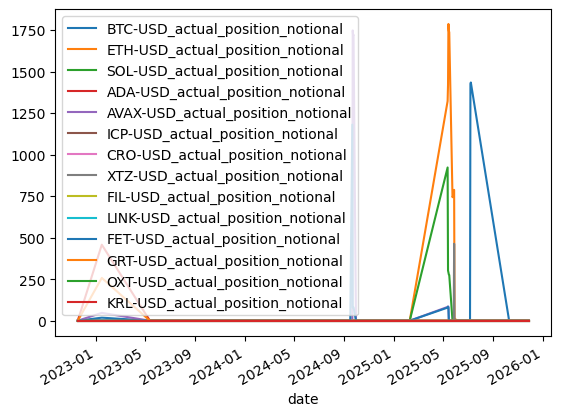

In [145]:
position_cols = [f'{ticker}_actual_position_notional' for ticker in ticker_list]
df_expanded_universe[df_expanded_universe['final_scaling_factor'] > 20000][position_cols].plot()

<Axes: title={'center': 'Scaling Factors for Original Position Sizing Strategy'}, xlabel='date'>

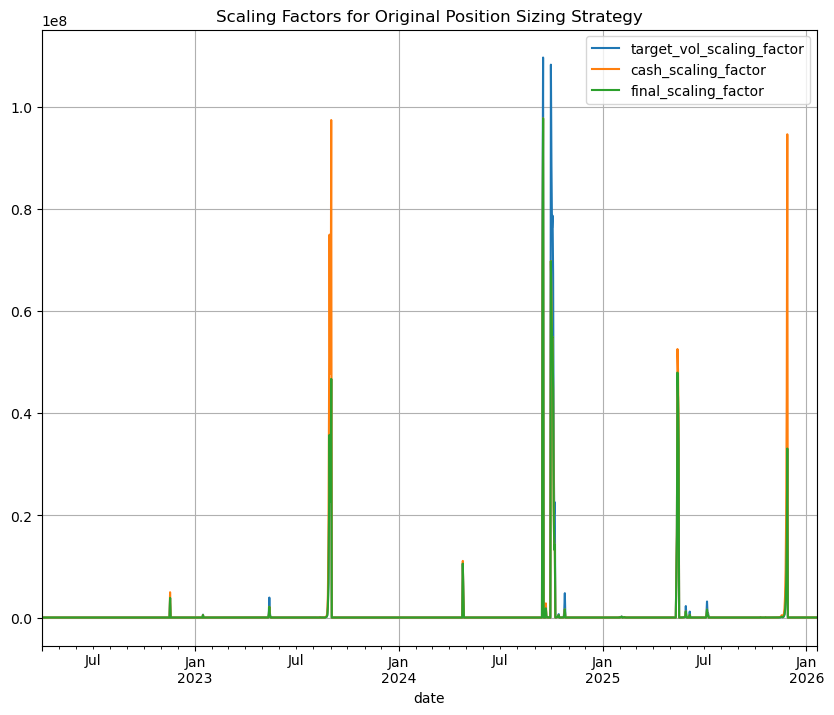

In [139]:
df_expanded_universe[['target_vol_scaling_factor','cash_scaling_factor','final_scaling_factor']].plot(figsize=(10,8), grid=True, title='Scaling Factors for Original Position Sizing Strategy')

<Axes: title={'center': 'Scaling Factors for Revised Position Sizing Strategy'}, xlabel='date'>

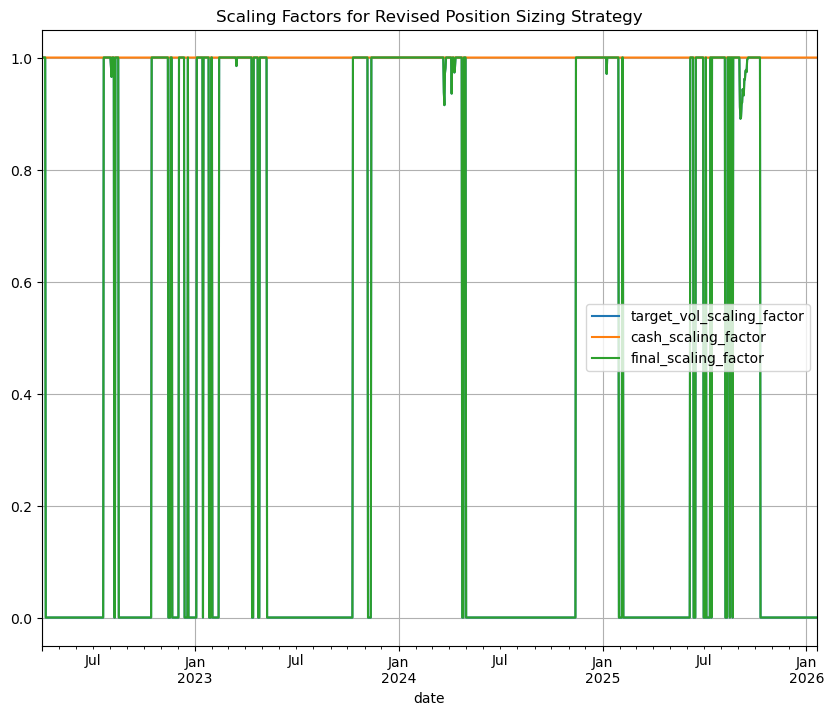

In [141]:
df_expanded_universe_scale_mod_1[['target_vol_scaling_factor','cash_scaling_factor','final_scaling_factor']].plot(figsize=(10,8), grid=True, title='Scaling Factors for Revised Position Sizing Strategy')

## Adding Logic to Only Scale Down and No Scaling Up for Cash or Volatility

In [153]:
importlib.reload(tf_exp)

<module 'strategy_signal.trend_following_expanded_universe' from '/Users/adheerchauhan/Documents/git/trend_following/strategy_signal/trend_following_expanded_universe.py'>

In [155]:
df_expanded_universe_scale_mod_no_scale = tf_exp.apply_target_volatility_position_sizing_continuous_strategy_with_rolling_r_sqr_vol_of_vol_with_risk_multiplier_sleeve_weights_opt(
    start_date=start_date - pd.Timedelta(days=warmup_days),
    end_date=end_date,
    ticker_list=ticker_list,
    fast_mavg=fast_mavg,
    slow_mavg=slow_mavg,
    mavg_stepsize=mavg_stepsize,
    mavg_z_score_window=mavg_z_score_window,
    entry_rolling_donchian_window=entry_rolling_donchian_window,
    exit_rolling_donchian_window=exit_rolling_donchian_window,
    use_donchian_exit_gate=use_donchian_exit_gate,
    ma_crossover_signal_weight=ma_crossover_signal_weight,
    donchian_signal_weight=donchian_signal_weight,
    weighted_signal_ewm_window=weighted_signal_ewm_window,
    rolling_r2_window=rolling_r2_window,
    lower_r_sqr_limit=lower_r_sqr_limit,
    upper_r_sqr_limit=upper_r_sqr_limit,
    r2_smooth_window=r2_smooth_window,
    r2_confirm_days=r2_confirm_days,
    log_std_window=log_std_window,
    coef_of_variation_window=coef_of_variation_window,
    vol_of_vol_z_score_window=vol_of_vol_z_score_window,
    vol_of_vol_p_min=vol_of_vol_p_min,
    r2_strong_threshold=r2_strong_threshold,
    use_activation=use_activation,
    tanh_activation_constant_dict=tanh_activation_constant_dict,
    moving_avg_type=moving_avg_type,
    long_only=False,
    price_or_returns_calc=price_or_returns_calc,
    initial_capital=df_portfolio_positions['total_balance_fiat'].sum(),#initial_capital,
    rolling_cov_window=rolling_cov_window,
    volatility_window=volatility_window,
    rolling_atr_window=rolling_atr_window,
    atr_multiplier=atr_multiplier,
    transaction_cost_est=transaction_cost_est,
    passive_trade_rate=passive_trade_rate,
    notional_threshold_pct=notional_threshold_pct,
    cooldown_counter_threshold=cooldown_counter_threshold,
    use_coinbase_data=use_coinbase_data,
    use_saved_files=False,
    saved_file_end_date=None,
    rolling_sharpe_window=rolling_sharpe_window,
    cash_buffer_percentage=cash_buffer_percentage,
    annualized_target_volatility=annualized_target_volatility,
    annual_trading_days=annual_trading_days,
    use_specific_start_date=True,
    signal_start_date=start_date,
    sleeve_budgets=sleeve_budgets,
    risk_max_iterations=risk_max_iterations,
    risk_sleeve_budget_tolerance=risk_sleeve_budget_tolerance,
    risk_optimizer_step=risk_optimizer_step,
    risk_min_signal=risk_min_signal,
    sleeve_risk_mode=sleeve_risk_mode,
)

Generating Moving Average Ribbon Signal!!
Generating Volatility Adjusted Trend Signal!!
Getting Average True Range for Stop Loss Calculation!!
BTC-USD
ETH-USD
SOL-USD
ADA-USD
AVAX-USD
ICP-USD
CRO-USD
XTZ-USD
FIL-USD
LINK-USD
FET-USD
GRT-USD
OXT-USD
KRL-USD
Calculating Volatility Targeted Position Size and Cash Management!!
L1_Core
L1_Alt
AI
Calculating Portfolio Performance!!


In [157]:
# ----- 2) cut warmup -----
df_expanded_universe_scale_mod_no_scale = df_expanded_universe_scale_mod_no_scale[df_expanded_universe_scale_mod_no_scale.index >= pd.Timestamp(start_date)]

# ----- 3) add asset-level + portfolio returns -----
df_expanded_universe_scale_mod_no_scale = perf.calculate_asset_level_returns(df_expanded_universe_scale_mod_no_scale, end_date, ticker_list)

# ----- 4) portfolio-level metrics -----
port_metrics_scale_mod_no_scale = calculate_risk_and_performance_metrics(
    df_expanded_universe_scale_mod_no_scale,
    strategy_daily_return_col="portfolio_daily_pct_returns",
    strategy_trade_count_col="count_of_positions",
    include_transaction_costs_and_fees=False,
    transaction_cost_est=transaction_cost_est,
    passive_trade_rate=passive_trade_rate,
    annual_trading_days=annual_trading_days,
)
port_metrics_scale_mod_no_scale.update({
    "w_core": sleeve_budgets['L1_Core']['weight'],
    "w_alt":  sleeve_budgets['L1_Alt']['weight'],
    "w_ai":   sleeve_budgets['AI']['weight'],
})

# ----- 5) sleeve-level metrics -----
sleeves_to_tickers = {}
for k, v in sleeve_budgets.items():
    sleeves_to_tickers[k] = v['tickers']

target_risk_budget = {
    "L1_Core": float(np.round(sleeve_budgets['L1_Core']['weight'], 2)),
    "L1_Alt":  float(np.round(sleeve_budgets['L1_Alt']['weight'], 2)),
    "AI":      float(np.round(sleeve_budgets['AI']['weight'], 2)),
}
df_sleeves_scale_mod_no_scale = tf_exp.add_sleeve_series(
    df_expanded_universe_scale_mod_no_scale,
    sleeves=sleeves_to_tickers,
    target_risk_budget=target_risk_budget,
    budget_band=0.20,
    strategy_trade_count_col="count_of_positions",
)

sleeve_metrics_scale_mod_no_scale = tf_exp.summarize_sleeves_with_user_metrics(
    df_sleeves_scale_mod_no_scale,
    sleeves=sleeves_to_tickers,
    target_risk_budget=target_risk_budget,
    include_transaction_costs_and_fees=False,
    transaction_cost_est=transaction_cost_est,
    passive_trade_rate=passive_trade_rate,
    annual_rf=0.05,
    annual_trading_days=annual_trading_days,
)

# tag the run weights on the sleeve table too
sleeve_metrics_scale_mod_no_scale["w_core"] = sleeve_budgets['L1_Core']['weight']
sleeve_metrics_scale_mod_no_scale["w_alt"]  = sleeve_budgets['L1_Alt']['weight']
sleeve_metrics_scale_mod_no_scale["w_ai"]   = sleeve_budgets['AI']['weight']

In [159]:
port_metrics_scale_mod_no_scale

{'annualized_return': 0.03595849642705562,
 'annualized_sharpe_ratio': -0.12863779023144187,
 'calmar_ratio': 0.2064322231961757,
 'annualized_std_dev': 0.2186784533069356,
 'max_drawdown': -0.17419032683130922,
 'max_drawdown_duration': Timedelta('686 days 00:00:00'),
 'hit_rate': 0.08339324227174695,
 't_statistic': 0.9397053169012326,
 'p_value': 0.3475320017668969,
 'trade_count': 113.0,
 'w_core': 0.5,
 'w_alt': 0.15,
 'w_ai': 0.35}

In [161]:
sleeve_metrics_scale_mod_no_scale

,annualized_return,annualized_sharpe_ratio,calmar_ratio,annualized_std_dev,max_drawdown,max_drawdown_duration,hit_rate,t_statistic,p_value,trade_count,mean_risk_share,p5_risk_share,p95_risk_share,target_risk_share,mean_risk_share_diff,pct_days_in_band,w_core,w_alt,w_ai
sleeve,,,,,,,,,,,,,,,,,,,
L1_Core,0.008466,-1.021134,0.060340,0.100965,-0.140300,680 days,0.075485,0.462110,0.644075,206,0.152631,0.0,1.0,0.50,-0.347369,0.007189,0.5,0.15,0.35
L1_Alt,0.009238,-2.780301,2.091211,0.138160,-0.004418,685 days,0.004313,1.277304,0.201708,14,0.002095,0.0,0.0,0.15,-0.147905,0.006470,0.5,0.15,0.35
AI,-0.003714,-1.893653,-0.071106,0.190438,-0.052237,687 days,0.010065,-0.237061,0.812645,30,0.011341,0.0,0.0,0.35,-0.338659,0.006470,0.5,0.15,0.35


<Axes: title={'center': 'BTC-USD Original Signals'}, xlabel='date'>

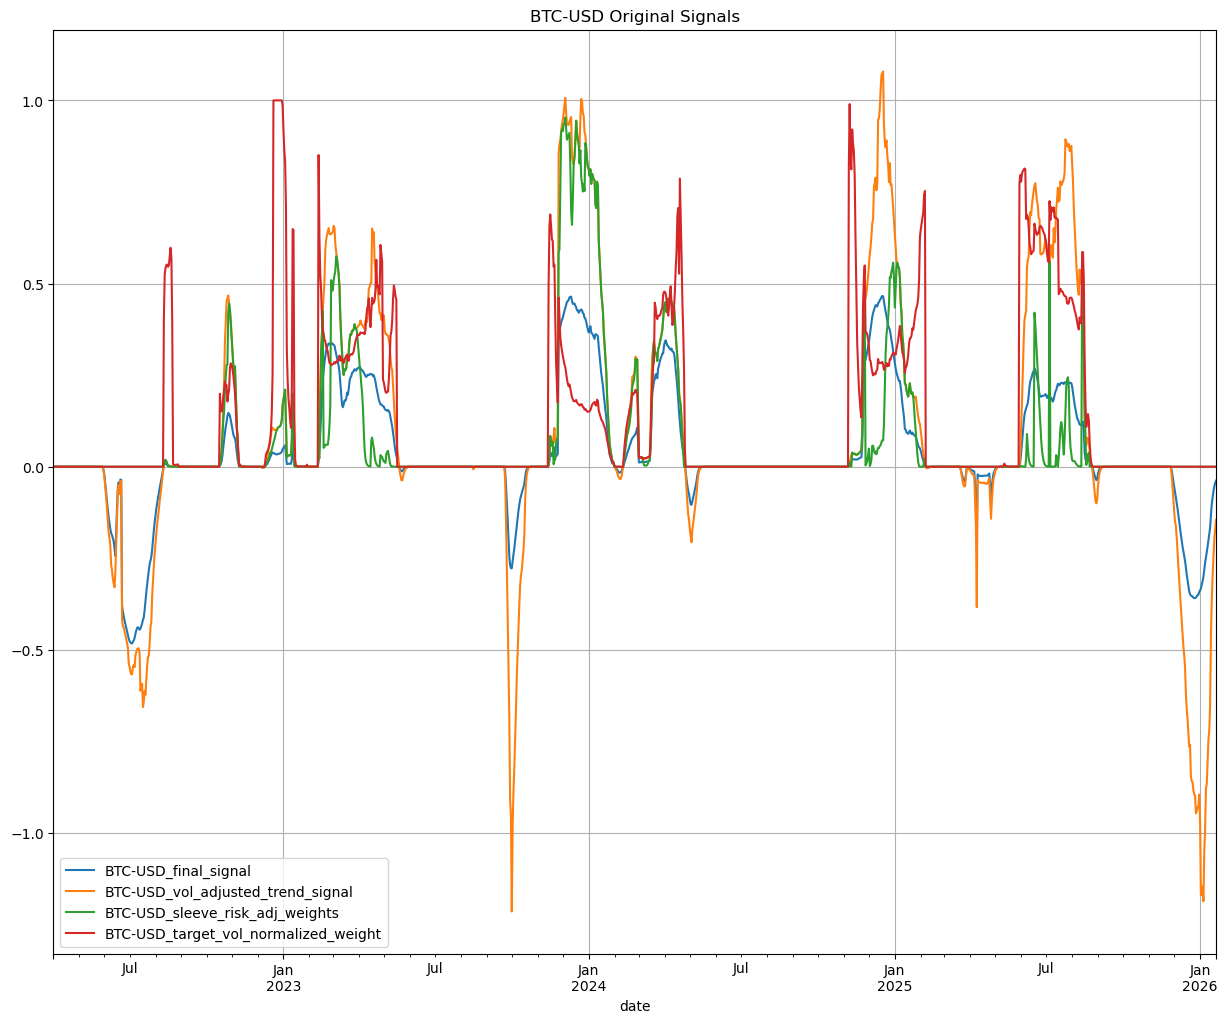

In [167]:
weight_cols = [f'BTC-USD_final_signal',f'BTC-USD_vol_adjusted_trend_signal',f'BTC-USD_sleeve_risk_adj_weights',f'BTC-USD_target_vol_normalized_weight']
df_expanded_universe[weight_cols].plot(figsize=(15,12), grid=True, title='BTC-USD Original Signals')#.head(20)

<Axes: title={'center': 'BTC-USD Revised Signals'}, xlabel='date'>

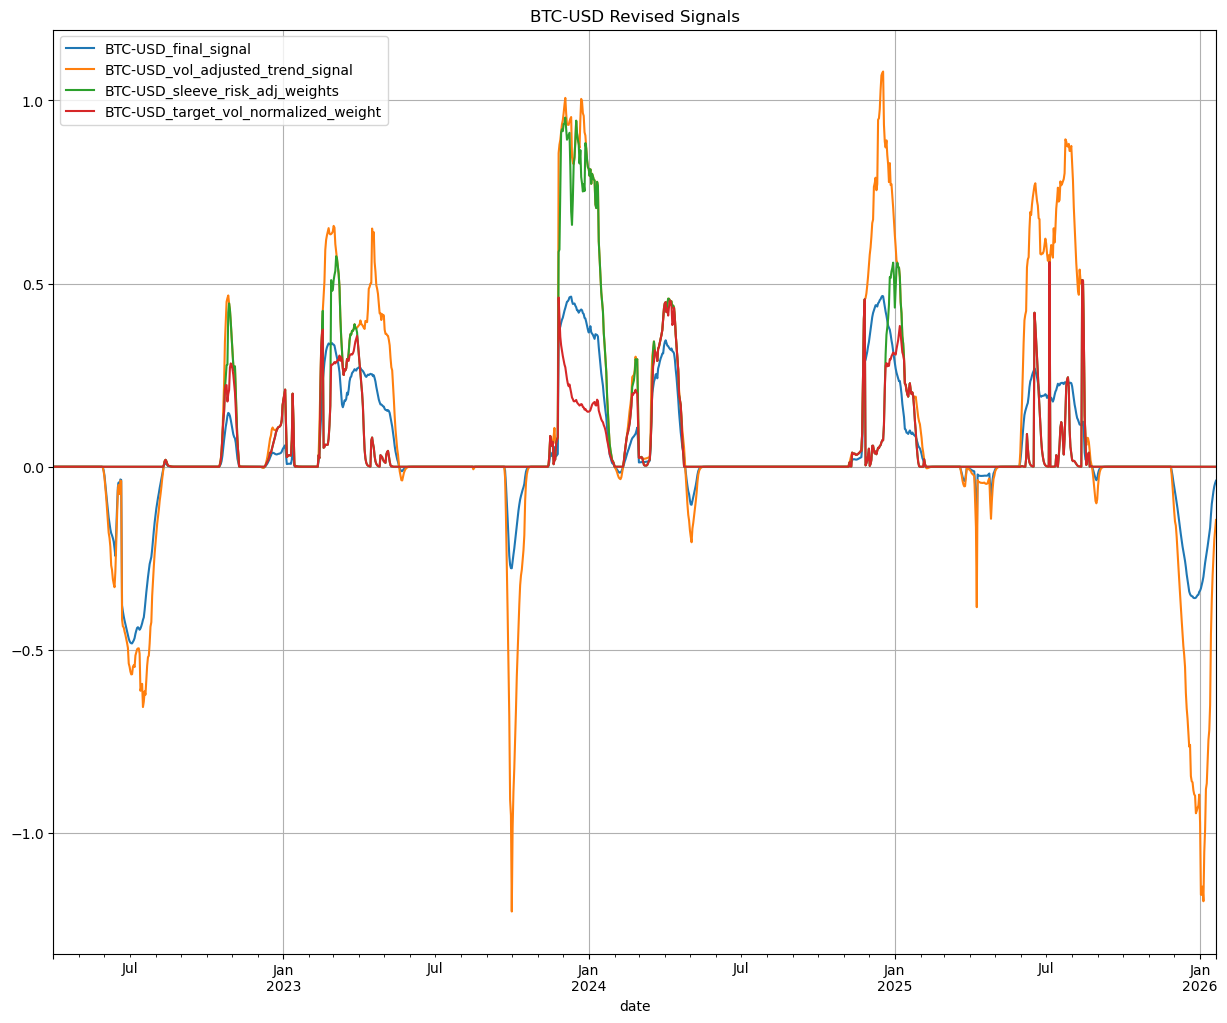

In [169]:
weight_cols = [f'BTC-USD_final_signal',f'BTC-USD_vol_adjusted_trend_signal',f'BTC-USD_sleeve_risk_adj_weights',f'BTC-USD_target_vol_normalized_weight']
df_expanded_universe_scale_mod_no_scale[weight_cols].plot(figsize=(15,12), grid=True, title='BTC-USD Revised Signals')#.head(20)

<Axes: title={'center': 'ETH-USD Original Signals'}, xlabel='date'>

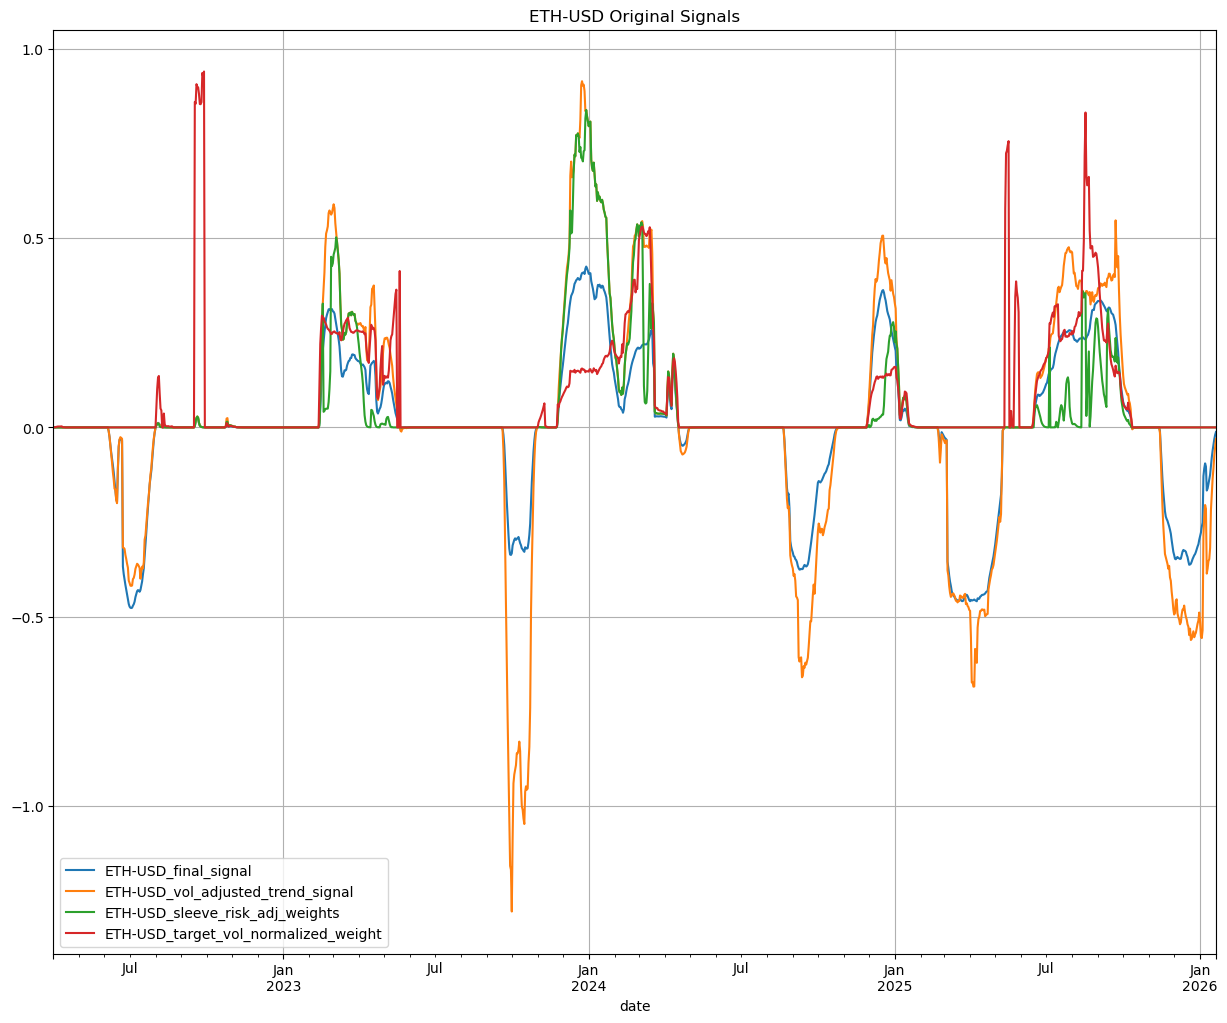

In [171]:
ticker = 'ETH-USD'
weight_cols = [f'{ticker}_final_signal',f'{ticker}_vol_adjusted_trend_signal',f'{ticker}_sleeve_risk_adj_weights',f'{ticker}_target_vol_normalized_weight']
df_expanded_universe[weight_cols].plot(figsize=(15,12), grid=True, title=f'{ticker} Original Signals')#.head(20)

<Axes: title={'center': 'ETH-USD Original Signals'}, xlabel='date'>

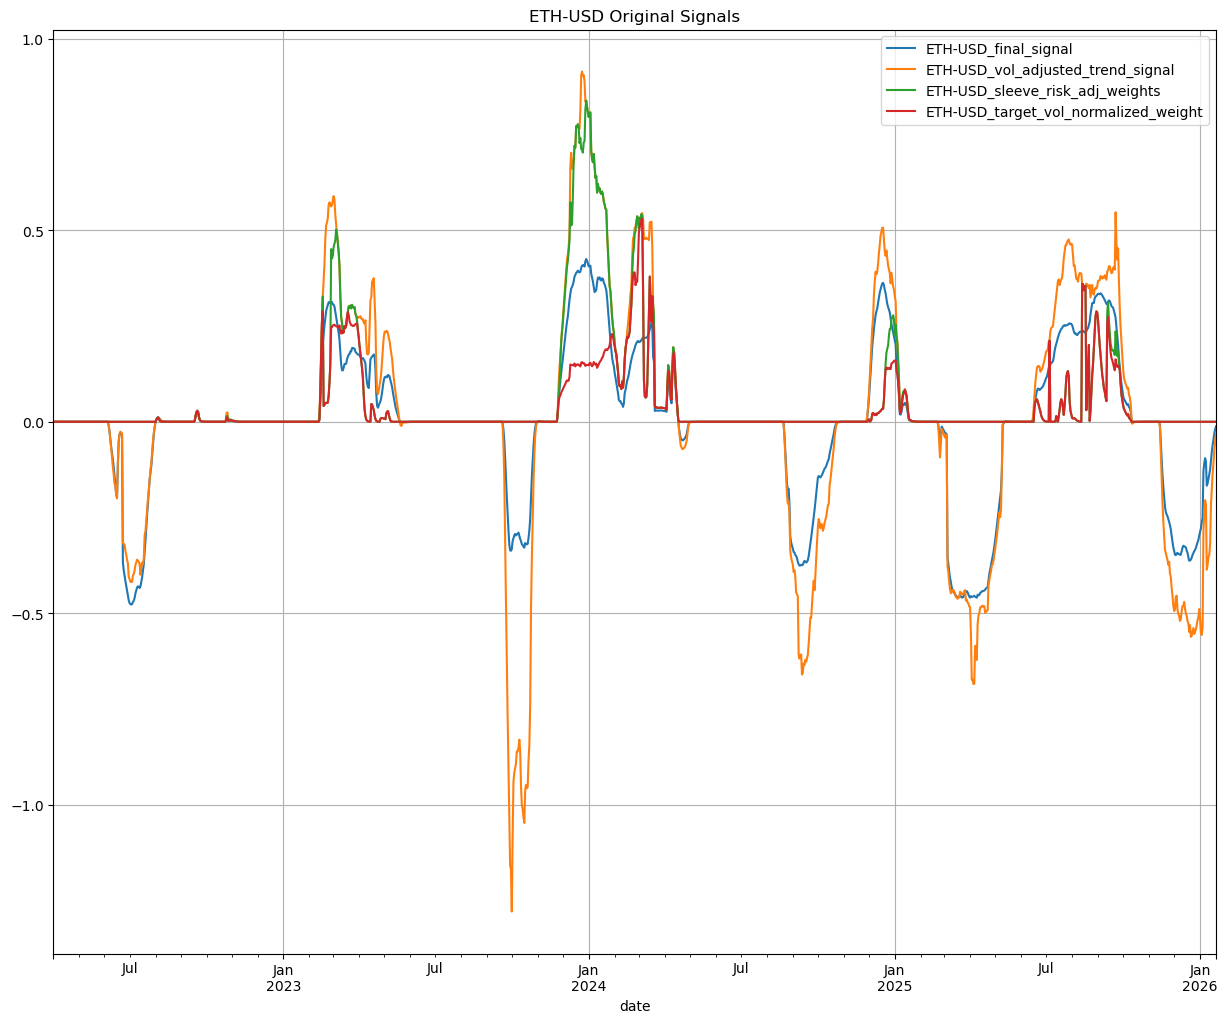

In [173]:
ticker = 'ETH-USD'
weight_cols = [f'{ticker}_final_signal',f'{ticker}_vol_adjusted_trend_signal',f'{ticker}_sleeve_risk_adj_weights',f'{ticker}_target_vol_normalized_weight']
df_expanded_universe_scale_mod_no_scale[weight_cols].plot(figsize=(15,12), grid=True, title=f'{ticker} Original Signals')#.head(20)

<Axes: title={'center': 'Total Portfolio Value Original'}, xlabel='date'>

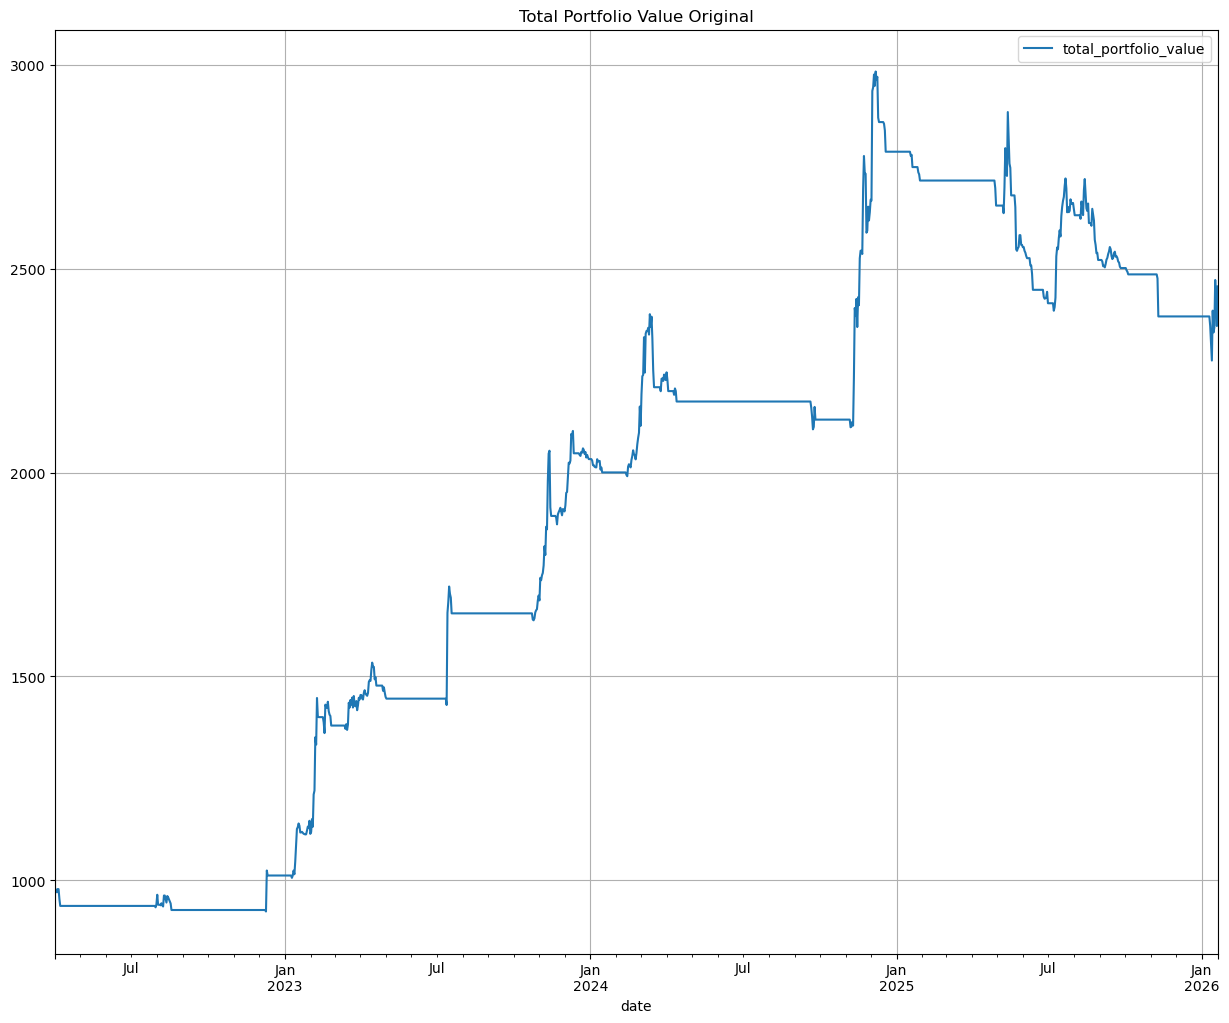

In [177]:
ticker = 'ETH-USD'
cols = [f'total_portfolio_value']
df_expanded_universe[cols].plot(figsize=(15,12), grid=True, title=f'Total Portfolio Value Original')#.head(20)

<Axes: title={'center': 'Total Portfolio Value Revised Signals'}, xlabel='date'>

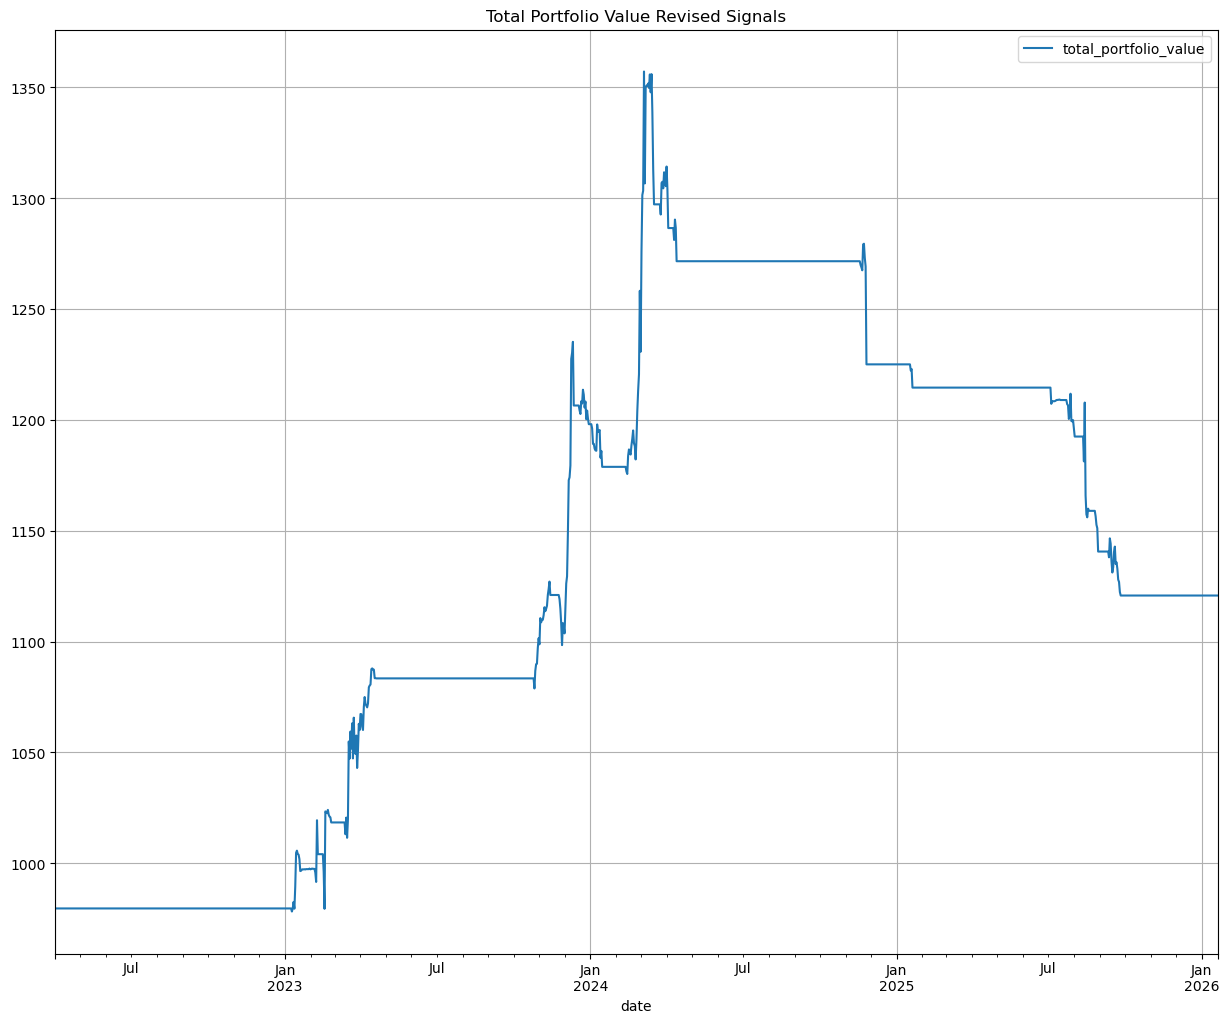

In [181]:
ticker = 'ETH-USD'
cols = [f'total_portfolio_value']
df_expanded_universe_scale_mod_no_scale[cols].plot(figsize=(15,12), grid=True, title=f'Total Portfolio Value Revised Signals')#.head(20)

## Adding Conviction Logic to the Target Volatility Position Sizing

In [83]:
importlib.reload(tf_exp)

<module 'strategy_signal.trend_following_expanded_universe' from '/Users/adheerchauhan/Documents/git/trend_following/strategy_signal/trend_following_expanded_universe.py'>

In [85]:
conv_n0=1.5  # breadth scalar = 0 when N_eff <= n0
conv_n1=4.0  # breadth scalar = 1 when N_eff >= n1
conv_s0=0.005  # strength scalar = 0 when gross_raw <= s0  (TUNE)
conv_s1=0.065  # strength scalar = 1 when gross_raw >= s1  (TUNE)
conv_G_min=0.0  # minimum gross exposure
conv_G_max=1.0  # maximum gross exposure (long-only, no leverage)
conv_single_name_gross_cap=1.0  # if N_eff < 2, cap gross exposure at this
conv_enable=True  # set False to disable conviction logic

In [87]:
df_expanded_universe_scale_mod_1 = tf_exp.apply_target_volatility_position_sizing_continuous_strategy_with_rolling_r_sqr_vol_of_vol_with_risk_multiplier_sleeve_weights_opt(
    start_date=start_date - pd.Timedelta(days=warmup_days),
    end_date=end_date,
    ticker_list=ticker_list,
    fast_mavg=fast_mavg,
    slow_mavg=slow_mavg,
    mavg_stepsize=mavg_stepsize,
    mavg_z_score_window=mavg_z_score_window,
    entry_rolling_donchian_window=entry_rolling_donchian_window,
    exit_rolling_donchian_window=exit_rolling_donchian_window,
    use_donchian_exit_gate=use_donchian_exit_gate,
    ma_crossover_signal_weight=ma_crossover_signal_weight,
    donchian_signal_weight=donchian_signal_weight,
    weighted_signal_ewm_window=weighted_signal_ewm_window,
    rolling_r2_window=rolling_r2_window,
    lower_r_sqr_limit=lower_r_sqr_limit,
    upper_r_sqr_limit=upper_r_sqr_limit,
    r2_smooth_window=r2_smooth_window,
    r2_confirm_days=r2_confirm_days,
    log_std_window=log_std_window,
    coef_of_variation_window=coef_of_variation_window,
    vol_of_vol_z_score_window=vol_of_vol_z_score_window,
    vol_of_vol_p_min=vol_of_vol_p_min,
    r2_strong_threshold=r2_strong_threshold,
    use_activation=use_activation,
    tanh_activation_constant_dict=tanh_activation_constant_dict,
    moving_avg_type=moving_avg_type,
    long_only=False,
    price_or_returns_calc=price_or_returns_calc,
    initial_capital=df_portfolio_positions['total_balance_fiat'].sum(),#initial_capital,
    rolling_cov_window=rolling_cov_window,
    volatility_window=volatility_window,
    rolling_atr_window=rolling_atr_window,
    atr_multiplier=atr_multiplier,
    transaction_cost_est=transaction_cost_est,
    passive_trade_rate=passive_trade_rate,
    notional_threshold_pct=notional_threshold_pct,
    cooldown_counter_threshold=cooldown_counter_threshold,
    use_coinbase_data=use_coinbase_data,
    use_saved_files=False,
    saved_file_end_date=None,
    rolling_sharpe_window=rolling_sharpe_window,
    cash_buffer_percentage=cash_buffer_percentage,
    annualized_target_volatility=annualized_target_volatility,
    annual_trading_days=annual_trading_days,
    use_specific_start_date=True,
    signal_start_date=start_date,
    sleeve_budgets=sleeve_budgets,
    risk_max_iterations=risk_max_iterations,
    risk_sleeve_budget_tolerance=risk_sleeve_budget_tolerance,
    risk_optimizer_step=risk_optimizer_step,
    risk_min_signal=risk_min_signal,
    sleeve_risk_mode=sleeve_risk_mode,
    conv_n0=conv_n0,  # breadth scalar = 0 when N_eff <= n0
    conv_n1=conv_n1,  # breadth scalar = 1 when N_eff >= n1
    conv_s0=conv_s0,  # strength scalar = 0 when gross_raw <= s0  (TUNE)
    conv_s1=conv_s1,  # strength scalar = 1 when gross_raw >= s1  (TUNE)
    conv_G_min=conv_G_min,  # minimum gross exposure
    conv_G_max=conv_G_max,  # maximum gross exposure (long-only, no leverage)
    conv_single_name_gross_cap=conv_single_name_gross_cap,  # if N_eff < 2, cap gross exposure at this
    conv_enable=conv_enable  # set False to disable conviction logic
)

Generating Moving Average Ribbon Signal!!
Generating Volatility Adjusted Trend Signal!!
Getting Average True Range for Stop Loss Calculation!!
BTC-USD
ETH-USD
SOL-USD
ADA-USD
AVAX-USD
ICP-USD
CRO-USD
XTZ-USD
FIL-USD
LINK-USD
FET-USD
GRT-USD
OXT-USD
KRL-USD
Calculating Volatility Targeted Position Size and Cash Management!!
L1_Core
L1_Alt
AI
Calculating Portfolio Performance!!


In [88]:
# ----- 2) cut warmup -----
df_expanded_universe_scale_mod_1 = df_expanded_universe_scale_mod_1[df_expanded_universe_scale_mod_1.index >= pd.Timestamp(start_date)]

# ----- 3) add asset-level + portfolio returns -----
df_expanded_universe_scale_mod_1 = perf.calculate_asset_level_returns(df_expanded_universe_scale_mod_1, end_date, ticker_list)

# ----- 4) portfolio-level metrics -----
port_metrics_scale_mod_1 = calculate_risk_and_performance_metrics(
    df_expanded_universe_scale_mod_1,
    strategy_daily_return_col="portfolio_daily_pct_returns",
    strategy_trade_count_col="count_of_positions",
    include_transaction_costs_and_fees=False,
    transaction_cost_est=transaction_cost_est,
    passive_trade_rate=passive_trade_rate,
    annual_trading_days=annual_trading_days,
)
port_metrics_scale_mod_1.update({
    "w_core": sleeve_budgets['L1_Core']['weight'],
    "w_alt":  sleeve_budgets['L1_Alt']['weight'],
    "w_ai":   sleeve_budgets['AI']['weight'],
})

# ----- 5) sleeve-level metrics -----
sleeves_to_tickers = {}
for k, v in sleeve_budgets.items():
    sleeves_to_tickers[k] = v['tickers']

target_risk_budget = {
    "L1_Core": float(np.round(sleeve_budgets['L1_Core']['weight'], 2)),
    "L1_Alt":  float(np.round(sleeve_budgets['L1_Alt']['weight'], 2)),
    "AI":      float(np.round(sleeve_budgets['AI']['weight'], 2)),
}
df_sleeves_scale_mod_1 = tf_exp.add_sleeve_series(
    df_expanded_universe_scale_mod_1,
    sleeves=sleeves_to_tickers,
    target_risk_budget=target_risk_budget,
    budget_band=0.20,
    strategy_trade_count_col="count_of_positions",
)

sleeve_metrics_scale_mod_1 = tf_exp.summarize_sleeves_with_user_metrics(
    df_sleeves_scale_mod_1,
    sleeves=sleeves_to_tickers,
    target_risk_budget=target_risk_budget,
    include_transaction_costs_and_fees=False,
    transaction_cost_est=transaction_cost_est,
    passive_trade_rate=passive_trade_rate,
    annual_rf=0.05,
    annual_trading_days=annual_trading_days,
)

# tag the run weights on the sleeve table too
sleeve_metrics_scale_mod_1["w_core"] = sleeve_budgets['L1_Core']['weight']
sleeve_metrics_scale_mod_1["w_alt"]  = sleeve_budgets['L1_Alt']['weight']
sleeve_metrics_scale_mod_1["w_ai"]   = sleeve_budgets['AI']['weight']

In [89]:
## First Run
port_metrics_scale_mod_1

{'annualized_return': 0.019184917029159143,
 'annualized_sharpe_ratio': -0.3536557203285458,
 'calmar_ratio': 0.09955601636635648,
 'annualized_std_dev': 0.15713813733038626,
 'max_drawdown': -0.19270474783322497,
 'max_drawdown_duration': Timedelta('679 days 00:00:00'),
 'hit_rate': 0.0884255930984903,
 't_statistic': 0.5613865566854375,
 'p_value': 0.5746245400514784,
 'trade_count': 151.0,
 'w_core': 0.5,
 'w_alt': 0.15,
 'w_ai': 0.35}

In [74]:
## First Run
port_metrics_scale_mod_1

{'annualized_return': 0.1081950965918097,
 'annualized_sharpe_ratio': 0.5673810286301594,
 'calmar_ratio': 0.9599320798461737,
 'annualized_std_dev': 0.25419800669971354,
 'max_drawdown': -0.1127111999519254,
 'max_drawdown_duration': Timedelta('409 days 00:00:00'),
 'hit_rate': 0.10999281092739037,
 't_statistic': 2.018223097537975,
 'p_value': 0.04375980616386398,
 'trade_count': 185.0,
 'w_core': 0.5,
 'w_alt': 0.15,
 'w_ai': 0.35}

In [93]:
sleeve_metrics_scale_mod_1

,annualized_return,annualized_sharpe_ratio,calmar_ratio,annualized_std_dev,max_drawdown,max_drawdown_duration,hit_rate,t_statistic,p_value,trade_count,mean_risk_share,p5_risk_share,p95_risk_share,target_risk_share,mean_risk_share_diff,pct_days_in_band,w_core,w_alt,w_ai
sleeve,,,,,,,,,,,,,,,,,,,
L1_Core,0.007650,-0.950592,0.059746,0.108972,-0.128039,680 days,0.076923,0.392448,0.694787,211,0.160027,0.0,1.0,0.50,-0.339973,0.007189,0.5,0.15,0.35
L1_Alt,-0.002177,-2.777462,-0.063943,0.156280,-0.034049,1269 days,0.008627,-0.214789,0.829963,20,0.005077,0.0,0.0,0.15,-0.144923,0.000000,0.5,0.15,0.35
AI,-0.011452,-2.109339,-0.139546,0.166249,-0.082063,687 days,0.013659,-0.763676,0.445190,41,0.018936,0.0,0.0,0.35,-0.331064,0.013659,0.5,0.15,0.35


In [76]:
sleeve_metrics_scale_mod_1

,annualized_return,annualized_sharpe_ratio,calmar_ratio,annualized_std_dev,max_drawdown,max_drawdown_duration,hit_rate,t_statistic,p_value,trade_count,mean_risk_share,p5_risk_share,p95_risk_share,target_risk_share,mean_risk_share_diff,pct_days_in_band,w_core,w_alt,w_ai
sleeve,,,,,,,,,,,,,,,,,,,
L1_Core,0.026161,-0.450773,0.228788,0.111836,-0.114347,680 days,0.093458,1.089480,0.276131,260,0.183157,0.0,1.000000,0.50,-0.316843,0.018692,0.5,0.15,0.35
L1_Alt,0.000744,-2.328605,0.017189,0.122636,-0.043297,1269 days,0.015816,0.090710,0.927736,40,0.009228,0.0,0.000000,0.15,-0.140772,0.003595,0.5,0.15,0.35
AI,0.021588,-0.507839,0.383353,0.229872,-0.056314,414 days,0.024443,0.859109,0.390428,70,0.029039,0.0,0.220794,0.35,-0.320961,0.017254,0.5,0.15,0.35


## Conviction Parameter Grid Backtest

In [95]:
df_expanded_universe_scale_mod_1.head()

,BTC-USD_20_avg_true_range_price,BTC-USD_actual_position_notional,BTC-USD_actual_position_size,BTC-USD_annualized_volatility_30,BTC-USD_close,BTC-USD_cooldown_counter,BTC-USD_event,BTC-USD_final_signal,BTC-USD_final_weighted_additive_signal,BTC-USD_highest_high_56,BTC-USD_lowest_low_56,BTC-USD_new_position_entry_exit_price,BTC-USD_new_position_notional,BTC-USD_new_position_size,BTC-USD_open,BTC-USD_open_position_notional,BTC-USD_open_position_size,BTC-USD_short_sale_proceeds,BTC-USD_sleeve_risk_adj_weights,BTC-USD_sleeve_risk_multiplier,BTC-USD_stop_loss,BTC-USD_stopout_flag,BTC-USD_t_1_close,BTC-USD_t_1_close_pct_returns,BTC-USD_target_notional,BTC-USD_target_size,BTC-USD_target_vol_normalized_weight,BTC-USD_vol_adjusted_trend_signal,ETH-USD_20_avg_true_range_price,ETH-USD_actual_position_notional,ETH-USD_actual_position_size,ETH-USD_annualized_volatility_30,ETH-USD_close,ETH-USD_cooldown_counter,ETH-USD_event,ETH-USD_final_signal,ETH-USD_final_weighted_additive_signal,ETH-USD_highest_high_56,ETH-USD_lowest_low_56,ETH-USD_new_position_entry_exit_price,ETH-USD_new_position_notional,ETH-USD_new_position_size,ETH-USD_open,ETH-USD_open_position_notional,ETH-USD_open_position_size,ETH-USD_short_sale_proceeds,ETH-USD_sleeve_risk_adj_weights,ETH-USD_sleeve_risk_multiplier,ETH-USD_stop_loss,ETH-USD_stopout_flag,ETH-USD_t_1_close,ETH-USD_t_1_close_pct_returns,ETH-USD_target_notional,ETH-USD_target_size,ETH-USD_target_vol_normalized_weight,ETH-USD_vol_adjusted_trend_signal,SOL-USD_20_avg_true_range_price,SOL-USD_actual_position_notional,SOL-USD_actual_position_size,SOL-USD_annualized_volatility_30,SOL-USD_close,SOL-USD_cooldown_counter,SOL-USD_event,SOL-USD_final_signal,SOL-USD_final_weighted_additive_signal,SOL-USD_highest_high_56,SOL-USD_lowest_low_56,SOL-USD_new_position_entry_exit_price,SOL-USD_new_position_notional,SOL-USD_new_position_size,SOL-USD_open,SOL-USD_open_position_notional,SOL-USD_open_position_size,SOL-USD_short_sale_proceeds,SOL-USD_sleeve_risk_adj_weights,SOL-USD_sleeve_risk_multiplier,SOL-USD_stop_loss,SOL-USD_stopout_flag,SOL-USD_t_1_close,SOL-USD_t_1_close_pct_returns,SOL-USD_target_notional,SOL-USD_target_size,SOL-USD_target_vol_normalized_weight,SOL-USD_vol_adjusted_trend_signal,ADA-USD_20_avg_true_range_price,ADA-USD_actual_position_notional,ADA-USD_actual_position_size,ADA-USD_annualized_volatility_30,ADA-USD_close,ADA-USD_cooldown_counter,ADA-USD_event,ADA-USD_final_signal,ADA-USD_final_weighted_additive_signal,ADA-USD_highest_high_56,ADA-USD_lowest_low_56,ADA-USD_new_position_entry_exit_price,ADA-USD_new_position_notional,ADA-USD_new_position_size,ADA-USD_open,ADA-USD_open_position_notional,ADA-USD_open_position_size,ADA-USD_short_sale_proceeds,ADA-USD_sleeve_risk_adj_weights,ADA-USD_sleeve_risk_multiplier,ADA-USD_stop_loss,ADA-USD_stopout_flag,ADA-USD_t_1_close,ADA-USD_t_1_close_pct_returns,ADA-USD_target_notional,ADA-USD_target_size,ADA-USD_target_vol_normalized_weight,ADA-USD_vol_adjusted_trend_signal,AVAX-USD_20_avg_true_range_price,AVAX-USD_actual_position_notional,AVAX-USD_actual_position_size,AVAX-USD_annualized_volatility_30,AVAX-USD_close,AVAX-USD_cooldown_counter,AVAX-USD_event,AVAX-USD_final_signal,AVAX-USD_final_weighted_additive_signal,AVAX-USD_highest_high_56,AVAX-USD_lowest_low_56,AVAX-USD_new_position_entry_exit_price,AVAX-USD_new_position_notional,AVAX-USD_new_position_size,AVAX-USD_open,AVAX-USD_open_position_notional,AVAX-USD_open_position_size,AVAX-USD_short_sale_proceeds,AVAX-USD_sleeve_risk_adj_weights,AVAX-USD_sleeve_risk_multiplier,AVAX-USD_stop_loss,AVAX-USD_stopout_flag,AVAX-USD_t_1_close,AVAX-USD_t_1_close_pct_returns,AVAX-USD_target_notional,AVAX-USD_target_size,AVAX-USD_target_vol_normalized_weight,AVAX-USD_vol_adjusted_trend_signal,ICP-USD_20_avg_true_range_price,ICP-USD_actual_position_notional,ICP-USD_actual_position_size,ICP-USD_annualized_volatility_30,ICP-USD_close,ICP-USD_cooldown_counter,ICP-USD_event,ICP-USD_final_signal,ICP-USD_final_weighted_additive_signal,ICP-USD_hig

<Axes: title={'center': 'BTC-USD Signals'}, xlabel='date'>

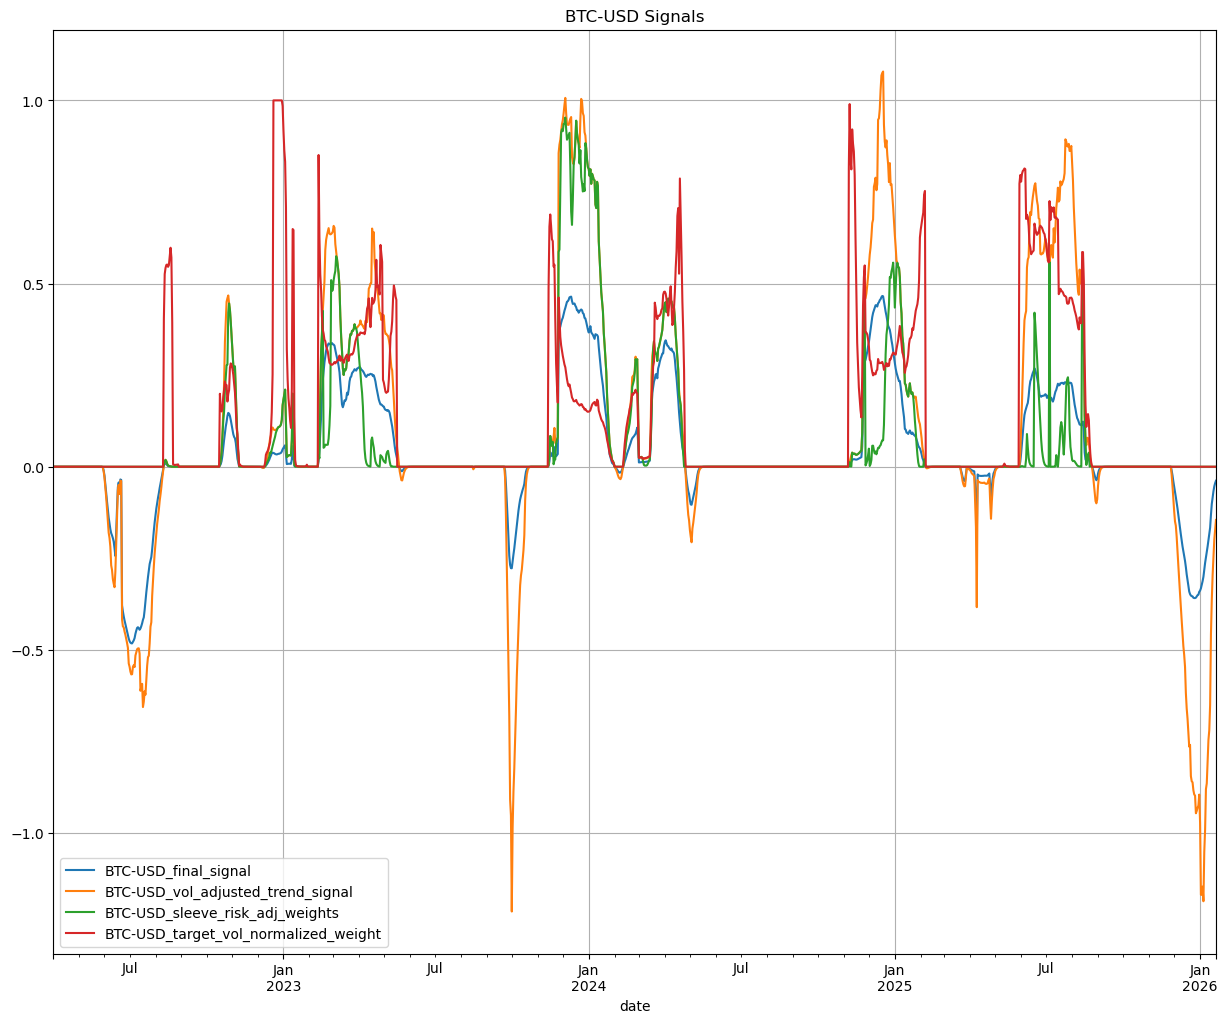

In [150]:
weight_cols = [f'BTC-USD_final_signal',f'BTC-USD_vol_adjusted_trend_signal',f'BTC-USD_sleeve_risk_adj_weights',f'BTC-USD_target_vol_normalized_weight']
df_expanded_universe[weight_cols].plot(figsize=(15,12), grid=True, title='BTC-USD Signals')#.head(20)

<Axes: title={'center': 'BTC-USD Signals'}, xlabel='date'>

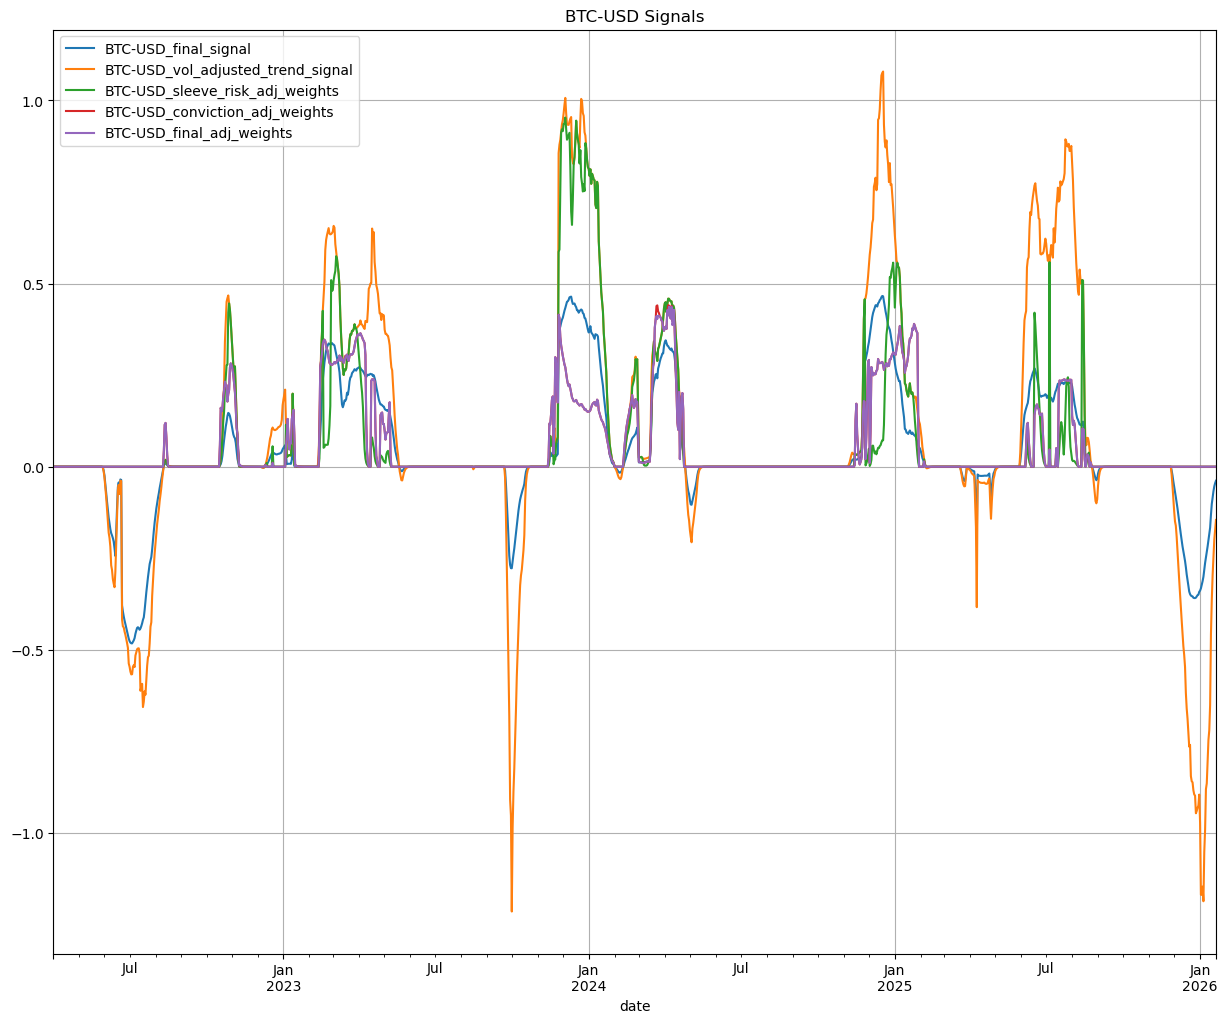

In [131]:
weight_cols = [f'BTC-USD_final_signal',f'BTC-USD_vol_adjusted_trend_signal',f'BTC-USD_sleeve_risk_adj_weights',f'BTC-USD_conviction_adj_weights',f'BTC-USD_final_adj_weights']
df_expanded_universe_scale_mod_1[weight_cols].plot(figsize=(15,12), grid=True, title='BTC-USD Signals')#.head(20)

<Axes: title={'center': 'ETH-USD Signals'}, xlabel='date'>

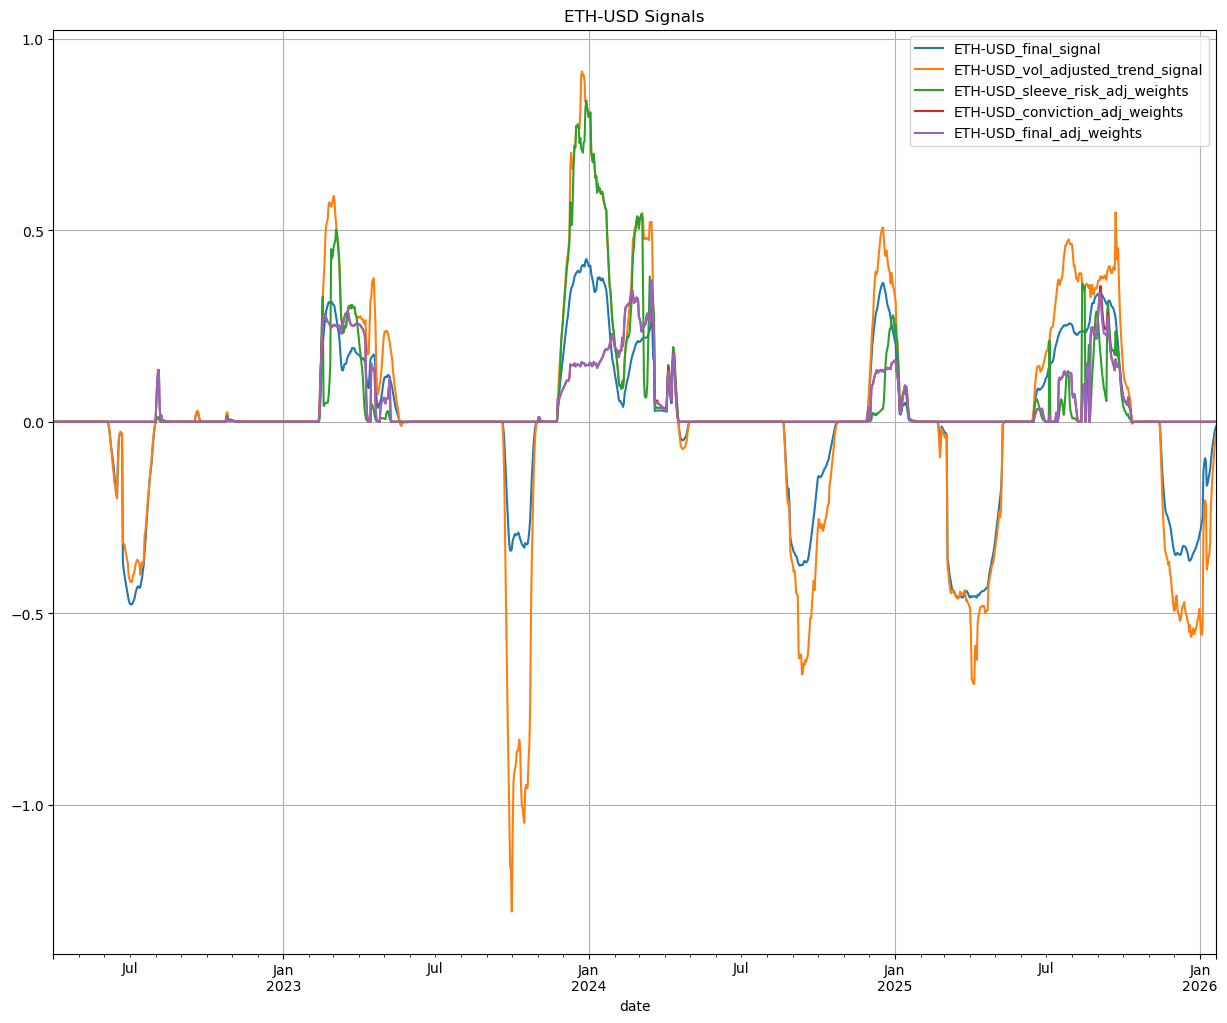

In [135]:
weight_cols = [f'ETH-USD_final_signal',f'ETH-USD_vol_adjusted_trend_signal',f'ETH-USD_sleeve_risk_adj_weights',f'ETH-USD_conviction_adj_weights',f'ETH-USD_final_adj_weights']
df_expanded_universe_scale_mod_1[weight_cols].plot(figsize=(15,12), grid=True, title='ETH-USD Signals')#.head(20)

<Axes: title={'center': 'SOL-USD Signals'}, xlabel='date'>

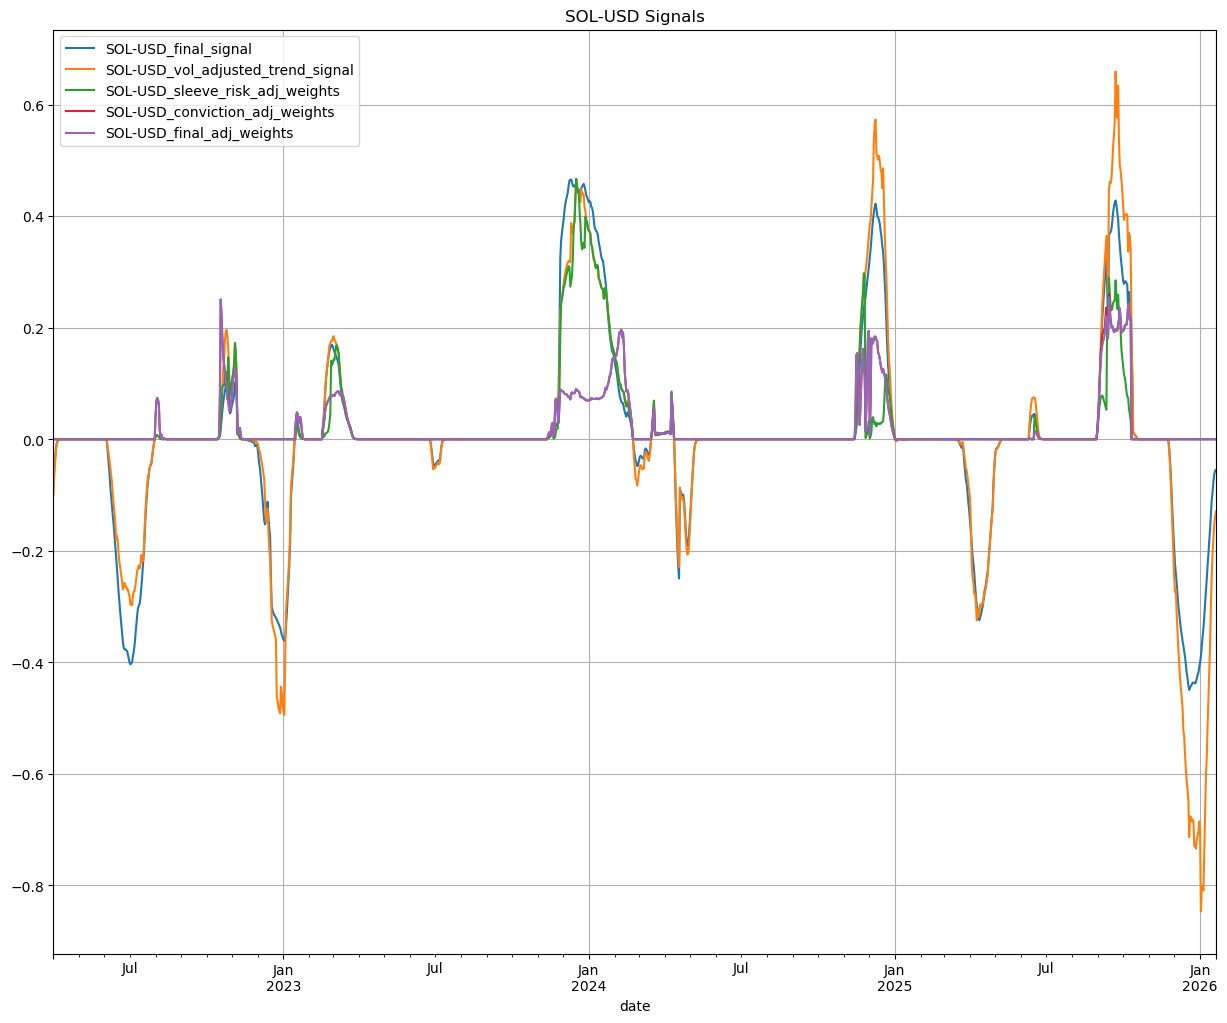

In [137]:
weight_cols = [f'SOL-USD_final_signal',f'SOL-USD_vol_adjusted_trend_signal',f'SOL-USD_sleeve_risk_adj_weights',f'SOL-USD_conviction_adj_weights',f'SOL-USD_final_adj_weights']
df_expanded_universe_scale_mod_1[weight_cols].plot(figsize=(15,12), grid=True, title='SOL-USD Signals')#.head(20)

<Axes: title={'center': 'Final Scaling Factor'}, xlabel='date'>

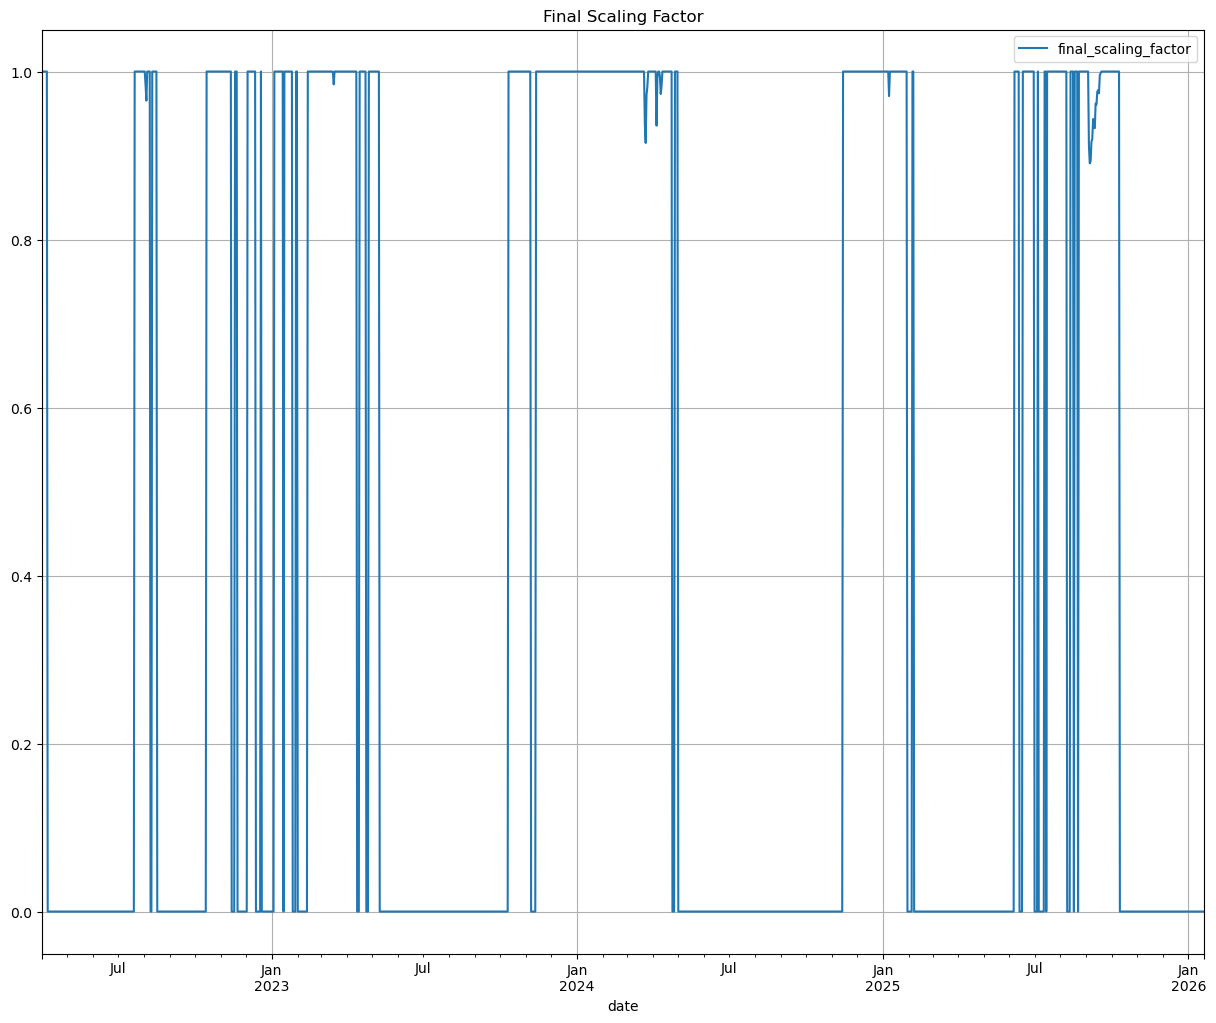

In [119]:
weight_cols = [f'final_scaling_factor']
df_expanded_universe_scale_mod_1[weight_cols].plot(figsize=(15,12), grid=True, title='Final Scaling Factor')#.head(20)

<Axes: xlabel='date'>

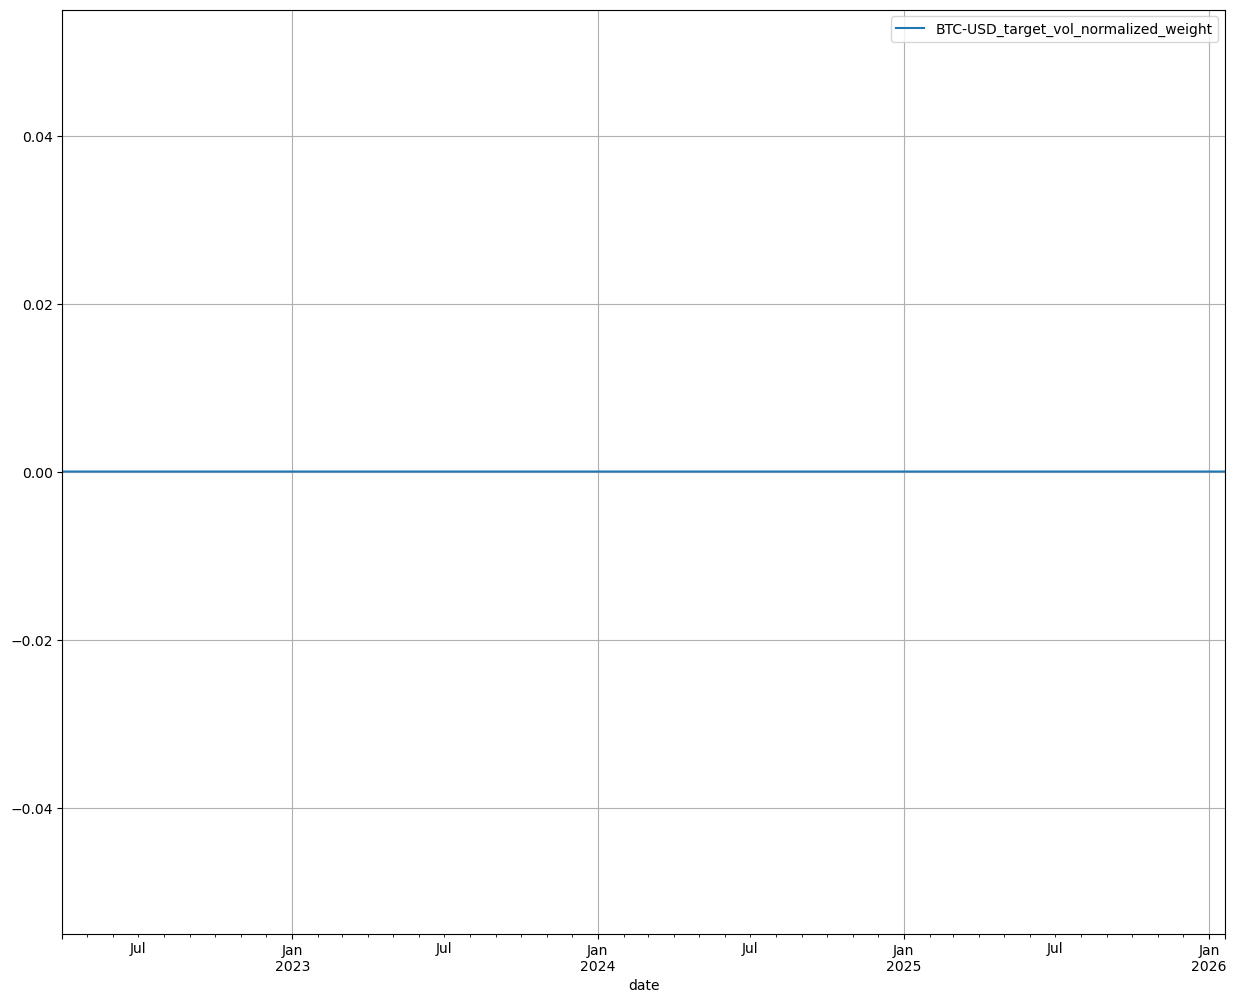

In [115]:
weight_cols = [f'BTC-USD_target_vol_normalized_weight']
df_expanded_universe_scale_mod_1[weight_cols].plot(figsize=(15,12), grid=True)#.head(20)

<Axes: xlabel='date'>

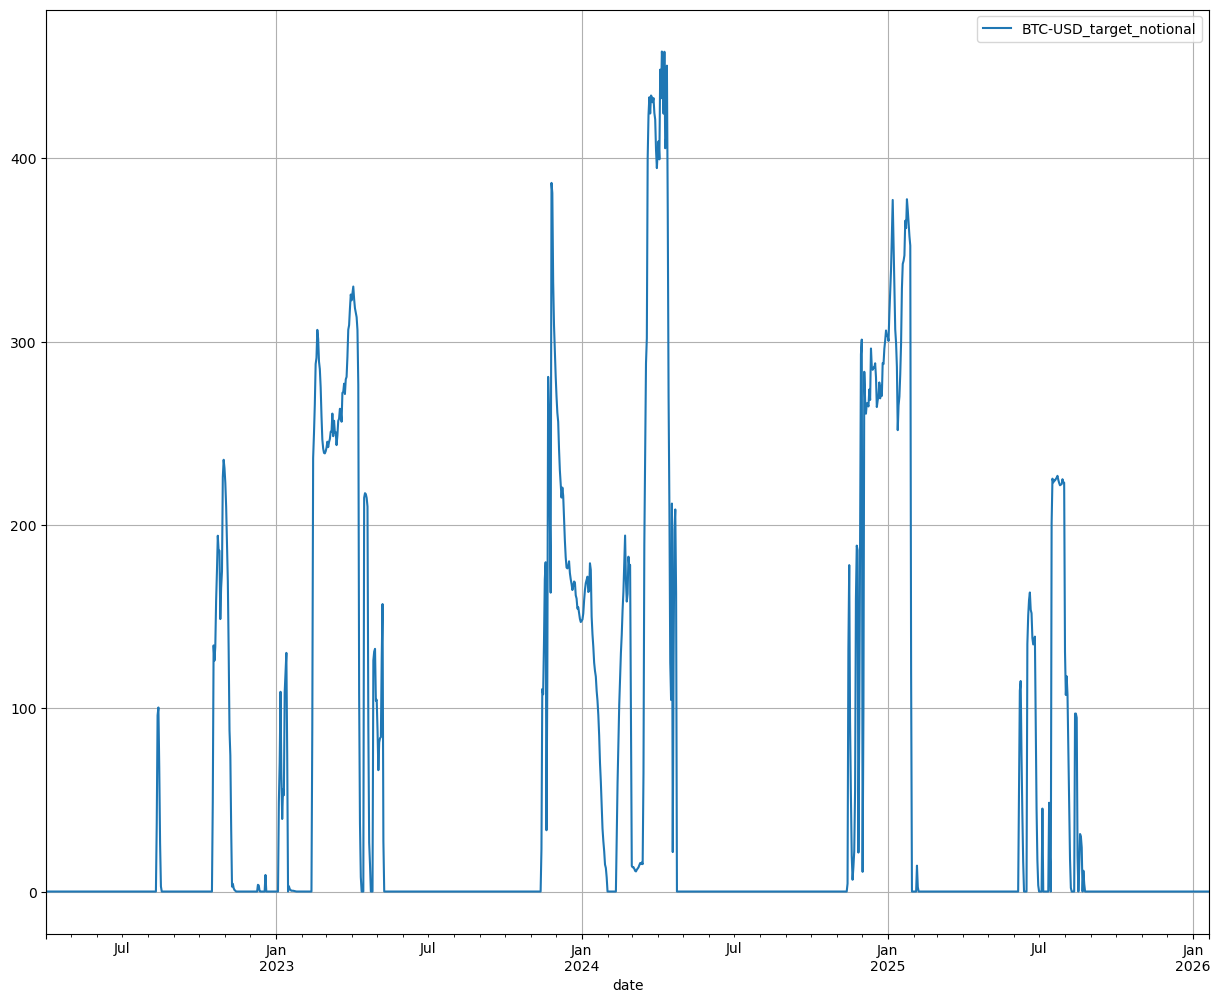

In [121]:
weight_cols = [f'BTC-USD_target_notional']
df_expanded_universe_scale_mod_1[weight_cols].plot(figsize=(15,12), grid=True)#.head(20)

<Axes: xlabel='date'>

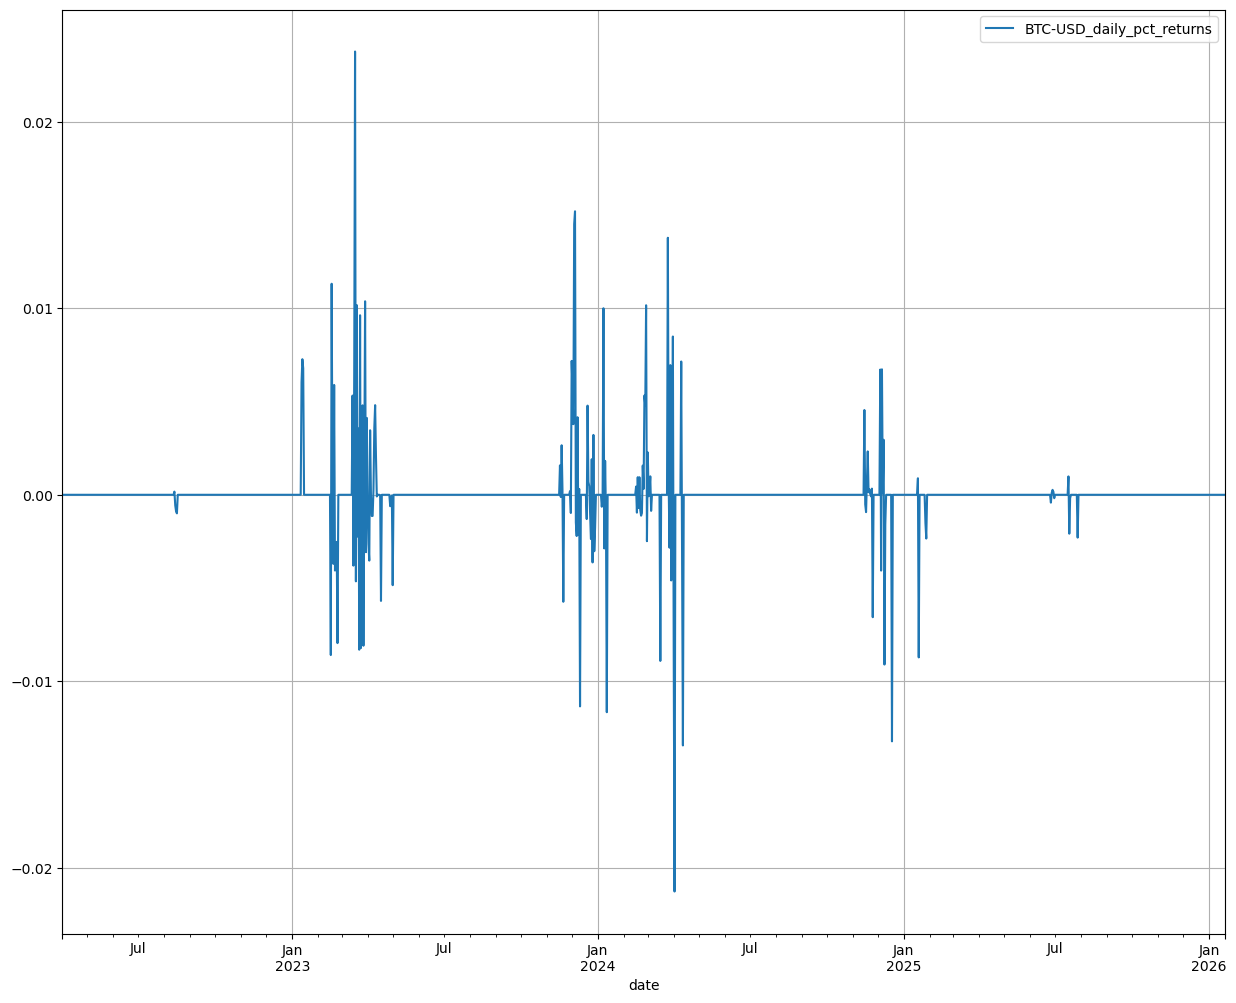

In [129]:
weight_cols = [f'BTC-USD_daily_pct_returns']
df_expanded_universe_scale_mod_1[weight_cols].plot(figsize=(15,12), grid=True)#.head(20)

In [81]:
conv_n0_list = [1.5]  # breadth scalar = 0 when N_eff <= n0
conv_n1_list = [4.0]  # breadth scalar = 1 when N_eff >= n1
conv_s0_list = [0.0001, 0.0007, 0.002, 0.005, 0.01]  # strength scalar = 0 when gross_raw <= s0  (TUNE)
conv_s1_list = [0.02, 0.065, 0.12, 0.25, 0.47]  # strength scalar = 1 when gross_raw >= s1  (TUNE)
conv_G_min_list = [0.0, 0.2, 0.35]  # minimum gross exposure
conv_G_max_list = [1.0]  # maximum gross exposure (long-only, no leverage)
conv_single_name_gross_cap_list = [0.25, 0.4, 0.6, 0.8, 1.0]  # if N_eff < 2, cap gross exposure at this
conv_enable_list = [True]  # set False to disable conviction logic

In [ ]:
import itertools
import time
import traceback
import pandas as pd
import numpy as np

# ----------------------------
# 1) Define your grid
# ----------------------------
conv_n0_list = [1.5]
conv_n1_list = [4.0]
conv_s0_list = [0.0001, 0.0007, 0.002, 0.005, 0.01]
conv_s1_list = [0.02, 0.065, 0.12, 0.25, 0.47]
conv_G_min_list = [0.0, 0.2, 0.35]
conv_G_max_list = [1.0]
conv_single_name_gross_cap_list = [0.25, 0.4, 0.6, 0.8, 1.0]
conv_enable_list = [True]

grid = list(itertools.product(
    conv_n0_list,
    conv_n1_list,
    conv_s0_list,
    conv_s1_list,
    conv_G_min_list,
    conv_G_max_list,
    conv_single_name_gross_cap_list,
    conv_enable_list
))

print(f"Total raw grid combos: {len(grid)}")

# ----------------------------
# 2) Helpers
# ----------------------------
def is_valid_combo(conv_n0, conv_n1, conv_s0, conv_s1, conv_G_min, conv_G_max, conv_single_name_gross_cap, conv_enable):
    if conv_n1 <= conv_n0:
        return False
    if conv_s1 <= conv_s0:
        return False
    if conv_G_min < 0 or conv_G_max <= 0:
        return False
    if conv_G_min > conv_G_max:
        return False
    # single-name cap should not exceed G_max in a long-only gross framework
    if conv_single_name_gross_cap > conv_G_max:
        return False
    return True

def summarize_investedness(df, ticker_list):
    """
    Useful diagnostics so you don't accidentally optimize "being in cash".
    This assumes you have '{ticker}_target_vol_normalized_weight' after sizing.
    """
    wcols = [f"{t}_target_vol_normalized_weight" for t in ticker_list if f"{t}_target_vol_normalized_weight" in df.columns]
    if not wcols:
        return {"avg_gross_exposure": np.nan, "pct_days_invested_gt_0p10": np.nan, "p95_single_name_weight": np.nan}

    gross = df[wcols].abs().sum(axis=1)
    p95_single = df[wcols].abs().max(axis=1).quantile(0.95)
    return {
        "avg_gross_exposure": float(gross.mean()),
        "pct_days_invested_gt_0p10": float((gross > 0.10).mean()),
        "p95_single_name_weight": float(p95_single),
    }

# ----------------------------
# 3) Run the grid
# ----------------------------
results_rows = []
sleeve_rows = []
fail_rows = []

# sleeves mapping needed for your sleeve metrics step
sleeves_to_tickers = {k: v["tickers"] for k, v in sleeve_budgets.items()}
target_risk_budget = {
    "L1_Core": float(np.round(sleeve_budgets['L1_Core']['weight'], 2)),
    "L1_Alt":  float(np.round(sleeve_budgets['L1_Alt']['weight'], 2)),
    "AI":      float(np.round(sleeve_budgets['AI']['weight'], 2)),
}

valid_grid = [g for g in grid if is_valid_combo(*g)]
print(f"Valid grid combos: {len(valid_grid)}")

for run_id, params in enumerate(valid_grid, 1):
    (conv_n0, conv_n1, conv_s0, conv_s1, conv_G_min, conv_G_max, conv_single_name_gross_cap, conv_enable) = params

    t0 = time.time()
    print(f"[{run_id}/{len(valid_grid)}] n0={conv_n0} n1={conv_n1} s0={conv_s0} s1={conv_s1} "
          f"Gmin={conv_G_min} cap={conv_single_name_gross_cap}")

    try:
        # ----- 1) build positions dataframe -----
        df_bt = tf_exp.apply_target_volatility_position_sizing_continuous_strategy_with_rolling_r_sqr_vol_of_vol_with_risk_multiplier_sleeve_weights_opt(
            start_date=start_date - pd.Timedelta(days=warmup_days),
            end_date=end_date,
            ticker_list=ticker_list,
            fast_mavg=fast_mavg,
            slow_mavg=slow_mavg,
            mavg_stepsize=mavg_stepsize,
            mavg_z_score_window=mavg_z_score_window,
            entry_rolling_donchian_window=entry_rolling_donchian_window,
            exit_rolling_donchian_window=exit_rolling_donchian_window,
            use_donchian_exit_gate=use_donchian_exit_gate,
            ma_crossover_signal_weight=ma_crossover_signal_weight,
            donchian_signal_weight=donchian_signal_weight,
            weighted_signal_ewm_window=weighted_signal_ewm_window,
            rolling_r2_window=rolling_r2_window,
            lower_r_sqr_limit=lower_r_sqr_limit,
            upper_r_sqr_limit=upper_r_sqr_limit,
            r2_smooth_window=r2_smooth_window,
            r2_confirm_days=r2_confirm_days,
            log_std_window=log_std_window,
            coef_of_variation_window=coef_of_variation_window,
            vol_of_vol_z_score_window=vol_of_vol_z_score_window,
            vol_of_vol_p_min=vol_of_vol_p_min,
            r2_strong_threshold=r2_strong_threshold,
            use_activation=use_activation,
            tanh_activation_constant_dict=tanh_activation_constant_dict,
            moving_avg_type=moving_avg_type,
            long_only=False,
            price_or_returns_calc=price_or_returns_calc,
            initial_capital=df_portfolio_positions['total_balance_fiat'].sum(),
            rolling_cov_window=rolling_cov_window,
            volatility_window=volatility_window,
            rolling_atr_window=rolling_atr_window,
            atr_multiplier=atr_multiplier,
            transaction_cost_est=transaction_cost_est,
            passive_trade_rate=passive_trade_rate,
            notional_threshold_pct=notional_threshold_pct,
            cooldown_counter_threshold=cooldown_counter_threshold,
            use_coinbase_data=use_coinbase_data,
            use_saved_files=False,
            saved_file_end_date=None,
            rolling_sharpe_window=rolling_sharpe_window,
            cash_buffer_percentage=cash_buffer_percentage,
            annualized_target_volatility=annualized_target_volatility,
            annual_trading_days=annual_trading_days,
            use_specific_start_date=True,
            signal_start_date=start_date,
            sleeve_budgets=sleeve_budgets,
            risk_max_iterations=risk_max_iterations,
            risk_sleeve_budget_tolerance=risk_sleeve_budget_tolerance,
            risk_optimizer_step=risk_optimizer_step,
            risk_min_signal=risk_min_signal,
            sleeve_risk_mode=sleeve_risk_mode,
            conv_n0=conv_n0,
            conv_n1=conv_n1,
            conv_s0=conv_s0,
            conv_s1=conv_s1,
            conv_G_min=conv_G_min,
            conv_G_max=conv_G_max,
            conv_single_name_gross_cap=conv_single_name_gross_cap,
            conv_enable=conv_enable
        )

        # ----- 2) cut warmup -----
        df_bt = df_bt[df_bt.index >= pd.Timestamp(start_date)]

        # ----- 3) add asset-level + portfolio returns -----
        df_bt = perf.calculate_asset_level_returns(df_bt, end_date, ticker_list)

        # ----- 4) portfolio metrics -----
        port_metrics = calculate_risk_and_performance_metrics(
            df_bt,
            strategy_daily_return_col="portfolio_daily_pct_returns",
            strategy_trade_count_col="count_of_positions",
            include_transaction_costs_and_fees=False,
            transaction_cost_est=


In [ ]:
df_expanded_universe_scale_mod_1 = tf_exp.apply_target_volatility_position_sizing_continuous_strategy_with_rolling_r_sqr_vol_of_vol_with_risk_multiplier_sleeve_weights_opt(
    start_date=start_date - pd.Timedelta(days=warmup_days),
    end_date=end_date,
    ticker_list=ticker_list,
    fast_mavg=fast_mavg,
    slow_mavg=slow_mavg,
    mavg_stepsize=mavg_stepsize,
    mavg_z_score_window=mavg_z_score_window,
    entry_rolling_donchian_window=entry_rolling_donchian_window,
    exit_rolling_donchian_window=exit_rolling_donchian_window,
    use_donchian_exit_gate=use_donchian_exit_gate,
    ma_crossover_signal_weight=ma_crossover_signal_weight,
    donchian_signal_weight=donchian_signal_weight,
    weighted_signal_ewm_window=weighted_signal_ewm_window,
    rolling_r2_window=rolling_r2_window,
    lower_r_sqr_limit=lower_r_sqr_limit,
    upper_r_sqr_limit=upper_r_sqr_limit,
    r2_smooth_window=r2_smooth_window,
    r2_confirm_days=r2_confirm_days,
    log_std_window=log_std_window,
    coef_of_variation_window=coef_of_variation_window,
    vol_of_vol_z_score_window=vol_of_vol_z_score_window,
    vol_of_vol_p_min=vol_of_vol_p_min,
    r2_strong_threshold=r2_strong_threshold,
    use_activation=use_activation,
    tanh_activation_constant_dict=tanh_activation_constant_dict,
    moving_avg_type=moving_avg_type,
    long_only=False,
    price_or_returns_calc=price_or_returns_calc,
    initial_capital=df_portfolio_positions['total_balance_fiat'].sum(),#initial_capital,
    rolling_cov_window=rolling_cov_window,
    volatility_window=volatility_window,
    rolling_atr_window=rolling_atr_window,
    atr_multiplier=atr_multiplier,
    transaction_cost_est=transaction_cost_est,
    passive_trade_rate=passive_trade_rate,
    notional_threshold_pct=notional_threshold_pct,
    cooldown_counter_threshold=cooldown_counter_threshold,
    use_coinbase_data=use_coinbase_data,
    use_saved_files=False,
    saved_file_end_date=None,
    rolling_sharpe_window=rolling_sharpe_window,
    cash_buffer_percentage=cash_buffer_percentage,
    annualized_target_volatility=annualized_target_volatility,
    annual_trading_days=annual_trading_days,
    use_specific_start_date=True,
    signal_start_date=start_date,
    sleeve_budgets=sleeve_budgets,
    risk_max_iterations=risk_max_iterations,
    risk_sleeve_budget_tolerance=risk_sleeve_budget_tolerance,
    risk_optimizer_step=risk_optimizer_step,
    risk_min_signal=risk_min_signal,
    sleeve_risk_mode=sleeve_risk_mode,
    conv_n0=conv_n0,  # breadth scalar = 0 when N_eff <= n0
    conv_n1=conv_n1,  # breadth scalar = 1 when N_eff >= n1
    conv_s0=conv_s0,  # strength scalar = 0 when gross_raw <= s0  (TUNE)
    conv_s1=conv_s1,  # strength scalar = 1 when gross_raw >= s1  (TUNE)
    conv_G_min=conv_G_min,  # minimum gross exposure
    conv_G_max=conv_G_max,  # maximum gross exposure (long-only, no leverage)
    conv_single_name_gross_cap=conv_single_name_gross_cap,  # if N_eff < 2, cap gross exposure at this
    conv_enable=conv_enable  # set False to disable conviction logic
)

In [ ]:
## Run only with conviction factor and without final scaling factor
port_metrics_scale_mod

In [ ]:
## Run only with conviction factor and without final scaling factor and with conv_s1 = 0.005 instead of 0.065
port_metrics_scale_mod

In [ ]:
sleeve_metrics_scale_mod

In [ ]:
rb_cols = [f"{t}_sleeve_risk_adj_weights" for t in ticker_list]

gross_raw = df_expanded_universe_scale_mod[rb_cols].abs().sum(axis=1)

# (optional but recommended) ignore true “no-signal” days
eps = 1e-12
gross_raw_active = gross_raw[gross_raw > eps]


In [ ]:
gross_raw_active#s.plot(grid=True, figsize=(10,8))

In [ ]:
df_expanded_universe_scale_mod[df_expanded_universe_scale_mod.index >= pd.Timestamp('2024-01-01')][rb_cols].iloc[0]

In [ ]:
print(gross_raw_active.quantile(0.20))
print(gross_raw_active.quantile(0.70))

In [ ]:
conv_s0 = 0.0007
conv_s1 = 0.47
print(gross_raw_active.describe(percentiles=[0.1,0.2,0.3,0.5,0.7,0.8,0.9]))
print("s0:", conv_s0, "s1:", conv_s1)


In [ ]:
df_expanded_universe_scale_mod.head()

In [ ]:
df_expanded_universe_scale_mod[['conv_breadth_scalar']].plot(figsize=(10,8), grid=True, label='Original', title='Conviction Breath Factor Before Change')
# df_expanded_universe_scale_mod[['final_scaling_factor']].plot(figsize=(10,8), grid=True, label='New')

In [ ]:
df_expanded_universe_scale_mod[['conv_strength_scalar']].plot(figsize=(10,8), grid=True, label='Original', title='Conviction Strength Factor Before Change')
# df_expanded_universe_scale_mod[['final_scaling_factor']].plot(figsize=(10,8), grid=True, label='New')

In [ ]:
# df_expanded_universe[['final_scaling_factor']].plot(figsize=(10,8), grid=True, label='Original')
df_expanded_universe_scale_mod[['conv_target_gross']].plot(figsize=(10,8), grid=True, label='New', title='Conviction Factor After Change')

In [ ]:
# df_expanded_universe[['final_scaling_factor']].plot(figsize=(10,8), grid=True, label='Original')
df_expanded_universe_scale_mod[['conv_target_gross']].plot(figsize=(10,8), grid=True, label='New', title='Conviction Factor After Change')

In [ ]:
df_expanded_universe[df_expanded_universe['target_vol_scaling_factor'] < 20000][['target_vol_scaling_factor']].plot(figsize=(10,8), grid=True, label='Original', title='Final Scaling Factor Before Change')
# df_expanded_universe_scale_mod[['final_scaling_factor']].plot(figsize=(10,8), grid=True, label='New')

In [ ]:
# df_expanded_universe[['final_scaling_factor']].plot(figsize=(10,8), grid=True, label='Original')
df_expanded_universe_scale_mod[['final_scaling_factor']].plot(figsize=(10,8), grid=True, label='New', title='Final Scaling Factor After Change')

In [ ]:
# df_expanded_universe[['final_scaling_factor']].plot(figsize=(10,8), grid=True, label='Original')
df_expanded_universe[['total_target_notional']].plot(figsize=(10,8), grid=True, label='Original', title='Total Target Notional Before Change')

In [ ]:
# df_expanded_universe[['final_scaling_factor']].plot(figsize=(10,8), grid=True, label='Original')
df_expanded_universe_scale_mod[['total_target_notional']].plot(figsize=(10,8), grid=True, label='New', title='Total Target Notional After Change')

In [ ]:
# df_expanded_universe[['final_scaling_factor']].plot(figsize=(10,8), grid=True, label='Original')
df_expanded_universe[['total_portfolio_value']].plot(figsize=(10,8), grid=True, label='Original')

In [ ]:
# df_expanded_universe[['final_scaling_factor']].plot(figsize=(10,8), grid=True, label='Original')
df_expanded_universe_scale_mod[['total_portfolio_value']].plot(figsize=(10,8), grid=True, label='New')

In [ ]:
# df_expanded_universe[['final_scaling_factor']].plot(figsize=(10,8), grid=True, label='Original')
df_expanded_universe[['daily_portfolio_volatility']].plot(figsize=(10,8), grid=True, label='Original')

In [ ]:
# df_expanded_universe[['final_scaling_factor']].plot(figsize=(10,8), grid=True, label='Original')
df_expanded_universe_scale_mod[['daily_portfolio_volatility']].plot(figsize=(10,8), grid=True, label='New')

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

raw_signal_cols = [f'{t}_target_vol_normalized_weight' for t in ticker_list]
date_cond = df_expanded_universe.index > pd.Timestamp('2025-09-01')

cmap = plt.get_cmap("turbo")  # strong, high-contrast colors
colors = cmap(np.linspace(0, 1, len(raw_signal_cols)))

df_expanded_universe[raw_signal_cols].plot(figsize=(15,10), grid=True, color=colors, linewidth=1.5)
df_expanded_universe.loc[date_cond, raw_signal_cols].plot(figsize=(15,10), grid=True, color=colors, linewidth=1.5)
plt.show()


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

raw_signal_cols = [f'{t}_target_vol_normalized_weight' for t in ticker_list]
date_cond = df_expanded_universe_scale_mod.index > pd.Timestamp('2025-09-01')

cmap = plt.get_cmap("turbo")  # strong, high-contrast colors
colors = cmap(np.linspace(0, 1, len(raw_signal_cols)))

df_expanded_universe_scale_mod[raw_signal_cols].plot(figsize=(15,10), grid=True, color=colors, linewidth=1.5)
df_expanded_universe_scale_mod.loc[date_cond, raw_signal_cols].plot(figsize=(15,10), grid=True, color=colors, linewidth=1.5)
plt.show()


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

raw_signal_cols = [f'{t}_final_weighted_additive_signal' for t in ticker_list]
date_cond = df_expanded_universe.index > pd.Timestamp('2025-09-01')

cmap = plt.get_cmap("turbo")  # strong, high-contrast colors
colors = cmap(np.linspace(0, 1, len(raw_signal_cols)))

df_expanded_universe[raw_signal_cols].plot(figsize=(15,10), grid=True, color=colors, linewidth=1.5)
df_expanded_universe.loc[date_cond, raw_signal_cols].plot(figsize=(15,10), grid=True, color=colors, linewidth=1.5)
plt.show()


In [ ]:
## Signal after Regime Filtering and Before Volatility Adjusting
final_signal_cols = [f'{ticker}_final_signal' for ticker in ticker_list]
date_cond = (df_expanded_universe.index > pd.Timestamp('2025-09-01'))

cmap = plt.get_cmap("turbo")  # strong, high-contrast colors
colors = cmap(np.linspace(0, 1, len(final_signal_cols)))

df_expanded_universe[final_signal_cols].plot(figsize=(15,10), grid=True, color=colors, linewidth=1.5)
df_expanded_universe.loc[date_cond, final_signal_cols].plot(figsize=(15,10), grid=True, color=colors, linewidth=1.5)
plt.show()

In [ ]:
## Signal after Volatility Adjusting
vol_adj_signal_cols = [f'{ticker}_vol_adjusted_trend_signal' for ticker in ticker_list]
date_cond = (df_expanded_universe.index > pd.Timestamp('2025-09-01'))

cmap = plt.get_cmap("turbo")  # strong, high-contrast colors
colors = cmap(np.linspace(0, 1, len(final_signal_cols)))

df_expanded_universe[vol_adj_signal_cols].plot(figsize=(15,10), grid=True, color=colors, linewidth=1.5)
df_expanded_universe.loc[date_cond, vol_adj_signal_cols].plot(figsize=(15,10), grid=True, color=colors, linewidth=1.5)
plt.show()

In [ ]:
## Signal After Scaling for Cash, Risk Budgets and Target Volatility
target_vol_signal_cols = [f'{ticker}_target_vol_normalized_weight' for ticker in ticker_list]
date_cond = (df_expanded_universe.index > pd.Timestamp('2025-09-01'))
df_expanded_universe[target_vol_signal_cols].plot(figsize=(15,10), grid=True)

In [ ]:
## Signal After Scaling for Cash, Risk Budgets and Target Volatility
target_notional_cols = [f'{ticker}_target_notional' for ticker in ticker_list]
date_cond = (df_expanded_universe.index > pd.Timestamp('2025-09-01'))
# df_expanded_universe[target_notional_cols].plot(figsize=(15,10), grid=True)


cmap = plt.get_cmap("turbo")  # strong, high-contrast colors
colors = cmap(np.linspace(0, 1, len(final_signal_cols)))

df_expanded_universe[target_notional_cols].plot(figsize=(15,10), grid=True, color=colors, linewidth=1.5)
df_expanded_universe.loc[date_cond, target_notional_cols].plot(figsize=(15,10), grid=True, color=colors, linewidth=1.5)
plt.show()

In [ ]:
client = cn.get_coinbase_rest_api_client(portfolio_name=portfolio_name)
current_positions = cn.get_current_positions_from_portfolio(client, ticker_list=ticker_list,
                                                            portfolio_name=portfolio_name)

In [ ]:
current_positions

In [ ]:
portfolio_equity, available_cash = cn.get_live_portfolio_equity_and_cash(client=client,
                                                                         portfolio_name=portfolio_name)

In [ ]:
portfolio_equity

In [ ]:
available_cash

In [ ]:
df_expanded_universe.tail()

In [ ]:
0.000813*51.500137 * np.sqrt(365)

In [ ]:
xtz_cols = [x for x in df_expanded_universe.columns if 'XTZ-USD' in x]
df_expanded_universe[xtz_cols].tail()

In [ ]:
df_expanded_universe[['cash_scaling_factor','target_vol_scaling_factor','final_scaling_factor']].plot()#.head()

In [ ]:
df_expanded_universe[df_expanded_universe.final_scaling_factor > 1000].head(20).T

In [ ]:
event_cols = [x for x in df_expanded_universe.columns if '_event' in x]
df_expanded_universe[df_expanded_universe.final_scaling_factor > 1000][event_cols].head(20).T

In [ ]:
df_expanded_universe[df_expanded_universe.index > pd.Timestamp('2023-01-14')].head().T

In [ ]:
end_date

## Building Execution Trend Following Signal from Backtesting Signal

In [ ]:
import scipy

def create_trend_strategy_log_space_prod(df, ticker, mavg_start, mavg_end, mavg_stepsize, mavg_z_score_window=252):

    df_working = df.copy()
    
    # ---- constants ----
    windows = np.geomspace(mavg_start, mavg_end, mavg_stepsize).round().astype(int)
    windows = np.unique(windows)
    x = np.log(windows[::-1])
    xm = x - x.mean()
    varx = (xm ** 2).sum()

    # ---- compute MAs (vectorised) ----
    df_working[f'{ticker}_t_1_close_log'] = np.log(df_working[f'{ticker}_t_1_close'])
    for w in windows:
        df_working[f'{ticker}_{w}_t_1_ema'] = df_working[f'{ticker}_t_1_close_log'].ewm(span=w, adjust=False).mean()

    mavg_mat = df_working[[f'{ticker}_{w}_t_1_ema' for w in windows]].to_numpy()

    # ---- slope (vectorised) ----
    slope = mavg_mat.dot(xm) / varx  # ndarray (T,)
    slope = pd.Series(slope, index=df_working.index)  # lag to avoid look-ahead

    # ---- z-score & rank ----
    z = ((slope - slope.rolling(mavg_z_score_window, min_periods=mavg_z_score_window).mean()) /
         slope.rolling(mavg_z_score_window, min_periods=mavg_z_score_window).std())

    # Optional Tail Cap
    z = z.clip(-4, 4)

    # Calculate the Percentile Rank based on CDF
    rank = scipy.stats.norm.cdf(z) - 0.5  # centered 0 ↔ ±0.5

    trend_continuous_signal_col = f'{ticker}_mavg_ribbon_slope'
    trend_continuous_signal_rank_col = f'{ticker}_mavg_ribbon_rank'
    df_working[trend_continuous_signal_col] = slope
    df_working[trend_continuous_signal_rank_col] = rank

    return df_working

In [ ]:
def calculate_donchian_channel_dual_window_prod(df, start_date, end_date, ticker, entry_rolling_donchian_window=20, exit_rolling_donchian_window=20):

    df_working = df.copy()
    
    ## Entry Channel
    # Rolling maximum of returns (upper channel)
    df_working[f'{ticker}_{entry_rolling_donchian_window}_donchian_entry_upper_band'] = (
        df_working[f'{ticker}_t_1_high'].rolling(window=entry_rolling_donchian_window).max())

    # Rolling minimum of returns (lower channel)
    df_working[f'{ticker}_{entry_rolling_donchian_window}_donchian_entry_lower_band'] = (
        df_working[f'{ticker}_t_1_low'].rolling(window=entry_rolling_donchian_window).min())

    ## Exit Channel
    # Rolling maximum of returns (upper channel)
    df_working[f'{ticker}_{exit_rolling_donchian_window}_donchian_exit_upper_band'] = (
        df_working[f'{ticker}_t_1_high'].rolling(window=exit_rolling_donchian_window).max())

    # Rolling minimum of returns (lower channel)
    df_working[f'{ticker}_{exit_rolling_donchian_window}_donchian_exit_lower_band'] = (
        df_working[f'{ticker}_t_1_low'].rolling(window=exit_rolling_donchian_window).min())

    # Middle of the channel (optional, could be just average of upper and lower)
    # Entry Middle Band
    df_working[f'{ticker}_{entry_rolling_donchian_window}_donchian_entry_middle_band'] = (
        (df_working[f'{ticker}_{entry_rolling_donchian_window}_donchian_entry_upper_band'] +
         df_working[f'{ticker}_{entry_rolling_donchian_window}_donchian_entry_lower_band']) / 2)

    # Exit Middle Band
    df_working[f'{ticker}_{exit_rolling_donchian_window}_donchian_exit_middle_band'] = (
        (df_working[f'{ticker}_{exit_rolling_donchian_window}_donchian_exit_upper_band'] +
         df_working[f'{ticker}_{exit_rolling_donchian_window}_donchian_exit_lower_band']) / 2)

    return df_working

In [ ]:
def calculate_rolling_r2_prod(df, ticker, t_1_close_price_col, rolling_r2_window=30, lower_r_sqr_limit=0.2,
                              upper_r_sqr_limit=0.8, r2_smooth_window=3):

    df_working = df.copy()
    log_price_col = f'{ticker}_t_1_close_price_log'
    df_working[log_price_col] = np.log(df_working[t_1_close_price_col])

    ## Define the variables
    y = df_working[log_price_col]
    x = np.arange(len(y), dtype=float)  # Time

    ## Compute rolling sums for rolling R2 calculation
    x_sum = pd.Series(x, y.index).rolling(rolling_r2_window, min_periods=rolling_r2_window).sum()
    y_sum = y.rolling(rolling_r2_window, min_periods=rolling_r2_window).sum()
    x_sqr = pd.Series(x ** 2, y.index).rolling(rolling_r2_window, min_periods=rolling_r2_window).sum()
    y_sqr = (y ** 2).rolling(rolling_r2_window, min_periods=rolling_r2_window).sum()
    xy_sum = pd.Series(x, y.index).mul(y).rolling(rolling_r2_window, min_periods=rolling_r2_window).sum()

    ## Calculate the R squared
    n = rolling_r2_window
    numerator = n * xy_sum - x_sum * y_sum
    denominator = np.sqrt((n * x_sqr) - (x_sum ** 2)) * np.sqrt((n * y_sqr) - (y_sum ** 2))
    df_working[f'{ticker}_rolling_r_sqr'] = (numerator / denominator) ** 2

    ## Normalize the R Squared centered around 0.5 where values below the lower limit are
    ## clipped to 0 and values above the upper limit are clipped to 1
    df_working[f'{ticker}_rolling_r_sqr'] = np.clip(
        (df_working[f'{ticker}_rolling_r_sqr'] - lower_r_sqr_limit) / (upper_r_sqr_limit - lower_r_sqr_limit),
        0, 1)

    ## Smoothing the Rolling R Squared Signal
    if r2_smooth_window >= 1:
        df_working[f'{ticker}_rolling_r_sqr'] = df_working[f'{ticker}_rolling_r_sqr'].ewm(span=r2_smooth_window, adjust=False).mean()

    return df_working

In [ ]:
def generate_vol_of_vol_signal_log_space_prod(df, ticker, t_1_close_price_col, log_std_window=14,
                                              coef_of_variation_window=30, vol_of_vol_z_score_window=252,
                                              vol_of_vol_p_min=0.6):

    df_working = df.copy()
    log_returns_col = f'{ticker}_t_1_log_returns'
    realized_log_returns_vol = f'{ticker}_ann_log_volatility'
    df_working[log_returns_col] = np.log(df_working[t_1_close_price_col] / df_working[t_1_close_price_col].shift(1))
    eps = 1e-12

    ## Realized Volatility of Log Returns
    df_working[realized_log_returns_vol] = (
        df_working[log_returns_col].ewm(span=log_std_window, adjust=False,
                                        min_periods=log_std_window).std() * np.sqrt(365)
    )

    ## Coefficient of Variation in Volatility
    df_working[f'{ticker}_coef_variation_vol'] = (
            df_working[realized_log_returns_vol].rolling(coef_of_variation_window,
                                                         min_periods=coef_of_variation_window).std() /
            df_working[realized_log_returns_vol].rolling(coef_of_variation_window,
                                                         min_periods=coef_of_variation_window).mean().clip(lower=eps)
    )

    ## Calculate Robust Z-Score of the Coefficient of Variation
    cov_rolling_median = (
        df_working[f'{ticker}_coef_variation_vol'].rolling(vol_of_vol_z_score_window,
                                                   min_periods=vol_of_vol_z_score_window).median()
    )
    df_working[f'{ticker}_cov_vol_rolling_{vol_of_vol_z_score_window}_median'] = cov_rolling_median
    cov_rolling_mad = (
        (df_working[f'{ticker}_coef_variation_vol'] - df_working[f'{ticker}_cov_vol_rolling_{vol_of_vol_z_score_window}_median']).abs()
        .rolling(vol_of_vol_z_score_window, min_periods=vol_of_vol_z_score_window).median()
    )
    df_working[f'{ticker}_cov_vol_rolling_{vol_of_vol_z_score_window}_median_abs_dev'] = cov_rolling_mad
    df_working[f'{ticker}_vol_of_vol_robust_z_score'] = (
        (df_working[f'{ticker}_coef_variation_vol'] - df_working[f'{ticker}_cov_vol_rolling_{vol_of_vol_z_score_window}_median']) /
        (1.4826 * df_working[f'{ticker}_cov_vol_rolling_{vol_of_vol_z_score_window}_median_abs_dev']).clip(lower=eps)
    )
    df_working[f'{ticker}_vol_of_vol_robust_z_score'] = (
        df_working[f'{ticker}_vol_of_vol_robust_z_score'].replace([np.inf, -np.inf], 0.0)
        .fillna(0.0).clip(lower=-3, upper=3)
    )

    ## Create Vol of Vol Thresholds
    ## z0 represents low volatility and z1 represents high volatility
    ## The vol of vol penalty will go from 1 to p_min where 1 represents no penalty
    z0, z1 = 0.5, 1.5                # z_vov below 0.5 → no penalty; above 1.5 → max raw penalty
    p_min = vol_of_vol_p_min         # even at max raw penalty, keep at least 60% exposure

    ## Compute a 0..1 raw penalty that rises from 0→1 as z_vov goes z0→z1
    df_working[f'{ticker}_vol_of_vol_signal_raw'] = (df_working[f'{ticker}_vol_of_vol_robust_z_score'] - z0) / max((z1 - z0), eps)

    ## Clip the signal to [0, 1]
    df_working[f'{ticker}_vol_of_vol_signal_raw'] = df_working[f'{ticker}_vol_of_vol_signal_raw'].clip(0, 1)

    ## Invert so that the raw penalty goes from 1 to 0 instead of 0 to 1
    df_working[f'{ticker}_vol_of_vol_penalty'] = 1 - df_working[f'{ticker}_vol_of_vol_signal_raw']

    ## Floor the penalty at p_min
    df_working[f'{ticker}_vol_of_vol_penalty'] = df_working[f'{ticker}_vol_of_vol_penalty'].clip(lower=p_min, upper=1)

    return df_working

In [ ]:
# Pull Close Prices from Coinbase
df = cn.save_historical_crypto_prices_from_coinbase(ticker=ticker, user_start_date=True, start_date=start_date,
                                                    end_date=end_date, save_to_file=False)
df = (df[['close', 'open', 'high', 'low', 'volume']].rename(
    columns={'close' : f'{ticker}_t_1_close',
             'open'  : f'{ticker}_t_1_open',
             'high'  : f'{ticker}_t_1_high',
             'low'   : f'{ticker}_t_1_low',
             'volume': f'{ticker}_t_1_volume'}))
if not isinstance(df.index, pd.DatetimeIndex):
    df.index = pd.to_datetime(df.index, errors="coerce", utc=False)
date_cond = ((df.index.get_level_values('date') >= pd.Timestamp(start_date)) &
             (df.index.get_level_values('date') <= pd.Timestamp(end_date)))
df = df[date_cond]

In [ ]:
df.tail()

In [ ]:
## Generate Trend Signal in Log Space
df_trend_prod = create_trend_strategy_log_space_prod(df, ticker, mavg_start=fast_mavg, mavg_end=slow_mavg,
                                                     mavg_stepsize=mavg_stepsize, mavg_z_score_window=mavg_z_score_window)

## Generate Donchian Channels
# Donchian Buy signal: Price crosses above upper band
# Donchian Sell signal: Price crosses below lower band
df_donchian_prod = calculate_donchian_channel_dual_window_prod(df, start_date=start_date, end_date=end_date, ticker=ticker,
                                                               entry_rolling_donchian_window=entry_rolling_donchian_window,
                                                               exit_rolling_donchian_window=exit_rolling_donchian_window)

In [ ]:
## Backtesting Code
df_backtest = cn.save_historical_crypto_prices_from_coinbase(ticker=ticker, user_start_date=True, start_date=start_date,
                                                             end_date=end_date, save_to_file=False)
df_backtest = (df_backtest[['close', 'open']].rename(columns={'close': f'{ticker}_close', 'open': f'{ticker}_open'}))
if not isinstance(df_backtest.index, pd.DatetimeIndex):
    df_backtest.index = pd.to_datetime(df_backtest.index, errors="coerce", utc=False)
date_cond = ((df_backtest.index.get_level_values('date') >= pd.Timestamp(start_date)) &
             (df_backtest.index.get_level_values('date') <= pd.Timestamp(end_date)))
df_backtest = df_backtest[date_cond]

# Create Column Names
donchian_binary_signal_col = f'{ticker}_{exit_rolling_donchian_window}_donchian_binary_signal'
donchian_continuous_signal_col = f'{ticker}_donchian_continuous_signal'
donchian_continuous_signal_rank_col = f'{ticker}_donchian_continuous_signal_rank'
trend_binary_signal_col = f'{ticker}_trend_signal'
trend_continuous_signal_col = f'{ticker}_mavg_ribbon_slope'
trend_continuous_signal_rank_col = f'{ticker}_mavg_ribbon_rank'
final_binary_signal_col = f'{ticker}_final_binary_signal'
final_weighted_additive_signal_col = f'{ticker}_final_weighted_additive_signal'
final_signal_col = f'{ticker}_final_signal'

df_trend_backtest = tf.create_trend_strategy_log_space(df_backtest, ticker, mavg_start=fast_mavg, mavg_end=slow_mavg,
                                                       mavg_stepsize=mavg_stepsize, mavg_z_score_window=mavg_z_score_window)
df_donchian_backtest = tf.calculate_donchian_channel_dual_window(start_date=start_date, end_date=end_date, ticker=ticker,
                                                                 price_or_returns_calc=price_or_returns_calc,
                                                                 entry_rolling_donchian_window=entry_rolling_donchian_window,
                                                                 exit_rolling_donchian_window=exit_rolling_donchian_window,
                                                                 use_coinbase_data=use_coinbase_data,
                                                                 use_saved_files=False,
                                                                 saved_file_end_date=saved_file_end_date)
t_1_close_col = f't_1_close'
df_donchian_backtest[t_1_close_col] = df_donchian_backtest[f'close'].shift(1)
donchian_entry_upper_band_col = f'{ticker}_{entry_rolling_donchian_window}_donchian_entry_upper_band_{price_or_returns_calc}'
donchian_entry_lower_band_col = f'{ticker}_{entry_rolling_donchian_window}_donchian_entry_lower_band_{price_or_returns_calc}'
donchian_entry_middle_band_col = f'{ticker}_{entry_rolling_donchian_window}_donchian_entry_middle_band_{price_or_returns_calc}'
donchian_exit_upper_band_col = f'{ticker}_{exit_rolling_donchian_window}_donchian_exit_upper_band_{price_or_returns_calc}'
donchian_exit_lower_band_col = f'{ticker}_{exit_rolling_donchian_window}_donchian_exit_lower_band_{price_or_returns_calc}'
donchian_exit_middle_band_col = f'{ticker}_{exit_rolling_donchian_window}_donchian_exit_middle_band_{price_or_returns_calc}'
shift_cols = [donchian_entry_upper_band_col, donchian_entry_lower_band_col, donchian_entry_middle_band_col,
              donchian_exit_upper_band_col, donchian_exit_lower_band_col, donchian_exit_middle_band_col]
for col in shift_cols:
    df_donchian_backtest[f'{col}_t_2'] = df_donchian_backtest[col].shift(1)

# Donchian Continuous Signal
df_donchian_backtest[donchian_continuous_signal_col] = (
    (df_donchian_backtest[t_1_close_col] - df_donchian_backtest[f'{donchian_entry_middle_band_col}_t_2']) /
    (df_donchian_backtest[f'{donchian_entry_upper_band_col}_t_2'] - df_donchian_backtest[
     f'{donchian_entry_lower_band_col}_t_2']))

## Calculate Donchian Channel Rank
## Adjust the percentage ranks by 0.5 as without, the ranks go from 0 to 1. Recentering the function by giving it a steeper
## slope near the origin takes into account even little information
df_donchian_backtest[donchian_continuous_signal_rank_col] = tf.pct_rank(df_donchian_backtest[donchian_continuous_signal_col]) - 0.5

# Donchian Binary Signal
gate_long_condition = df_donchian_backtest[t_1_close_col] >= df_donchian_backtest[f'{donchian_exit_lower_band_col}_t_2']
gate_short_condition = df_donchian_backtest[t_1_close_col] <= df_donchian_backtest[f'{donchian_exit_upper_band_col}_t_2']
# sign of *entry* score decides direction
entry_sign = np.sign(df_donchian_backtest[donchian_continuous_signal_col])
# treat exact zero as "flat but allowed" (gate=1) so ranking not wiped out
entry_sign = np.where(entry_sign == 0, 1, entry_sign)  # default to long-side keep
df_donchian_backtest[donchian_binary_signal_col] = np.where(
    entry_sign > 0, gate_long_condition, gate_short_condition).astype(float)

In [ ]:
df_trend_backtest.tail()

In [ ]:
df_trend_prod.tail()

In [ ]:
df_donchian_backtest.tail()

In [ ]:
df_donchian_prod.tail()

In [ ]:
def generate_trend_signal_with_donchian_channel_continuous_with_rolling_r_sqr_vol_of_vol_prod(
        start_date, end_date, ticker, fast_mavg, slow_mavg, mavg_stepsize, mavg_z_score_window,
        entry_rolling_donchian_window, exit_rolling_donchian_window, use_donchian_exit_gate, donchian_shift,
        ma_crossover_signal_weight, donchian_signal_weight, weighted_signal_ewm_window,
        rolling_r2_window=30, lower_r_sqr_limit=0.2, upper_r_sqr_limit=0.8, r2_smooth_window=3, r2_confirm_days=0,
        log_std_window=14, coef_of_variation_window=30, vol_of_vol_z_score_window=252, vol_of_vol_p_min=0.6,
        r2_strong_threshold=0.8, long_only=False):

    # Pull Close Prices from Coinbase
    df = cn.save_historical_crypto_prices_from_coinbase(ticker=ticker, user_start_date=True, start_date=start_date,
                                                        end_date=end_date, save_to_file=False)
    df = (df[['close', 'open', 'high', 'low', 'volume']].rename(
        columns={'close' : f'{ticker}_t_1_close',
                 'open'  : f'{ticker}_t_1_open',
                 'high'  : f'{ticker}_t_1_high',
                 'low'   : f'{ticker}_t_1_low',
                 'volume': f'{ticker}_t_1_volume'}))
    if not isinstance(df.index, pd.DatetimeIndex):
        df.index = pd.to_datetime(df.index, errors="coerce", utc=False)
    date_cond = ((df.index.get_level_values('date') >= pd.Timestamp(start_date)) &
                 (df.index.get_level_values('date') <= pd.Timestamp(end_date)))
    df = df[date_cond]

    # Create Column Names
    t_1_close_col = f'{ticker}_t_1_close'
    donchian_binary_signal_col = f'{ticker}_{exit_rolling_donchian_window}_donchian_binary_signal'
    donchian_continuous_signal_col = f'{ticker}_donchian_continuous_signal'
    donchian_continuous_signal_rank_col = f'{ticker}_donchian_continuous_signal_rank'
    trend_binary_signal_col = f'{ticker}_trend_signal'
    trend_continuous_signal_col = f'{ticker}_mavg_ribbon_slope'
    trend_continuous_signal_rank_col = f'{ticker}_mavg_ribbon_rank'
    final_binary_signal_col = f'{ticker}_final_binary_signal'
    final_weighted_additive_signal_col = f'{ticker}_final_weighted_additive_signal'
    final_signal_col = f'{ticker}_final_signal'

    ## Generate Trend Signal in Log Space
    df_trend = create_trend_strategy_log_space_prod(df, ticker, mavg_start=fast_mavg, mavg_end=slow_mavg,
                                                    mavg_stepsize=mavg_stepsize, mavg_z_score_window=mavg_z_score_window)

    ## Generate Donchian Channels
    # Donchian Buy signal: Price crosses above upper band
    # Donchian Sell signal: Price crosses below lower band
    df_donchian = calculate_donchian_channel_dual_window_prod(df, start_date=start_date, end_date=end_date, ticker=ticker,
                                                              entry_rolling_donchian_window=entry_rolling_donchian_window,
                                                              exit_rolling_donchian_window=exit_rolling_donchian_window)

    donchian_entry_upper_band_col = f'{ticker}_{entry_rolling_donchian_window}_donchian_entry_upper_band'
    donchian_entry_lower_band_col = f'{ticker}_{entry_rolling_donchian_window}_donchian_entry_lower_band'
    donchian_entry_middle_band_col = f'{ticker}_{entry_rolling_donchian_window}_donchian_entry_middle_band'
    donchian_exit_upper_band_col = f'{ticker}_{exit_rolling_donchian_window}_donchian_exit_upper_band'
    donchian_exit_lower_band_col = f'{ticker}_{exit_rolling_donchian_window}_donchian_exit_lower_band'
    donchian_exit_middle_band_col = f'{ticker}_{exit_rolling_donchian_window}_donchian_exit_middle_band'
    shift_cols = [donchian_entry_upper_band_col, donchian_entry_lower_band_col, donchian_entry_middle_band_col,
                  donchian_exit_upper_band_col, donchian_exit_lower_band_col, donchian_exit_middle_band_col]
    for col in shift_cols:
        df_donchian[f'{col}_t_1'] = df_donchian[col].shift(1)

    # Donchian Continuous Signal
    if donchian_shift:
        df_donchian[donchian_continuous_signal_col] = (
            (df_donchian[t_1_close_col] - df_donchian[f'{donchian_entry_middle_band_col}_t_1']) /
            (df_donchian[f'{donchian_entry_upper_band_col}_t_1'] - df_donchian[f'{donchian_entry_lower_band_col}_t_1'])
        )
    else:
        df_donchian[donchian_continuous_signal_col] = (
            (df_donchian[t_1_close_col] - df_donchian[f'{donchian_entry_middle_band_col}']) /
            (df_donchian[f'{donchian_entry_upper_band_col}'] - df_donchian[f'{donchian_entry_lower_band_col}'])
        )

    ## Calculate Donchian Channel Rank
    ## Adjust the percentage ranks by 0.5 as without, the ranks go from 0 to 1. Recentering the function by giving it a steeper
    ## slope near the origin takes into account even little information
    df_donchian[donchian_continuous_signal_rank_col] = tf.pct_rank(df_donchian[donchian_continuous_signal_col]) - 0.5

    # Donchian Binary Signal
    if donchian_shift:
        gate_long_condition = df_donchian[t_1_close_col] >= df_donchian[f'{donchian_exit_lower_band_col}_t_1']
        gate_short_condition = df_donchian[t_1_close_col] <= df_donchian[f'{donchian_exit_upper_band_col}_t_1']
    else:
        gate_long_condition = df_donchian[t_1_close_col] >= df_donchian[f'{donchian_exit_lower_band_col}']
        gate_short_condition = df_donchian[t_1_close_col] <= df_donchian[f'{donchian_exit_upper_band_col}']
    # sign of *entry* score decides direction
    entry_sign = np.sign(df_donchian[donchian_continuous_signal_col])
    # treat exact zero as "flat but allowed" (gate=1) so ranking not wiped out
    entry_sign = np.where(entry_sign == 0, 1, entry_sign)  # default to long-side keep
    df_donchian[donchian_binary_signal_col] = np.where(
        entry_sign > 0, gate_long_condition, gate_short_condition).astype(float)

    # Merging the Trend and Donchian Dataframes
    if donchian_shift:
        donchian_cols = [f'{donchian_entry_upper_band_col}_t_1', f'{donchian_entry_lower_band_col}_t_1',
                         f'{donchian_entry_middle_band_col}_t_1', f'{donchian_exit_upper_band_col}_t_1',
                         f'{donchian_exit_lower_band_col}_t_1', f'{donchian_exit_middle_band_col}_t_1',
                         donchian_binary_signal_col, donchian_continuous_signal_col, donchian_continuous_signal_rank_col]
    else:
        donchian_cols = [f'{donchian_entry_upper_band_col}', f'{donchian_entry_lower_band_col}',
                         f'{donchian_entry_middle_band_col}', f'{donchian_exit_upper_band_col}',
                         f'{donchian_exit_lower_band_col}', f'{donchian_exit_middle_band_col}',
                         donchian_binary_signal_col, donchian_continuous_signal_col, donchian_continuous_signal_rank_col]
    df_trend = pd.merge(df_trend, df_donchian[donchian_cols], left_index=True, right_index=True, how='left')

    ## Trend and Donchian Channel Signal
    # Calculate the exponential weighted average of the ranked signals to remove short-term flip-flops (whiplash)
    df_trend[[trend_continuous_signal_rank_col, donchian_continuous_signal_rank_col]] = (
        df_trend[[trend_continuous_signal_rank_col, donchian_continuous_signal_rank_col]].ewm(
            span=weighted_signal_ewm_window, adjust=False).mean())

    # Weighted Sum of Rank Columns
    df_trend[final_weighted_additive_signal_col] = (
                ma_crossover_signal_weight * df_trend[trend_continuous_signal_rank_col] +
                donchian_signal_weight * df_trend[donchian_continuous_signal_rank_col])

    # Apply Binary Gate
    if use_donchian_exit_gate:
        df_trend[final_weighted_additive_signal_col] = df_trend[final_weighted_additive_signal_col] * df_trend[
            donchian_binary_signal_col]

    ## Calculate Rolling R Squared Signal
    df_trend = calculate_rolling_r2_prod(df_trend, ticker=ticker, t_1_close_price_col=t_1_close_col,
                                         rolling_r2_window=rolling_r2_window, lower_r_sqr_limit=lower_r_sqr_limit,
                                         upper_r_sqr_limit=upper_r_sqr_limit, r2_smooth_window=r2_smooth_window)

    ## Calculate Vol of Vol Signal
    df_trend = generate_vol_of_vol_signal_log_space_prod(df_trend, ticker=ticker, t_1_close_price_col=t_1_close_col,
                                                         log_std_window=log_std_window,
                                                         coef_of_variation_window=coef_of_variation_window,
                                                         vol_of_vol_z_score_window=vol_of_vol_z_score_window,
                                                         vol_of_vol_p_min=vol_of_vol_p_min)

    ## Apply Regime Filters
    strong_rolling_r_sqr_cond = (df_trend[f'{ticker}_rolling_r_sqr'] >= r2_strong_threshold)
    df_trend[f'{ticker}_regime_filter'] = (
        np.where(strong_rolling_r_sqr_cond, df_trend[f'{ticker}_rolling_r_sqr'],
                 df_trend[f'{ticker}_rolling_r_sqr'] * df_trend[f'{ticker}_vol_of_vol_penalty']).astype(float)
    )
    df_trend[final_signal_col] = df_trend[final_weighted_additive_signal_col] * df_trend[f'{ticker}_regime_filter']

    # Introduce a Confirmation period for Rolling R Squared Signal
    if r2_confirm_days >= 1:
        df_trend[f'{ticker}_r2_enable'] = (
            (df_trend[f'{ticker}_rolling_r_sqr'] > 0.5).rolling(r2_confirm_days, min_periods=r2_confirm_days).min()
            .fillna(0.0).astype(float)
        )
        df_trend[final_signal_col] = df_trend[final_signal_col] * df_trend[f'{ticker}_r2_enable']
    else:
        df_trend[final_signal_col] = df_trend[final_signal_col]

    ## Long-Only Filter
    df_trend[final_signal_col] = np.where(long_only, np.maximum(0, df_trend[final_signal_col]),
                                          df_trend[final_signal_col])

    return df_trend

In [ ]:
def get_trend_donchian_signal_for_portfolio_with_rolling_r_sqr_vol_of_vol_prod(
    start_date, end_date, ticker_list, fast_mavg, slow_mavg, mavg_stepsize, mavg_z_score_window,
    entry_rolling_donchian_window, exit_rolling_donchian_window, use_donchian_exit_gate, donchian_shift,
    ma_crossover_signal_weight, donchian_signal_weight, weighted_signal_ewm_window,
    rolling_r2_window=30, lower_r_sqr_limit=0.2, upper_r_sqr_limit=0.8, r2_smooth_window=3, r2_confirm_days=0,
    log_std_window=14, coef_of_variation_window=30, vol_of_vol_z_score_window=252, vol_of_vol_p_min=0.6,
    r2_strong_threshold=0.8, long_only=False):

    ## Generate trend signal for all tickers
    trend_list = []
    date_list = cn.coinbase_start_date_by_ticker_dict

    for ticker in ticker_list:
        # Create Column Names
        donchian_continuous_signal_col = f'{ticker}_donchian_continuous_signal'
        donchian_continuous_signal_rank_col = f'{ticker}_donchian_continuous_signal_rank'
        trend_continuous_signal_col = f'{ticker}_mavg_ribbon_slope'
        trend_continuous_signal_rank_col = f'{ticker}_mavg_ribbon_rank'
        final_signal_col = f'{ticker}_final_signal'
        close_price_col = f'{ticker}_t_1_close'
        open_price_col = f'{ticker}_t_1_open'
        rolling_r2_col = f'{ticker}_rolling_r_sqr'
        final_weighted_additive_signal_col = f'{ticker}_final_weighted_additive_signal'

        if pd.to_datetime(date_list[ticker]).date() > start_date:
            run_date = pd.to_datetime(date_list[ticker]).date()
        else:
            run_date = start_date

        df_trend = generate_trend_signal_with_donchian_channel_continuous_with_rolling_r_sqr_vol_of_vol_prod(
            start_date=run_date, end_date=end_date, ticker=ticker, fast_mavg=fast_mavg, slow_mavg=slow_mavg,
            mavg_stepsize=mavg_stepsize, mavg_z_score_window=mavg_z_score_window,
            entry_rolling_donchian_window=entry_rolling_donchian_window, exit_rolling_donchian_window=exit_rolling_donchian_window,
            use_donchian_exit_gate=use_donchian_exit_gate, donchian_shift=donchian_shift,
            ma_crossover_signal_weight=ma_crossover_signal_weight, donchian_signal_weight=donchian_signal_weight,
            weighted_signal_ewm_window=weighted_signal_ewm_window,
            rolling_r2_window=rolling_r2_window, lower_r_sqr_limit=lower_r_sqr_limit,
            upper_r_sqr_limit=upper_r_sqr_limit, r2_smooth_window=r2_smooth_window, r2_confirm_days=r2_confirm_days,
            log_std_window=log_std_window, coef_of_variation_window=coef_of_variation_window,
            vol_of_vol_z_score_window=vol_of_vol_z_score_window, vol_of_vol_p_min=vol_of_vol_p_min,
            r2_strong_threshold=r2_strong_threshold, long_only=long_only)

        trend_cols = [close_price_col, open_price_col, trend_continuous_signal_col, trend_continuous_signal_rank_col,
                      donchian_continuous_signal_col, donchian_continuous_signal_rank_col, final_weighted_additive_signal_col,
                      rolling_r2_col, final_signal_col]
        df_trend = df_trend[trend_cols]
        trend_list.append(df_trend)

    df_trend = pd.concat(trend_list, axis=1)

    return df_trend

In [ ]:
ticker = 'XTZ-USD'

In [ ]:
df_trend_portfolio_prod = get_trend_donchian_signal_for_portfolio_with_rolling_r_sqr_vol_of_vol_prod(
    start_date=start_date, end_date=end_date, ticker_list=ticker_list, fast_mavg=fast_mavg, slow_mavg=slow_mavg,
    mavg_stepsize=mavg_stepsize, mavg_z_score_window=mavg_z_score_window,
    entry_rolling_donchian_window=entry_rolling_donchian_window, exit_rolling_donchian_window=exit_rolling_donchian_window,
    use_donchian_exit_gate=use_donchian_exit_gate, donchian_shift=True,
    ma_crossover_signal_weight=ma_crossover_signal_weight, donchian_signal_weight=donchian_signal_weight,
    weighted_signal_ewm_window=weighted_signal_ewm_window,
    rolling_r2_window=rolling_r2_window, lower_r_sqr_limit=lower_r_sqr_limit,
    upper_r_sqr_limit=upper_r_sqr_limit, r2_smooth_window=r2_smooth_window, r2_confirm_days=r2_confirm_days,
    log_std_window=log_std_window, coef_of_variation_window=coef_of_variation_window,
    vol_of_vol_z_score_window=vol_of_vol_z_score_window, vol_of_vol_p_min=vol_of_vol_p_min,
    r2_strong_threshold=r2_strong_threshold, long_only=True
)

In [ ]:
df_trend_portfolio_prod.tail()

In [ ]:
df_trend_portfolio_backtest = tf.get_trend_donchian_signal_for_portfolio_with_rolling_r_sqr_vol_of_vol(
    start_date=start_date, end_date=end_date, ticker_list=ticker_list, fast_mavg=fast_mavg, slow_mavg=slow_mavg,
    mavg_stepsize=mavg_stepsize, mavg_z_score_window=mavg_z_score_window,
    entry_rolling_donchian_window=entry_rolling_donchian_window,
    exit_rolling_donchian_window=exit_rolling_donchian_window, use_donchian_exit_gate=use_donchian_exit_gate,
    ma_crossover_signal_weight=ma_crossover_signal_weight, donchian_signal_weight=donchian_signal_weight,
    weighted_signal_ewm_window=weighted_signal_ewm_window,
    rolling_r2_window=rolling_r2_window, lower_r_sqr_limit=lower_r_sqr_limit,
    upper_r_sqr_limit=upper_r_sqr_limit, r2_smooth_window=r2_smooth_window, r2_confirm_days=r2_confirm_days,
    log_std_window=log_std_window, coef_of_variation_window=coef_of_variation_window,
    vol_of_vol_z_score_window=vol_of_vol_z_score_window, vol_of_vol_p_min=vol_of_vol_p_min,
    r2_strong_threshold=r2_strong_threshold,
    use_activation=use_activation, tanh_activation_constant_dict=tanh_activation_constant_dict,
    moving_avg_type=moving_avg_type, price_or_returns_calc=price_or_returns_calc, long_only=long_only,
    use_coinbase_data=use_coinbase_data, use_saved_files=False,
    saved_file_end_date=saved_file_end_date
)

In [ ]:
df_trend_portfolio_backtest.tail()

In [ ]:
mavg_ribbon_cols = [f'{ticker}_mavg_ribbon_rank' for ticker in ticker_list]
df_trend_portfolio_prod[mavg_ribbon_cols].tail()

In [ ]:
mavg_ribbon_cols = [f'{ticker}_mavg_ribbon_rank' for ticker in ticker_list]
df_trend_portfolio_backtest[mavg_ribbon_cols].tail()

In [ ]:
mavg_ribbon_cols = [f'{ticker}_final_weighted_additive_signal' for ticker in ticker_list]
df_trend_portfolio_prod[mavg_ribbon_cols].tail()

In [ ]:
mavg_ribbon_cols = [f'{ticker}_final_weighted_additive_signal' for ticker in ticker_list]
df_trend_portfolio_backtest[mavg_ribbon_cols].tail()

In [ ]:
df_trend_portfolio_backtest.tail()

In [ ]:
date_cond = (df_trend_backtest_KRL.index >= pd.Timestamp('2026-01-01')) & (df_trend_backtest_KRL.index <= pd.Timestamp('2026-01-17'))
df_trend_backtest_KRL[date_cond][f'{ticker}_final_weighted_additive_signal'].plot(grid=True)

In [ ]:
date_cond = (df_trend_prod_KRL.index >= pd.Timestamp('2026-01-02'))
df_trend_prod_KRL[date_cond][f'{ticker}_final_weighted_additive_signal'].plot(grid=True)

## Reading Files from Saved Parquet Dataframes

In [ ]:
## Reading Previous Days Parquet Files
# file_date = end_date.strftime(format='%Y-%m-%d')
ICLOUD_LOGS_DIR = Path.home() / "Library" / "Mobile Documents" / "com~apple~CloudDocs" / "Documents" / "live_strategy_logs" / "trend_following_v0_2_0-live"
DF_SNAPSHOTS_DIR = ICLOUD_LOGS_DIR / "df_snapshots" / f"2026-01-19"
signal_df_path = DF_SNAPSHOTS_DIR / "2026-01-19T000010Z-07e8d058_final.parquet"
df_signal_prior_day_20160119 = pd.read_parquet(signal_df_path)

In [ ]:
cols = ['XTZ-USD_final_weighted_additive_signal','XTZ-USD_final_signal','XTZ-USD_vol_adjusted_trend_signal','XTZ-USD_sleeve_risk_adj_weights',
        'XTZ-USD_target_vol_normalized_weight','daily_portfolio_volatility','target_vol_scaling_factor','cash_scaling_factor','final_scaling_factor',
        'total_portfolio_value_upper_limit','XTZ-USD_target_notional']
df_signal_prior_day_20160119[cols].tail()

In [ ]:
df_signal_prior_day_20160119.tail()

In [ ]:
xtz_cols = [x for x in df_signal_prior_day_20160119.columns if 'XTZ-USD' in x]
df_signal_prior_day_20160119[xtz_cols].tail()

In [ ]:
## IS THIS GOOD DESIGN (Scaling Factor is increasing exposure as Portfolio Volatility is under target due to lack of positions)
0.000354*2685.327312*871.493015

In [ ]:
## Reading Previous Days Parquet Files
file_date = end_date.strftime(format='%Y-%m-%d')
ICLOUD_LOGS_DIR = Path.home() / "Library" / "Mobile Documents" / "com~apple~CloudDocs" / "Documents" / "live_strategy_logs" / "trend_following_v0_2_0-live"
DF_SNAPSHOTS_DIR = ICLOUD_LOGS_DIR / "df_snapshots" / f"2026-01-18"
signal_df_path = DF_SNAPSHOTS_DIR / "2026-01-18T000011Z-a1262661_final.parquet"
df_signal_prior_day_20160118 = pd.read_parquet(signal_df_path)

In [ ]:
## Reading Previous Days Parquet Files
file_date = end_date.strftime(format='%Y-%m-%d')
ICLOUD_LOGS_DIR = Path.home() / "Library" / "Mobile Documents" / "com~apple~CloudDocs" / "Documents" / "live_strategy_logs" / "trend_following_v0_2_0-live"
DF_SNAPSHOTS_DIR = ICLOUD_LOGS_DIR / "df_snapshots" / f"2026-01-17"
signal_df_path = DF_SNAPSHOTS_DIR / "2026-01-17T000010Z-16db8a06_final.parquet"
df_signal_prior_day_20160117 = pd.read_parquet(signal_df_path)

In [ ]:
df_signal_prior_day.tail()

In [ ]:
## Reading Previous Days Parquet Files
file_date = end_date.strftime(format='%Y-%m-%d')
ICLOUD_LOGS_DIR = icloud = Path.home() / "Library" / "Mobile Documents" / "com~apple~CloudDocs" / "Documents" / "live_strategy_logs" / "trend_following_v0_2_0-live"
DF_SNAPSHOTS_DIR = ICLOUD_LOGS_DIR / "df_snapshots" / f"2016-01-16"
signal_df_path = DF_SNAPSHOTS_DIR / "2026-01-17T000010Z-16db8a06_final.parquet"
df_signal_prior_day_20160116 = pd.read_parquet(signal_df_path)

## Debug Prod Config

In [ ]:
Path.home()

In [ ]:
import datetime
from datetime import datetime, timezone, timedelta
from typing import Iterable
import argparse
import json
import traceback
import itertools
import ast
from strategy_signal.trend_following_signal import (
    get_trend_donchian_signal_for_portfolio_with_rolling_r_sqr_vol_of_vol
)
from portfolio.strategy_performance import (calculate_sharpe_ratio, calculate_calmar_ratio, calculate_CAGR, calculate_risk_and_performance_metrics,
                                          calculate_compounded_cumulative_returns, estimate_fee_per_trade, rolling_sharpe_ratio)
from utils import coinbase_utils as cn
from portfolio import strategy_performance as perf
from sizing import position_sizing_binary_utils as size_bin
from sizing import position_sizing_continuous_utils as size_cont
from utils import stop_loss_cooldown_state as state
from strategy_signal import trend_following_signal as tf
from pathlib import Path
import yaml
import uuid
# from trend_following_email_summary_v020 import send_summary_email

In [ ]:
import sys
import importlib.util
from pathlib import Path

strategy_path = Path("/Users/adheerchauhan/Documents/git/trend_following/live_strategy/trend_following_strategy_v0.2.0-live/trend_following_v0.2.0-live.py").resolve()
sys.path.insert(0, str(strategy_path.parent))

spec = importlib.util.spec_from_file_location("trend_following_v0_2_0_live", strategy_path)
mod = importlib.util.module_from_spec(spec)
spec.loader.exec_module(mod)

# now access functions/classes
# mod.some_function(...)

In [ ]:
STATE_DIR = Path("/Users/adheerchauhan/Documents/live_strategy_logs/trend_following_v0_2_0-live")
STATE_DIR.mkdir(parents=True, exist_ok=True)
COOLDOWN_STATE_FILE = STATE_DIR / "stop_loss_breach_cooldown_state.json"
COOLDOWN_LOG_FILE   = STATE_DIR / "stop_loss_breach_cooldown_log.jsonl"
DONE_FLAG_DIR       = STATE_DIR / "done_flags"
RUN_LOG             = STATE_DIR / "live_run.log"

# Ensure subdirectories exist
DONE_FLAG_DIR.mkdir(parents=True, exist_ok=True)

# JSONL log files
LIVE_ERRORS_LOG       = STATE_DIR / "live_errors.jsonl"
HEARTBEAT_LOG         = STATE_DIR / "heartbeat.jsonl"
DESIRED_TRADES_LOG    = STATE_DIR / "desired_trades_log.jsonl"
ORDER_BUILD_LOG       = STATE_DIR / "order_build_log.jsonl"
ORDER_SUBMIT_LOG      = STATE_DIR / "order_submit_log.jsonl"
DUST_BUILD_LOG        = STATE_DIR / "dust_build_log.jsonl"
DUST_SUBMIT_LOG       = STATE_DIR / "dust_submit_log.jsonl"
STOP_UPDATE_LOG       = STATE_DIR / "stop_update_log.jsonl"
DAILY_SUMMARY_DIR = STATE_DIR / "daily_summaries"
DAILY_SUMMARY_DIR.mkdir(parents=True, exist_ok=True)

CURRENT_RUN_ID = None

def new_run_id(now_utc=None) -> str:
    now_utc = now_utc or utc_now()
    return now_utc.strftime("%Y-%m-%dT%H%M%SZ") + "-" + uuid.uuid4().hex[:8]

def set_run_id(run_id: str):
    global CURRENT_RUN_ID
    CURRENT_RUN_ID = run_id

def daily_summary_path(day) -> Path:
    return DAILY_SUMMARY_DIR / f"daily_summary_{day.isoformat()}.json"


def utc_now():
    return datetime.now(timezone.utc)


def _utc_ts(d):
    """UTC tz-aware Timestamp (00:00Z if 'd' is a date)."""
    ts = pd.Timestamp(d)
    return ts.tz_localize('UTC') if ts.tzinfo is None else ts.tz_convert('UTC')


def utc_now_iso():
    return datetime.now(timezone.utc).isoformat()


def parse_args():
    ap = argparse.ArgumentParser()
    ap.add_argument("--force-run", action="store_true")
    ap.add_argument("--run-at-utc-hour", type=int, default=0)
    ap.add_argument("--gate-minutes", type=int, default=5)
    ap.add_argument("--dry-run", action="store_true")

    return ap.parse_args()

In [ ]:
# args = parse_args()
now = utc_now()
today = now.date()

# Generate Run Id for the run and log start time
run_id = new_run_id(now)
set_run_id(run_id)
started_at = utc_now_iso()
run_errors = []
stop_results = {}

In [ ]:
cfg = load_prod_strategy_config(strategy_version='v0.2.0')
portfolio_name = cfg['portfolio']['name']
ticker_list = cfg['universe']['tickers']
sleeve_budgets = cfg['universe']['sleeves']
min_trade_notional_abs = cfg['execution_and_costs']['min_trade_notional_abs']
transaction_cost_est = cfg['execution_and_costs']['transaction_cost_est']
passive_trade_rate = cfg['execution_and_costs']['passive_trade_rate']
highest_high_window = cfg['risk_and_sizing']['highest_high_window']
rolling_atr_window = cfg['risk_and_sizing']['rolling_atr_window']
atr_multiplier = cfg['risk_and_sizing']['atr_multiplier']

In [ ]:
## Get Sleeve Budgets
sleeve_budgets = cfg['universe']['sleeves']
ticker_to_sleeve = {}
for sleeve in sleeve_budgets.keys():
    sleeve_tickers = sleeve_budgets[sleeve]['tickers']
    for ticker in sleeve_tickers:
        ticker_to_sleeve[ticker] = sleeve

In [ ]:
client = cn.get_coinbase_rest_api_client(portfolio_name=portfolio_name)
_ = cn.get_portfolio_uuid(client, portfolio_name=portfolio_name)  # validate

In [ ]:
date = today

In [ ]:
today

In [ ]:
df, desired_positions, current_positions = mod.get_desired_trades_by_ticker(client, cfg, date=today)

In [ ]:
df.tail()

In [ ]:
current_positions

In [ ]:
desired_positions

In [ ]:
cutoff_date

In [ ]:
utc_now().date() - pd.Timedelta(days=1)

In [ ]:
## Breaking Down get_strategy_trend_signal
end_date = utc_now().date() - pd.Timedelta(days=1)
start_date = end_date - pd.Timedelta(days=cfg['run']['warmup_days'])

# Build kwargs directly from cfg sections
sig_kwargs = {
    # Dates
    "start_date": start_date,
    "end_date": end_date,

    # Universe
    "ticker_list": cfg["universe"]["tickers"],

    # Moving Average Signal
    "fast_mavg": cfg["signals"]["moving_average"]["fast_mavg"],
    "slow_mavg": cfg["signals"]["moving_average"]["slow_mavg"],
    "mavg_stepsize": cfg["signals"]["moving_average"]["mavg_stepsize"],
    "mavg_z_score_window": cfg["signals"]["moving_average"]["mavg_z_score_window"],

    # Donchain Channel Signal
    "entry_rolling_donchian_window": cfg["signals"]["donchian"]["entry_rolling_donchian_window"],
    "exit_rolling_donchian_window": cfg["signals"]["donchian"]["exit_rolling_donchian_window"],
    "use_donchian_exit_gate": cfg["signals"]["donchian"]["use_donchian_exit_gate"],

    # Signal Weights
    "ma_crossover_signal_weight": cfg["signals"]["weighting"]["ma_crossover_signal_weight"],
    "donchian_signal_weight": cfg["signals"]["weighting"]["donchian_signal_weight"],
    "weighted_signal_ewm_window": cfg["signals"]["weighting"]["weighted_signal_ewm_window"],
    "rolling_r2_window": cfg["signals"]["filters"]["rolling_r2"]["rolling_r2_window"],

    # Rolling R Squared Filter
    "lower_r_sqr_limit": cfg["signals"]["filters"]["rolling_r2"]["lower_r_sqr_limit"],
    "upper_r_sqr_limit": cfg["signals"]["filters"]["rolling_r2"]["upper_r_sqr_limit"],
    "r2_smooth_window": cfg["signals"]["filters"]["rolling_r2"]["r2_smooth_window"],
    "r2_confirm_days": cfg["signals"]["filters"]["rolling_r2"]["r2_confirm_days"],

    # Vol of Vol Filter
    "log_std_window": cfg["signals"]["filters"]["vol_of_vol"]["log_std_window"],
    "coef_of_variation_window": cfg["signals"]["filters"]["vol_of_vol"]["coef_of_variation_window"],
    "vol_of_vol_z_score_window": cfg["signals"]["filters"]["vol_of_vol"]["vol_of_vol_z_score_window"],
    "vol_of_vol_p_min": cfg["signals"]["filters"]["vol_of_vol"]["vol_of_vol_p_min"],
    "r2_strong_threshold": cfg["signals"]["filters"]["rolling_r2"]["r2_strong_threshold"],

    # Signal & Data Parameters
    "use_activation": cfg["signals"]["activation"]["use_activation"],
    "tanh_activation_constant_dict": cfg["signals"]["activation"]["tanh_activation_constant_dict"],
    "moving_avg_type": cfg["data"]["moving_avg_type"],
    "long_only": cfg["run"]["long_only"],
    "price_or_returns_calc": cfg["data"]["price_or_returns_calc"],
    "use_coinbase_data": cfg["data"]["use_coinbase_data"],
    "use_saved_files": False,
    "saved_file_end_date": None  # cfg["data"]["saved_file_end_date"]
}

df_trend = mod.get_trend_donchian_signal_for_portfolio_with_rolling_r_sqr_vol_of_vol(**sig_kwargs)

In [ ]:
df_trend.tail()

In [ ]:
df_trend.tail()

In [ ]:
desired_positions

In [ ]:
df_signal = mod.get_strategy_trend_signal(cfg)

In [ ]:
df_signal.tail()

In [ ]:
df_signal_prior_day.tail()

In [ ]:
signal_cols = [f'{ticker}_final_signal' for ticker in ticker_list]
df[signal_cols].tail()

In [ ]:
df_signal_prior_day[signal_cols].tail()

In [ ]:
df_signal_prior_day_20160118[signal_cols].tail()

In [ ]:
add_signal_cols = [f'{ticker}_final_weighted_additive_signal' for ticker in ticker_list]
df[add_signal_cols].tail()

In [ ]:
add_signal_cols = [f'{ticker}_final_weighted_additive_signal' for ticker in ticker_list]
df_signal_prior_day[add_signal_cols].tail()

In [ ]:
add_signal_cols = [f'{ticker}_final_weighted_additive_signal' for ticker in ticker_list]
df_signal_prior_day_20160118[add_signal_cols].tail()

In [ ]:
t_1_close_cols = [f'{ticker}_t_1_close' for ticker in ticker_list]
df[t_1_close_cols].tail()

In [ ]:
t_1_close_cols = [f'{ticker}_t_1_close' for ticker in ticker_list]
df_signal_prior_day[t_1_close_cols].tail()

In [ ]:
t_1_close_cols = [f'{ticker}_t_1_close' for ticker in ticker_list]
df_signal_prior_day_20160118[t_1_close_cols].tail()

In [ ]:
close_cols = [f'{ticker}_close' for ticker in ticker_list]
df_signal_prior_day[close_cols].tail()

In [ ]:
close_cols = [f'{ticker}_close' for ticker in ticker_list]
df_signal_prior_day_20160118[close_cols].tail()

In [ ]:
open_cols = [f'{ticker}_open' for ticker in ticker_list]
df[open_cols].tail()

In [ ]:
open_cols = [f'{ticker}_open' for ticker in ticker_list]
df_signal_prior_day[open_cols].tail()

In [ ]:
open_cols = [f'{ticker}_open' for ticker in ticker_list]
df_signal_prior_day_20160118[open_cols].tail()

In [ ]:
close_cols = [f'{ticker}_close' for ticker in ticker_list]
df[close_cols].tail()

In [ ]:
close_cols = [f'{ticker}_close' for ticker in ticker_list]
df_signal_prior_day[close_cols].tail()

In [ ]:
target_notional_cols = [f'{ticker}_target_notional' for ticker in ticker_list]
df[target_notional_cols].tail()

In [ ]:
target_notional_cols = [f'{ticker}_target_notional' for ticker in ticker_list]
df_signal_prior_day[target_notional_cols].tail()

In [ ]:
try:
    total_buys = sum(1 for t, d in desired_positions.items() if float(d.get("new_trade_notional", 0.0)) > 0)
    total_sells = sum(1 for t, d in desired_positions.items() if float(d.get("new_trade_notional", 0.0)) < 0)
    total_zero = sum(
        1 for t, d in desired_positions.items() if abs(float(d.get("new_trade_notional", 0.0))) < 1e-9)
except Exception:
    total_buys = total_sells = total_zero = None

In [ ]:
print(total_buys)
print(total_sells)
print(total_zero)

In [ ]:
rebalance_orders = mod.build_rebalance_orders(desired_positions=desired_positions,
                                              date=today, current_positions=current_positions,
                                              client=client, order_type='market', limit_price_buffer=0.0)

In [ ]:
rebalance_orders

In [ ]:
# Cancel any open STOP orders before submitting SELL rebalance orders.
# Stops typically reserve base units, making Available=0 and causing SELLs to fail.
sell_products = sorted(
    {o.get("product_id") for o in (rebalance_orders or []) if str(o.get("side", "")).upper() == "SELL"})
for product_id in sell_products:
    if not product_id:
        continue
    cancel_info = mod.cancel_open_stop_orders_for_product(client, product_id, stage="pre_rebalance_sell",
                                                      allow_live=True)
    mod.write_jsonl(STOP_UPDATE_LOG, {"ts": utc_now_iso(), "stage": "pre_rebalance_sell_cancel", **cancel_info})

In [ ]:
sell_products

In [ ]:
if rebalance_orders:
    # preview_flag = bool(args.dry_run)
    preview_flag = False
    try:
        resp = mod.submit_daily_rebalance_orders(client, rebalance_orders, preview=preview_flag)
        mod.write_jsonl(ORDER_SUBMIT_LOG, {
            "ts": utc_now_iso(),
            "stage": "rebalance_submit",
            "preview": preview_flag,
            "orders_count": len(rebalance_orders),
            "response": cn._as_dict(resp) if 'resp' in locals() else None
        })
    except Exception as e:
        err = {"ts": utc_now_iso(), "where": "submit_daily_rebalance_orders",
               "preview": preview_flag, "error": str(e)}
        mod.write_jsonl(LIVE_ERRORS_LOG, err)
        run_errors.append(err)
        print(f"[warn] rebalance submit failed: {e}", flush=True)

In [ ]:
open_orders = cn.list_open_stop_orders(client, product_id='XTZ-USD') or []

In [ ]:
open_orders

In [ ]:
# product_id = 'XTZ-USD'
# cancel_info = cancel_open_stop_orders_for_product(client, product_id, stage="pre_rebalance_sell", allow_live=True)

In [ ]:
# cancel_info

In [ ]:
dust_close_orders = mod.build_dust_close_orders(
    client=client, df=df, date=today, ticker_list=ticker_list,
    min_trade_notional_abs=min_trade_notional_abs,
    max_cost_usd=0.05,               # don't spend >$0.05 to clean dust
    transaction_cost_est=transaction_cost_est,
    passive_trade_rate=passive_trade_rate,
    use_ioc=True)

In [ ]:
dust_close_orders

In [ ]:
dust_sell_products = sorted(
    {o.get("product_id") for o in (dust_close_orders or []) if str(o.get("side", "")).upper() == "SELL"})
for product_id in dust_sell_products:
    if not product_id:
        continue
    cancel_info = mod.cancel_open_stop_orders_for_product(client, product_id, stage="pre_dust_sell",
                                                      allow_live=(not bool(args.dry_run)))
    write_jsonl(STOP_UPDATE_LOG, {"ts": utc_now_iso(), "stage": "pre_dust_sell_cancel", **cancel_info})

In [ ]:
dust_sell_products

In [ ]:
if dust_close_orders:
    # preview_flag = bool(args.dry_run)
    preview_flag = False
    try:
        resp = mod.submit_dust_close_orders(client=client, orders=dust_close_orders, preview=preview_flag)
        mod.write_jsonl(DUST_SUBMIT_LOG, {
            "ts": utc_now_iso(),
            "stage": "dust_submit",
            "preview": preview_flag,
            "orders_count": len(dust_close_orders),
            "response": cn._as_dict(resp) if 'resp' in locals() else None
        })
    except Exception as e:
        err = {"ts": utc_now_iso(), "where": "submit_dust_close_orders",
               "preview": preview_flag, "error": str(e)}
        mod.write_jsonl(LIVE_ERRORS_LOG, err)
        run_errors.append(err)
        print(f"[warn] dust submit failed: {e}", flush=True)

In [ ]:
portfolio_name

In [ ]:
client = cn.get_coinbase_rest_api_client(portfolio_name=portfolio_name)
df = mod.refresh_df_actual_position_sizes_from_portfolio(client, df, today, ticker_list, portfolio_name)

# If we fully exited any product today, make sure any lingering stop orders are cancelled.
sold_products = set()
sold_products |= {o.get("product_id") for o in (rebalance_orders or []) if
                  str(o.get("side", "")).upper() == "SELL"}
sold_products |= {o.get("product_id") for o in (dust_close_orders or []) if
                  str(o.get("side", "")).upper() == "SELL"}
sold_products = {p for p in sold_products if p}

if sold_products:
    try:
        post_pos = cn.get_current_positions_from_portfolio(client, list(sold_products), portfolio_name) or {}
    except Exception:
        post_pos = {}
    for product_id in sorted(sold_products):
        qty = float((post_pos.get(product_id) or {}).get("ticker_qty", 0.0) or 0.0)
        if qty <= 0:
            cancel_info = mod.cancel_open_stop_orders_for_product(
                client, product_id, stage="post_exit_cleanup", allow_live=True
            )
            mod.write_jsonl(STOP_UPDATE_LOG,
                        {"ts": utc_now_iso(), "stage": "post_exit_stop_cancel", **cancel_info})

In [ ]:
pos_map = cn.get_current_positions_from_portfolio(client, ticker_list, portfolio_name) or {}

In [ ]:
pos_map

In [ ]:
for ticker in ticker_list:
    try:
        stop_loss_dict = mod.update_trailing_stop_chandelier(
            client=client, df=df, ticker=ticker, date=today, portfolio_name=portfolio_name,
            highest_high_window=highest_high_window,
            rolling_atr_window=rolling_atr_window,
            atr_multiplier=atr_multiplier,
            # stop_loss_replace_threshold_ticks=1,
            client_id_prefix="stop-",
            buffer_bps=0.005
        )
        stop_results[ticker] = stop_loss_dict or {"ok": True, "action": "none"}
        mod.write_jsonl(STOP_UPDATE_LOG, {
            "ts": utc_now_iso(),
            "ticker": ticker,
            **(stop_loss_dict or {})
        })
    except Exception as e:
        err = {"ts": utc_now_iso(), "where": "update_trailing_stop_chandelier",
               "ticker": ticker, "error": str(e)}
        mod.write_jsonl(LIVE_ERRORS_LOG, err)
        run_errors.append(err)
        stop_results[ticker] = {"ok": False, "error": str(e)}
        print(f"[warn] update_trailing_stop_chandelier({ticker}) failed: {e}", flush=True)

In [ ]:
## FIX THIS
stop_results

In [ ]:
ticker = 'XTZ-USD'

In [ ]:
if df is None or df.empty:
    print({"ok": False, "action": "skip", "reason": "df_required_for_chandelier_stop"})

# Normalize df index for indicator computation
if not isinstance(df.index, pd.DatetimeIndex):
    df.index = pd.to_datetime(df.index, errors="coerce", utc=True).tz_localize(None)
elif df.index.tz is not None:
    df.index = df.index.tz_localize(None)
df.index = df.index.normalize()
df = df.sort_index()

target = pd.Timestamp(date).normalize()
if target not in df.index:
    idx = df.index
    pos = idx.searchsorted(target, side="right") - 1
    if pos < 0:
        print({"ok": False, "action": "skip", "reason": f"date {target.date()} before first data {idx[0].date()}"})
    date = idx[pos]
else:
    date = target

# --- live specs (increments/mins) ---
specs = cn.get_product_meta(client, product_id=ticker)
tick = float(specs["price_increment"])
base_inc = float(specs["base_increment"])
quote_min = float(specs.get("quote_min_size") or 0.0)

In [ ]:
specs

In [ ]:
target

In [ ]:
# --- compute today's desired stop from historical data ---
stop_today = float(
    mod.chandelier_stop_long(
        date,
        ticker,
        highest_high_window,
        rolling_atr_window,
        atr_multiplier,
    )
)
desired_stop = cn.round_to_increment(stop_today, tick)

# --- pull LIVE qty + mid price ---
pos_map = (cn.get_current_positions_from_portfolio(client, [ticker], portfolio_name) or {}).get(ticker, {}) or {}
pos_qty = float(pos_map.get("ticker_qty", 0.0) or 0.0)
mid_px = float(pos_map.get("ticker_mid_price", 0.0) or 0.0)

In [ ]:
pos_map

In [ ]:
desired_stop

In [ ]:
# Helper: cancel all existing STRATEGY stops for this ticker
def _cancel_strategy_stops():
    cancelled = 0
    open_stops = cn.list_open_stop_orders(client, product_id=ticker) or []
    for o in open_stops:
        coid = str(o.get("client_order_id") or "")
        if client_id_prefix and not coid.startswith(client_id_prefix):
            continue
        oid = o.get("order_id")
        if oid:
            cn.cancel_order_by_id(client, order_id=oid)
            cancelled += 1
    return cancelled

# --- if no position: cancel stops and exit ---
if pos_qty <= 0:
    try:
        cancelled = _cancel_strategy_stops()
    except Exception as e:
        print({"ok": False, "action": "cancel_failed", "reason": "no_position", "error": str(e)})

    # record only (optional)
    df.loc[date, f"{ticker}_stop_loss"] = float(desired_stop)
    print({"ok": True, "action": "cancelled" if cancelled else "skip", "reason": "no_position", "cancelled": cancelled})

if not (np.isfinite(mid_px) and mid_px > 0):
    print({"ok": False, "action": "skip", "reason": "no_live_mid_price", "pos_qty": float(pos_qty)})

In [ ]:
pos_qty

In [ ]:
# --- cancel existing stops FIRST (simple rule: one stop total) ---
try:
    cancelled = _cancel_strategy_stops()
except Exception as e:
    # still continue; we may place a new stop anyway
    cancelled = None
    print(f"[warn] cancel stops failed for {ticker}: {e}", flush=True)

In [ ]:
cancelled

In [ ]:
# --- size new stop off LIVE qty ---
size_for_stop = cn.round_down(pos_qty, base_inc)
if size_for_stop <= 0:
    df.loc[date, f"{ticker}_stop_loss"] = float(desired_stop)
    print({
        "ok": False,
        "action": "no_change",
        "reason": "size_rounds_to_zero",
        "pos_qty": float(pos_qty),
        "base_increment": float(base_inc),
        "cancelled": cancelled,
    })

In [ ]:
size_for_stop

In [ ]:
# --- enforce quote min notional using LIVE mid ---
if quote_min and (size_for_stop * mid_px) < quote_min:
    # try rounding up (do not exceed position qty)
    size_up = cn.round_up(quote_min / mid_px, base_inc)
    if size_up <= pos_qty:
        size_for_stop = size_up

    if (size_for_stop * mid_px) < quote_min:
        df.loc[date, f"{ticker}_stop_loss"] = float(desired_stop)
        print({
            "ok": False,
            "action": "no_change",
            "reason": "below_quote_min_size",
            "quote_min_size": float(quote_min),
            "mid_px": float(mid_px),
            "size_for_stop": float(size_for_stop),
            "pos_qty": float(pos_qty),
            "cancelled": cancelled,
        })

In [ ]:
size_up

In [ ]:
tick

In [ ]:
client_id_prefix="stop-"
buffer_bps = 50

# --- build deterministic client_order_id ---
client_order_id = f"{client_id_prefix}{ticker}-{date:%Y%m%d}-{int(round(desired_stop / tick))}"

# --- preview new stop ---
pv = cn.place_stop_limit_order(
    client=client,
    product_id=ticker,
    side="SELL",
    stop_price=float(desired_stop),
    size=float(size_for_stop),
    client_order_id=client_order_id,
    buffer_bps=buffer_bps,
    preview=True,
    price_increment=specs["price_increment"],
    base_increment=specs["base_increment"],
    quote_min_size=specs.get("quote_min_size"),
)
pv_d = cn._as_dict(pv)
errs = pv_d.get("errs") or []

In [ ]:
pv_d

In [ ]:
if errs:
    # IMPORTANT: you just cancelled stops. If preview fails, you risk leaving it unprotected.
    # Minimal safe behavior: report loudly so you can intervene; optionally restore previous stop if you track it.
    df.loc[date, f"{ticker}_stop_loss"] = float(desired_stop)
    print({
        "ok": False,
        "action": "no_change",
        "reason": "preview_error_after_cancel",
        "preview_errors": errs,
        "desired_stop": float(desired_stop),
        "pos_qty": float(pos_qty),
        "size_for_stop": float(size_for_stop),
        "mid_px": float(mid_px),
        "cancelled": cancelled,
    })

In [ ]:
# --- place live stop (single stop) ---
cr = cn.place_stop_limit_order(
    client=client,
    product_id=ticker,
    side="SELL",
    stop_price=float(desired_stop),
    size=float(size_for_stop),
    client_order_id=client_order_id,
    buffer_bps=buffer_bps,
    preview=False,
    price_increment=specs["price_increment"],
    base_increment=specs["base_increment"],
    quote_min_size=specs.get("quote_min_size"),
)
cr_d = cn._as_dict(cr)

# record only
df.loc[date, f"{ticker}_stop_loss"] = float(desired_stop)

In [ ]:
cr_d

In [ ]:
open_stops = cn.list_open_stop_orders(client, product_id=ticker) or []

In [ ]:
open_stops

In [ ]:
## cn.place_stop_limit_order
product_id = 'XTZ-USD'
side="SELL"
stop_price=float(desired_stop)
size=float(size_for_stop)
client_order_id=client_order_id
buffer_bps=buffer_bps
preview=False
price_increment=specs["price_increment"]
base_increment=specs["base_increment"]
quote_min_size=specs.get("quote_min_size")
side = side.upper()
buf = float(buffer_bps) / 10_000.0

In [ ]:
buf

In [ ]:
side

In [ ]:
# Directional rounding for prices
if side == "SELL":
    sp = cn.round_up(float(stop_price), float(price_increment))
    lp = cn.round_down(sp * (1.0 - buf), float(price_increment))
    stop_dir = "STOP_DIRECTION_STOP_DOWN"
elif side == "BUY":
    sp = cn.round_down(float(stop_price), float(price_increment))
    lp = cn.round_up(sp * (1.0 + buf), float(price_increment))
    stop_dir = "STOP_DIRECTION_STOP_UP"
else:
    raise ValueError("side must be 'BUY' or 'SELL'")

In [ ]:
stop_dir

In [ ]:
# Base size rounding (↓) and optional min notional enforcement
sz = cn.round_down(float(size), float(base_increment))
if quote_min_size:
    # ensure price*size >= quote_min_size
    if sp * sz < float(quote_min_size):
        needed = float(quote_min_size) / sp
        # bump up, then round down to base_increment (to avoid exceeding increments)
        sz = round_down(needed, float(base_increment))

order_configuration = {
    "stop_limit_stop_limit_gtc": {
        "base_size":     f"{sz}",
        "limit_price":   f"{lp}",
        "stop_price":    f"{sp}",
        "stop_direction": stop_dir,
    }
}

In [ ]:
order_configuration

In [ ]:
# if preview:
    # NOTE: preview must NOT include client_order_id
print(client.preview_order(
    product_id=product_id,
    side=side,
    order_configuration=order_configuration,
))

In [ ]:
# Live placement: include client_order_id
live_stop_order =  client.create_order(
    client_order_id=client_order_id,
    product_id=product_id,
    side=side,
    order_configuration=order_configuration,
)

In [ ]:
live_stop_order

In [ ]:
oid = "19502675-04c2-4cd2-b669-afcfbc68eebc"
od = client.get_order(order_id=oid)   # name may differ: get_order(order_id=...)
print(cn._as_dict(od))


In [ ]:
open_stops = cn.list_open_stop_orders(client, product_id=ticker) or []

In [ ]:
open_stops

In [ ]:
oid = "893cf1d3-3cd7-4410-96a0-3a00cdce27cb"
od = client.get_order(order_id=oid)   # name may differ: get_order(order_id=...)
print(cn._as_dict(od))


In [ ]:
df.tail()

In [ ]:
ticker = 'XTZ-USD'
pos_map = (cn.get_current_positions_from_portfolio(client, [ticker], portfolio_name) or {}).get(ticker, {})
pos_size = float(pos_map.get('ticker_qty', 0.0))

In [ ]:
pos_size

In [ ]:
pos_map

In [ ]:
df.tail()

In [ ]:
pos_map = (cn.get_current_positions_from_portfolio(client, ['XTZ-USD'], portfolio_name) or {}).get(ticker, {})
pos_size = float(pos_map.get('ticker_qty', 0.0))

In [ ]:
pos_size

In [ ]:
df.tail()

In [ ]:
stop_loss_dict = mod.update_trailing_stop_chandelier(
    client=client, df=df, ticker='XTZ-USD', date=today,
    highest_high_window=highest_high_window,
    rolling_atr_window=rolling_atr_window,
    atr_multiplier=atr_multiplier,
    stop_loss_replace_threshold_ticks=1,
    client_id_prefix="stop-",
    limit_price_buffer=0.005
)

In [ ]:
stop_loss_dict

In [ ]:
stop_results

In [ ]:
ticker='XTZ-USD'
stop_today = float(mod.chandelier_stop_long(date, ticker, highest_high_window, rolling_atr_window, atr_multiplier))
stop_prev = df.get(f'{ticker}_stop_loss', pd.Series(index=df.index, dtype=float)).shift(1).loc[date]

In [ ]:
stop_today

In [ ]:
open_stop_loss = cn.get_open_stop_price(client, product_id='XTZ-USD', client_id_prefix='stop-')

In [ ]:
open_stop_loss

In [ ]:
df.tail()

In [ ]:
stop_results

In [ ]:
completed_at = utc_now_iso()

# Write the authoritative daily snapshot
summary_path = mod.write_daily_summary(
    cfg=cfg,
    day=today,
    run_id=CURRENT_RUN_ID or "unknown",  # or your run_id variable if you have it
    dry_run=False,#bool(args.dry_run),
    started_at=started_at,
    completed_at=completed_at,
    df=df,
    ticker_list=ticker_list,
    ticker_to_sleeve=ticker_to_sleeve,
    desired_positions=desired_positions,
    current_positions=current_positions,
    rebalance_orders=rebalance_orders,
    dust_orders=dust_close_orders,
    stop_results=stop_results,
    errors=run_errors,
)

In [ ]:
# Send summary email (ideally read daily_summary_YYYY-MM-DD.json)
try:
    ok, msg = send_summary_email(STATE_DIR, today)  # see email tweak below
    log_event("email_sent", ok=bool(ok), msg=str(msg))
    print(f"[email] summary: {ok} ({msg})", flush=True)
except Exception as e:
    # don’t let email failure crash the run; log it
    err = {"ts": utc_now_iso(), "where": "send_summary_email", "error": str(e)}
    mod.write_jsonl(LIVE_ERRORS_LOG, err)
    run_errors.append(err)

In [ ]:
## Strategy Inputs
ticker_list = cfg['universe']['tickers']
initial_capital = cfg['run']['initial_capital']
rolling_cov_window = cfg['risk_and_sizing']['rolling_cov_window']
rolling_atr_window = cfg['risk_and_sizing']['rolling_atr_window']
atr_multiplier = cfg['risk_and_sizing']['atr_multiplier']
highest_high_window = cfg['risk_and_sizing']['highest_high_window']
cash_buffer_percentage = cfg['risk_and_sizing']['cash_buffer_percentage']
annualized_target_volatility = cfg['risk_and_sizing']['annualized_target_volatility']
risk_min_signal = float(cfg['risk_and_sizing'].get('risk_min_signal', 1e-4))
sleeve_risk_mode = str(cfg['risk_and_sizing'].get('sleeve_risk_mode', 'cap')).strip().lower()
risk_sleeve_budget_tolerance = float(cfg['risk_and_sizing'].get('risk_sleeve_budget_tolerance', 1e-5))
risk_optimizer_step = float(cfg['risk_and_sizing'].get('risk_optimizer_step', 0.5))
risk_max_iterations = int(cfg['risk_and_sizing'].get('risk_max_iterations', 100))

transaction_cost_est = cfg['execution_and_costs']['transaction_cost_est']
passive_trade_rate = cfg['execution_and_costs']['passive_trade_rate']
notional_threshold_pct = cfg['execution_and_costs']['notional_threshold_pct']
min_trade_notional_abs = cfg['execution_and_costs']['min_trade_notional_abs']
cooldown_counter_threshold = cfg['execution_and_costs']['cooldown_counter_threshold']
annual_trading_days = cfg['run']['annual_trading_days']
portfolio_name = cfg['portfolio']['name']

In [ ]:
## Get Sleeve Budgets
sleeve_budgets = cfg['universe']['sleeves']
ticker_to_sleeve = {}
for sleeve in sleeve_budgets.keys():
    print(sleeve)
    sleeve_tickers = sleeve_budgets[sleeve]['tickers']
    for ticker in sleeve_tickers:
        ticker_to_sleeve[ticker] = sleeve

In [ ]:
def get_strategy_trend_signal(cfg):
    end_date = utc_now().date()
    start_date = end_date - pd.Timedelta(days=cfg['run']['warmup_days'])

    # Build kwargs directly from cfg sections
    sig_kwargs = {
        # Dates
        "start_date": start_date,
        "end_date": end_date,

        # Universe
        "ticker_list": cfg["universe"]["tickers"],

        # Moving Average Signal
        "fast_mavg": cfg["signals"]["moving_average"]["fast_mavg"],
        "slow_mavg": cfg["signals"]["moving_average"]["slow_mavg"],
        "mavg_stepsize": cfg["signals"]["moving_average"]["mavg_stepsize"],
        "mavg_z_score_window": cfg["signals"]["moving_average"]["mavg_z_score_window"],

        # Donchain Channel Signal
        "entry_rolling_donchian_window": cfg["signals"]["donchian"]["entry_rolling_donchian_window"],
        "exit_rolling_donchian_window": cfg["signals"]["donchian"]["exit_rolling_donchian_window"],
        "use_donchian_exit_gate": cfg["signals"]["donchian"]["use_donchian_exit_gate"],

        # Signal Weights
        "ma_crossover_signal_weight": cfg["signals"]["weighting"]["ma_crossover_signal_weight"],
        "donchian_signal_weight": cfg["signals"]["weighting"]["donchian_signal_weight"],
        "weighted_signal_ewm_window": cfg["signals"]["weighting"]["weighted_signal_ewm_window"],
        "rolling_r2_window": cfg["signals"]["filters"]["rolling_r2"]["rolling_r2_window"],

        # Rolling R Squared Filter
        "lower_r_sqr_limit": cfg["signals"]["filters"]["rolling_r2"]["lower_r_sqr_limit"],
        "upper_r_sqr_limit": cfg["signals"]["filters"]["rolling_r2"]["upper_r_sqr_limit"],
        "r2_smooth_window": cfg["signals"]["filters"]["rolling_r2"]["r2_smooth_window"],
        "r2_confirm_days": cfg["signals"]["filters"]["rolling_r2"]["r2_confirm_days"],

        # Vol of Vol Filter
        "log_std_window": cfg["signals"]["filters"]["vol_of_vol"]["log_std_window"],
        "coef_of_variation_window": cfg["signals"]["filters"]["vol_of_vol"]["coef_of_variation_window"],
        "vol_of_vol_z_score_window": cfg["signals"]["filters"]["vol_of_vol"]["vol_of_vol_z_score_window"],
        "vol_of_vol_p_min": cfg["signals"]["filters"]["vol_of_vol"]["vol_of_vol_p_min"],
        "r2_strong_threshold": cfg["signals"]["filters"]["rolling_r2"]["r2_strong_threshold"],

        # Signal & Data Parameters
        "use_activation": cfg["signals"]["activation"]["use_activation"],
        "tanh_activation_constant_dict": cfg["signals"]["activation"]["tanh_activation_constant_dict"],
        "moving_avg_type": cfg["data"]["moving_avg_type"],
        "long_only": cfg["run"]["long_only"],
        "price_or_returns_calc": cfg["data"]["price_or_returns_calc"],
        "use_coinbase_data": cfg["data"]["use_coinbase_data"],
        "use_saved_files": False,
        "saved_file_end_date": None  # cfg["data"]["saved_file_end_date"]
    }

    df_trend = get_trend_donchian_signal_for_portfolio_with_rolling_r_sqr_vol_of_vol(**sig_kwargs)

    print('Generating Volatility Adjusted Trend Signal!!')
    ## Get Volatility Adjusted Trend Signal
    df_signal = size_cont.get_volatility_adjusted_trend_signal_continuous(df_trend,
                                                                          ticker_list=cfg['universe']['tickers'],
                                                                          volatility_window=cfg['risk_and_sizing'][
                                                                              'volatility_window'],
                                                                          annual_trading_days=cfg['run'][
                                                                              'annual_trading_days'])

    return df_signal

In [ ]:
df = get_strategy_trend_signal(cfg)

In [ ]:
# --- Ensure df has a normalized, tz-naive DatetimeIndex ---
if not isinstance(df.index, pd.DatetimeIndex):
    df.index = pd.to_datetime(df.index, errors="coerce", utc=True).tz_localize(None)
elif df.index.tz is not None:
    df.index = df.index.tz_localize(None)
df.index = df.index.normalize()
df.sort_index(inplace=True)

In [ ]:
## Calculate the covariance matrix for tickers in the portfolio
returns_cols = [f'{ticker}_t_1_close_pct_returns' for ticker in ticker_list]
cov_matrix = df[returns_cols].rolling(rolling_cov_window).cov(pairwise=True).dropna()

## Delete rows prior to the first available date of the covariance matrix
cov_matrix_start_date = cov_matrix.index.get_level_values(0).min()
df = df[df.index >= cov_matrix_start_date]

In [ ]:
## Get Portfolio Positions and Cash
print(f'Start Time: {datetime.now()}')
## Create Coinbase Client & Portfolio UUID
# client = cn.get_coinbase_rest_api_client(portfolio_name=portfolio_name)
portfolio_uuid = cn.get_portfolio_uuid(client, portfolio_name=portfolio_name)

print(f'Get Portfolio Equity and Cash Time: {datetime.now()}')
## Get Live Portfolio Equity
portfolio_equity, available_cash = cn.get_live_portfolio_equity_and_cash(client=client,
                                                                         portfolio_name=portfolio_name)

print(f'Get Current Positions Time: {datetime.now()}')
## Get Current Positions using Mid-Price
## TODO: CHECK TO SEE IF THE MID-PRICE BEING CAPTURED IS ACCURATE FROM COINBASE
current_positions = cn.get_current_positions_from_portfolio(client, ticker_list=ticker_list,
                                                            portfolio_name=portfolio_name)

In [ ]:
def refresh_cooldowns_from_stop_fills(
    client,
    tickers: Iterable[str],
    today_date,
    state_file: Path,
    log_file: Path,
    get_stop_fills_fn=cn.get_stop_fills,         # inject coinbase_utils.get_stop_fills
    cooldown_counter_threshold: int = 7,
    lookback_days: int = 10,   # scan recent window for safety
    effective_recent_days: int = 2  # treat fills in last N days as trigger (covers “not obvious for 4–5 days” in time series)
):
    """
    - Pull STOP fills over a lookback window.
    - If any fill is within the last 'effective_recent_days' (e.g., yesterday/today), start/refresh cooldown.
    """
    fills_start = today_date - timedelta(days=lookback_days)
    recent_cutoff = today_date - timedelta(days=effective_recent_days - 1)  # e.g., if N=2, cutoff is (today - 1)

    for ticker in tickers:
        try:
            fills = get_stop_fills_fn(
                client=client,
                product_id=ticker,
                start=fills_start,
                end=today_date,
                client_id_prefix="stop-"
            )
            print(fills)
            # 'fills' is [(ts, price), ...] sorted ascending
            for ts, px in reversed(fills):
                # recent STOP fill ⇒ start cooldown dated to fill date
                if ts.date() >= recent_cutoff:
                    print('date > recent_cutoff')
                    state.start_cooldown(
                        state_path=state_file,
                        ticker=ticker,
                        breach_date=ts.date(),
                        cooldown_counter_threshold=cooldown_counter_threshold,
                        note=f"stop_fill@{px}",
                        log_path=log_file
                    )
                    break  # only the most recent fill matters
        except Exception as e:
            print(f"[warn] refresh_cooldowns_from_stop_fills({ticker}) failed: {e}", flush=True)

In [ ]:
# --- Refresh cooldowns from actual STOP fills (robust source of truth) ------
refresh_cooldowns_from_stop_fills(
    client=client,
    tickers=ticker_list,
    today_date=date,
    state_file=COOLDOWN_STATE_FILE,
    log_file=COOLDOWN_LOG_FILE,
    get_stop_fills_fn=cn.get_stop_fills,  # your function
    cooldown_counter_threshold=cooldown_counter_threshold,
    lookback_days=10,
    effective_recent_days=2
)

In [ ]:
def ensure_cols(df: pd.DataFrame, col_defaults: dict) -> pd.DataFrame:
    missing = {c: v for c, v in col_defaults.items() if c not in df.columns}
    if not missing:
        return df
    # One concat = far fewer block insertions
    add = pd.DataFrame(missing, index=df.index)
    df = pd.concat([df, add], axis=1)
    return df
    
## Identify Daily Positions starting from day 2
# previous_date = df.index[df.index.get_loc(date) - 1]
# --- Resolve today's row and the previous trading day robustly ---
date_ts = pd.Timestamp(date).normalize()
idx = df.index

# first index position >= date_ts
cur_pos = idx.searchsorted(date_ts, side="left")
if cur_pos >= len(idx):
    raise ValueError(f"{date_ts.date()} is after last available data ({idx[-1].date()})")
# previous trading day MUST exist to seed T-1
prev_pos = cur_pos - 1
if prev_pos < 0:
    raise ValueError(f"Not enough history before {date_ts.date()} to seed previous day")

date = idx[cur_pos]  # trading day used for 'today'
previous_date = idx[prev_pos]  # trading day used for T-1

col_defaults = {}
for ticker in ticker_list:
    col_defaults.update({
        f'{ticker}_new_position_notional': 0.0,
        f'{ticker}_open_position_size': 0.0,
        f'{ticker}_open_position_notional': 0.0,
        f'{ticker}_actual_position_size': 0.0,
        f'{ticker}_actual_position_notional': 0.0,
        f'{ticker}_short_sale_proceeds': 0.0,
        f'{ticker}_new_position_entry_exit_price': 0.0,
        f'{ticker}_target_vol_normalized_weight': 0.0,
        f'{ticker}_target_notional': 0.0,
        f'{ticker}_target_size': 0.0,
        f'{ticker}_cash_shrink_factor': 0.0,
        f'{ticker}_stop_loss': 0.0,
        f'{ticker}_stopout_flag': False,
        f'{ticker}_cooldown_counter': 0.0,
        f'{ticker}_sleeve_risk_multiplier': 1.0,
        f'{ticker}_sleeve_risk_adj_weights': 0.0,
        f'{ticker}_event': pd.Series(pd.NA, index=df.index, dtype="string"),
    })

df = ensure_cols(df, col_defaults)
ord_cols = size_bin.reorder_columns_by_ticker(df.columns, ticker_list)
df = df[ord_cols]

## Portfolio Level Cash and Positions are all set to 0
df['daily_portfolio_volatility'] = 0.0
df['available_cash'] = 0.0
df['count_of_positions'] = 0.0
df['total_actual_position_notional'] = 0.0
df['total_target_notional'] = 0.0
df['total_portfolio_value'] = 0.0
df['total_portfolio_value_upper_limit'] = 0.0
df['target_vol_scaling_factor'] = 1.0
df['cash_scaling_factor'] = 1.0
df['cash_shrink_factor'] = 1.0
df['final_scaling_factor'] = 1.0

In [ ]:
def calculate_average_true_range_live(date, ticker, rolling_atr_window=20):
    end_date = date
    start_date = date - pd.Timedelta(days=(rolling_atr_window + 200))
    df = cn.save_historical_crypto_prices_from_coinbase(ticker=ticker, user_start_date=True, start_date=start_date,
                                                        end_date=end_date, save_to_file=False,
                                                        portfolio_name='Trend Following')

    # Make sure index is UTC tz-aware and sorted
    if not isinstance(df.index, pd.DatetimeIndex):
        df.index = pd.to_datetime(df.index, utc=True)
    elif df.index.tz is None:
        df.index = df.index.tz_localize('UTC')
    else:
        df.index = df.index.tz_convert('UTC')
    df = df.sort_index()

    df.columns = [f'{ticker}_{x}' for x in df.columns]

    ## Get T-1 Close Price
    df[f'{ticker}_t_1_close'] = df[f'{ticker}_close'].shift(1)

    # Calculate the True Range (TR) and Average True Range (ATR)
    df[f'{ticker}_high-low'] = df[f'{ticker}_high'] - df[f'{ticker}_low']
    df[f'{ticker}_high-close'] = np.abs(df[f'{ticker}_high'] - df[f'{ticker}_close'].shift(1))
    df[f'{ticker}_low-close'] = np.abs(df[f'{ticker}_low'] - df[f'{ticker}_close'].shift(1))
    df[f'{ticker}_true_range_price'] = df[
        [f'{ticker}_high-low', f'{ticker}_high-close', f'{ticker}_low-close']].max(axis=1)
    df[f'{ticker}_{rolling_atr_window}_avg_true_range_price'] = df[f'{ticker}_true_range_price'].ewm(
        span=rolling_atr_window, adjust=False).mean()

    ## Shift by 1 to avoid look-ahead bias
    df[f'{ticker}_{rolling_atr_window}_avg_true_range_price'] = df[
        f'{ticker}_{rolling_atr_window}_avg_true_range_price'].shift(1)

    return df

def chandelier_stop_long(date, ticker, highest_high_window, rolling_atr_window, atr_multiplier):
    ## Get Average True Range
    df_atr = calculate_average_true_range_live(date=date, ticker=ticker, rolling_atr_window=rolling_atr_window)
    key = _utc_ts(date).floor('D')
    atr_col = f'{ticker}_{rolling_atr_window}_avg_true_range_price'
    high_col = f'{ticker}_high'

    # As-of ATR and highest high (safe if 'key' isn’t present yet)
    atr_series = df_atr[atr_col].loc[:key]
    if atr_series.empty:
        raise ValueError(f"No ATR data on or before {key} for {ticker}.")
    atr = float(atr_series.iloc[-1])

    ## Get the Highest High from previous date
    highest_high_t_1_series = df_atr[high_col].rolling(highest_high_window).max().shift(1).loc[:key]
    if highest_high_t_1_series.empty:
        raise ValueError(f"No price data on or before {key} for {ticker}.")
    highest_high_t_1 = float(highest_high_t_1_series.iloc[-1])
    chandelier_stop = highest_high_t_1 - atr_multiplier * atr

    return chandelier_stop

In [ ]:
# --- Helpers ----------------------------------------------------------------
def _long_stop_for_today(date, ticker, highest_high_window, rolling_atr_window, atr_multiplier):
    """Chandelier stop (long) for *today*, computed from live ATR & T-1 highest high."""
    return float(chandelier_stop_long(
        date=date,
        ticker=ticker,
        highest_high_window=highest_high_window,
        rolling_atr_window=rolling_atr_window,
        atr_multiplier=atr_multiplier
    ))

In [ ]:
# Seed state (+ carry over T-1 actuals, open notionals, and any existing stop levels)
## Assign Live Cash and Positions
for ticker in ticker_list:
    # Actuals as of T-1
    df.loc[previous_date, f'{ticker}_actual_position_notional'] = current_positions[ticker][
        'ticker_current_notional']
    df.loc[previous_date, f'{ticker}_actual_position_size'] = current_positions[ticker]['ticker_qty']

    # Open Positions at T
    df.loc[date, f'{ticker}_open_position_notional'] = current_positions[ticker]['ticker_current_notional']
    df.loc[date, f'{ticker}_open_position_size'] = current_positions[ticker]['ticker_qty']

    # Carry Forward any Open Stop Loss Positions from T-1
    open_stop_loss = cn.get_open_stop_price(client, product_id=ticker, client_id_prefix='stop-')
    df.loc[previous_date, f'{ticker}_stop_loss'] = np.where(pd.isna(open_stop_loss), 0.0,
                                                            float(open_stop_loss)).item()

    # Pull in updated Stop Loss Values for Today
    df.loc[date, f'{ticker}_stop_loss'] = _long_stop_for_today(date, ticker, highest_high_window,
                                                               rolling_atr_window, atr_multiplier)

In [ ]:
previous_date

In [ ]:
date

In [ ]:
df.tail()

In [ ]:
def get_target_volatility_position_sizing_with_risk_multiplier_sleeve_weights_opt(
        df, cov_matrix, date, ticker_list,
        daily_target_volatility,
        total_portfolio_value_upper_limit,
        ticker_to_sleeve, sleeve_budgets,
        risk_max_iterations, risk_sleeve_budget_tolerance,
        risk_optimizer_step, risk_min_signal, sleeve_risk_mode
):
    ## Scale weights of positions to ensure the portfolio is in line with the target volatility
    unscaled_weight_cols = [f'{ticker}_vol_adjusted_trend_signal' for ticker in ticker_list]
    scaled_weight_cols = [f'{ticker}_target_vol_normalized_weight' for ticker in ticker_list]
    target_notional_cols = [f'{ticker}_target_notional' for ticker in ticker_list]
    t_1_price_cols = [f'{ticker}_t_1_close' for ticker in ticker_list]
    returns_cols = [f'{ticker}_t_1_close_pct_returns' for ticker in ticker_list]
    sleeve_risk_multiplier_cols = [f'{ticker}_sleeve_risk_multiplier' for ticker in ticker_list]
    sleeve_risk_adj_cols = [f'{ticker}_sleeve_risk_adj_weights' for ticker in ticker_list]

    if date not in df.index or date not in cov_matrix.index:
        raise ValueError(f"Date {date} not found in DataFrame or covariance matrix index.")

    ## Iterate through each day and get the unscaled weights and calculate the daily covariance matrix
    daily_weights = df.loc[date, unscaled_weight_cols].values
    daily_cov_matrix = cov_matrix.loc[date].loc[returns_cols, returns_cols].values

    ## Apply the Sleeve Risk Adjusted Multiplier to the Daily Weights
    if ticker_to_sleeve is not None and sleeve_budgets is not None:
        rb_weights, sleeve_risk_multiplier = risk_budget_by_sleeve_optimized_by_signal(
            signals=daily_weights,
            daily_cov_matrix=daily_cov_matrix,
            ticker_list=ticker_list,
            ticker_to_sleeve=ticker_to_sleeve,
            sleeve_budgets=sleeve_budgets,
            max_iter=risk_max_iterations,
            tol=risk_sleeve_budget_tolerance,
            step=risk_optimizer_step,
            min_signal_eps=risk_min_signal,
            mode=sleeve_risk_mode
        )
        sleeve_risk_multiplier = np.array(
            [float(sleeve_risk_multiplier.get(ticker_to_sleeve[t], 1.0)) for t in ticker_list],
            dtype=float
        )
    else:
        rb_weights = daily_weights.copy()
        sleeve_risk_multiplier = np.ones(len(ticker_list))
    rb_weights = np.asarray(rb_weights, dtype=float)
    rb_weights = np.clip(rb_weights, 0.0, None)
    sleeve_risk_multiplier = np.asarray(sleeve_risk_multiplier, dtype=float)
    df.loc[date, sleeve_risk_adj_cols] = rb_weights
    df.loc[date, sleeve_risk_multiplier_cols] = sleeve_risk_multiplier

    ## If all weights are zero, we can just zero out and return
    if np.allclose(rb_weights, 0):
        df.loc[date, scaled_weight_cols] = 0.0
        df.loc[date, target_notional_cols] = 0.0
        df.loc[date, 'daily_portfolio_volatility'] = 0.0
        df.loc[date, 'target_vol_scaling_factor'] = 0.0
        df.loc[date, 'cash_scaling_factor'] = 1.0
        df.loc[date, 'final_scaling_factor'] = 0.0
        df.loc[date, 'total_target_notional'] = 0.0
        return df

    ## Calculate the portfolio volatility based on the new weights
    daily_portfolio_volatility = size_bin.calculate_portfolio_volatility(rb_weights, daily_cov_matrix)
    df.loc[date, 'daily_portfolio_volatility'] = daily_portfolio_volatility
    if daily_portfolio_volatility > 0:
        vol_scaling_factor = daily_target_volatility / daily_portfolio_volatility
    else:
        vol_scaling_factor = 0

    ## Apply Scaling Factor with No Leverage
    gross_weight_sum = np.sum(np.abs(rb_weights))
    cash_scaling_factor = 1.0 / np.maximum(gross_weight_sum, 1e-12)  # ∑ w ≤ 1  (long‑only)
    final_scaling_factor = min(vol_scaling_factor, cash_scaling_factor)

    df.loc[date, 'target_vol_scaling_factor'] = vol_scaling_factor
    df.loc[date, 'cash_scaling_factor'] = cash_scaling_factor
    df.loc[date, 'final_scaling_factor'] = final_scaling_factor

    # Scale the weights to target volatility
    scaled_weights = rb_weights * final_scaling_factor
    df.loc[date, scaled_weight_cols] = scaled_weights

    ## Calculate the target notional and size
    target_notionals = scaled_weights * total_portfolio_value_upper_limit
    df.loc[date, target_notional_cols] = target_notionals
    target_sizes = target_notionals / df.loc[date, t_1_price_cols].values

    for i, ticker in enumerate(ticker_list):
        df.loc[date, f'{ticker}_target_size'] = target_sizes[i]

    total_target_notional = target_notionals.sum()
    df.loc[date, 'total_target_notional'] = total_target_notional

    return df

In [ ]:
from strategy_signal.trend_following_expanded_universe import risk_budget_by_sleeve_optimized_by_signal

## Portfolio Aggregates for today
# Update Available Cash based on cash in Coinbase portfolio
df.loc[date, 'available_cash'] = available_cash

# Calculate Total Portfolio Value from Portfolio Positions
short_sale_proceeds_cols = [f'{ticker}_short_sale_proceeds' for ticker in ticker_list]
open_position_notional_cols = [f'{ticker}_open_position_notional' for ticker in ticker_list]
df.loc[date, 'total_actual_position_notional'] = df[open_position_notional_cols].loc[date].sum()
total_portfolio_value = (df.loc[date, 'available_cash'] +
                         df.loc[date, short_sale_proceeds_cols].sum() +
                         df.loc[date, 'total_actual_position_notional'])
df.loc[date, 'total_portfolio_value'] = total_portfolio_value

# Update Total Portfolio Value Upper Limit based on the Total Portfolio Value
total_portfolio_value_upper_limit = (df.loc[date, 'total_portfolio_value'] *
                                     (1 - cash_buffer_percentage))
df.loc[date, 'total_portfolio_value_upper_limit'] = total_portfolio_value_upper_limit

# --- 3) Target notionals via target-vol sizing -------------------------------
print(f'Target Volatility Position Sizing Time: {datetime.now()}')

## Derive the Daily Target Portfolio Volatility
daily_target_volatility = annualized_target_volatility / np.sqrt(annual_trading_days)

## TODO: THIS NEEDS TO CHANGE TO ACCOUNT FOR THE RISK MULTIPLIER
## Calculate the target notional by ticker
df = get_target_volatility_position_sizing_with_risk_multiplier_sleeve_weights_opt(
    df, cov_matrix, date, ticker_list, daily_target_volatility, total_portfolio_value_upper_limit,
    ticker_to_sleeve, sleeve_budgets, risk_max_iterations, risk_sleeve_budget_tolerance,
    risk_optimizer_step, risk_min_signal, sleeve_risk_mode)

In [ ]:
target_notional_cols = [f'{ticker}_target_notional' for ticker in ticker_list]

In [ ]:
df[target_notional_cols].tail()

In [ ]:
fet_cols = [x for x in df.columns if 'FET-USD' in x]
df[fet_cols].tail()

In [ ]:
xtz_cols = [x for x in df.columns if 'XTZ-USD' in x]
df[xtz_cols].tail()

In [ ]:
df.head()

In [ ]:
def _entry_allowed_long(curr_price, stop_today, eps=0.0):
    """
    Gate for NEW/ADDED long risk:
    - allow only if current price is strictly above today's stop (plus optional eps).
    """
    return np.isfinite(curr_price) and np.isfinite(stop_today) and (curr_price > stop_today * (1 + eps))

def get_desired_trades_from_target_notional(df, date, ticker_list, current_positions, transaction_cost_est,
                                            passive_trade_rate, notional_threshold_pct,
                                            total_portfolio_value, cash_buffer_percentage, min_trade_notional_abs,
                                            cooldown_counter_threshold):
    # --- 4) Build desired trades with STOP-GATE for new/added longs --------------
    ## Get Desired Trades based on Target Notionals and Current Notional Values by Ticker
    desired_positions = {}
    cash_debit = 0.0  # buys + fees
    cash_credit = 0.0  # sells - fees
    available_cash_for_trading = df.loc[date, 'available_cash'] * (1 - cash_buffer_percentage)

    ## Estimated Transaction Costs and Fees
    est_fees = (transaction_cost_est + perf.estimate_fee_per_trade(passive_trade_rate))

    for ticker in ticker_list:
        ## Calculate the cash need from all new target positions
        target_notional = df.loc[date, f'{ticker}_target_notional']
        current_notional = df.loc[date, f'{ticker}_open_position_notional']
        new_trade_notional = target_notional - current_notional
        trade_fees = abs(new_trade_notional) * est_fees
        mid_px = float(current_positions[ticker]['ticker_mid_price'])

        ## Calculate notional difference to determine if a trade is warranted
        portfolio_equity_trade_threshold = notional_threshold_pct * total_portfolio_value
        notional_threshold = notional_threshold_pct * abs(target_notional)
        notional_floors_list = [
            portfolio_equity_trade_threshold, notional_threshold, min_trade_notional_abs
        ]
        notional_floor = max(notional_floors_list)

        # --- STOP-GATE: block NEW/ADDED long exposure if stop is breached/invalid ---
        # We only gate when the delta adds long dollar risk (delta > 0).
        if new_trade_notional > 0:
            cooldown_active, days_left = state.is_in_cooldown(COOLDOWN_STATE_FILE, ticker, today=date)
            if cooldown_active:
                df.loc[date, f'{ticker}_stopout_flag'] = True
                df.loc[date, f'{ticker}_cooldown_counter'] = float(days_left)
                df.loc[date, f'{ticker}_event'] = f'cooldown_active({int(days_left)}d_left)'
                desired_positions[ticker] = {'new_trade_notional': 0.0,
                                             'trade_fees': 0.0,
                                             'reason': 'cooldown_active'}
                continue

            stop_today = df.loc[date, f'{ticker}_stop_loss']  # _long_stop_for_today(ticker)
            print(f'Ticker: {ticker}, Ticker Mid Price: {mid_px}, Stop Loss Price: {stop_today}')
            if not _entry_allowed_long(curr_price=mid_px, stop_today=stop_today, eps=0.0):
                # Block the buy; keep delta at zero but still record the stop for transparency.
                df.loc[date, f'{ticker}_stopout_flag'] = True
                df.loc[date, f'{ticker}_event'] = 'Stop Breached'
                # df.loc[date, f'{ticker}_stop_loss']    = float(stop_today)
                # Start cooldown (and log it); buys will be blocked from now on.
                state.start_cooldown(
                    state_path=COOLDOWN_STATE_FILE,
                    ticker=ticker,
                    breach_date=date,
                    cooldown_counter_threshold=cooldown_counter_threshold,
                    note=f"gate_block@{mid_px}",
                    log_path=COOLDOWN_LOG_FILE
                )
                _, days_left = state.is_in_cooldown(COOLDOWN_STATE_FILE, ticker, today=date)
                df.loc[date, f'{ticker}_cooldown_counter'] = float(days_left)
                desired_positions[ticker] = {'new_trade_notional': 0.0,
                                             'trade_fees': 0.0,
                                             'reason': 'stop_breached'}
                continue
            else:
                df.loc[date, f'{ticker}_stopout_flag'] = False
                df.loc[date, f'{ticker}_stop_loss'] = float(stop_today)
                df.loc[date, f'{ticker}_cooldown_counter'] = 0.0
        # For sells or flat, we don’t block: let risk come off if needed.

        if abs(new_trade_notional) > notional_floor:
            desired_positions[ticker] = {'new_trade_notional': new_trade_notional,
                                         'trade_fees': trade_fees,
                                         'reason': 'threshold_pass'}
        else:
            desired_positions[ticker] = {'new_trade_notional': 0,
                                         'trade_fees': 0,
                                         'reason': 'below_threshold'}

        if new_trade_notional >= 0:
            ## Buys
            cash_debit = cash_debit + new_trade_notional
        else:
            ## Sells
            net_trade_notional = new_trade_notional + trade_fees
            cash_credit = cash_credit + abs(net_trade_notional)

    ## Calculate Cash Shrink Factor for the portfolio for the day
    net_cash_need = cash_debit - cash_credit
    if net_cash_need > available_cash_for_trading + 1e-6:
        cash_shrink_factor = available_cash_for_trading / net_cash_need  # 0 < shrink < 1
    else:
        cash_shrink_factor = 1.0

    df.loc[date, f'cash_shrink_factor'] = cash_shrink_factor

    ## Apply Cash Shrink Factor to Desired Positions for Buys Only
    for ticker in ticker_list:
        if desired_positions[ticker]['new_trade_notional'] > 0:
            desired_positions[ticker]['new_trade_notional'] = desired_positions[ticker][
                                                                  'new_trade_notional'] * cash_shrink_factor
            desired_positions[ticker]['trade_fees'] = desired_positions[ticker]['trade_fees'] * cash_shrink_factor

        ## In the backtesting engine, new position notional is net of fees but this is not the case in
        ## the live strategy setup
        df.loc[date, f'{ticker}_new_position_notional'] = desired_positions[ticker]['new_trade_notional']
        df.loc[date, f'{ticker}_new_position_size'] = desired_positions[ticker]['new_trade_notional'] / \
                                                      current_positions[ticker]['ticker_mid_price']
        df.loc[date, f'{ticker}_actual_position_notional'] = df.loc[date, f'{ticker}_new_position_notional'] + \
                                                             df.loc[date, f'{ticker}_open_position_notional']
        df.loc[date, f'{ticker}_actual_position_size'] = df.loc[date, f'{ticker}_actual_position_notional'] / \
                                                         current_positions[ticker]['ticker_mid_price']

    return df, desired_positions

In [ ]:
## LINE CAUSING AN ERROR
df, desired_positions = get_desired_trades_from_target_notional(df, date, ticker_list, current_positions,
                                                                    transaction_cost_est, passive_trade_rate,
                                                                    notional_threshold_pct,
                                                                    total_portfolio_value, cash_buffer_percentage,
                                                                    min_trade_notional_abs, cooldown_counter_threshold)

In [ ]:
# --- 4) Build desired trades with STOP-GATE for new/added longs --------------
## Get Desired Trades based on Target Notionals and Current Notional Values by Ticker
desired_positions = {}
cash_debit = 0.0  # buys + fees
cash_credit = 0.0  # sells - fees
available_cash_for_trading = df.loc[date, 'available_cash'] * (1 - cash_buffer_percentage)

## Estimated Transaction Costs and Fees
est_fees = (transaction_cost_est + perf.estimate_fee_per_trade(passive_trade_rate))

In [ ]:
from typing import Dict, Tuple, Optional
# ---------- state file I/O ----------
def load_state(path: Path) -> dict:
    if not path.exists():
        return {}
    try:
        with open(path, "r") as f:
            content = f.read().strip()
            if not content:  # empty file
                return {}
            return json.loads(content)
    except json.JSONDecodeError:
        # optionally quarantine the bad file so it doesn't keep breaking runs
        try:
            bad = path.with_suffix(".corrupt-" + datetime.now(timezone.utc).strftime("%Y%m%dT%H%M%SZ"))
            os.replace(path, bad)
            print(f"[warn] State file was invalid JSON. Moved to: {bad}")
        except Exception:
            # if we can't move it, just ignore and continue with empty state
            pass
        return {}

def is_in_cooldown(state_path: Path, ticker: str, today) -> Tuple[bool, int]:
    """Return (active, days_remaining). days_remaining >= 0 while active."""
    state = load_state(state_path)
    rec = state.get(ticker)
    if not rec:
        return False, 0
    today_d = _as_utc_date(today)
    until_d = _from_iso_date(rec["cooldown_until"])
    if today_d < until_d:
        return True, (until_d - today_d).days
    return False, 0

In [ ]:
def _entry_allowed_long(curr_price, stop_today, eps=0.0):
    """
    Gate for NEW/ADDED long risk:
    - allow only if current price is strictly above today's stop (plus optional eps).
    """
    return np.isfinite(curr_price) and np.isfinite(stop_today) and (curr_price > stop_today * (1 + eps))

In [ ]:
from datetime import date as date_cls

DEFAULT_COOLDOWN_DAYS = 7

def _as_utc_date(x):
    """
    Return a *date* in UTC terms.
    - If x is tz-aware: convert to UTC then take .date()
    - If x is tz-naive (your current setup): just take .date()
      (because you already pass normalized midnight timestamps / trading-day anchors)
    """
    if x is None:
        return None

    # If it's already a python date (not datetime), keep it
    if isinstance(x, date_cls) and not hasattr(x, "hour"):
        return x

    ts = pd.Timestamp(x)

    if ts.tz is None:
        # tz-naive: can't tz_convert; treat as already "day label"
        return ts.date()

    return ts.tz_convert("UTC").date()

def start_cooldown(
    state_path: Path,
    ticker: str,
    breach_date,
    cooldown_counter_threshold: int = DEFAULT_COOLDOWN_DAYS,
    note: str = "",
    log_path: Optional[Path] = None
) -> dict:
    """Start/refresh cooldown from breach_date (UTC date)."""
    state = state.load_state(state_path)
    bdate = _as_utc_date(breach_date)
    until = bdate + timedelta(days=cooldown_counter_threshold)  # buys allowed on/after 'until'
    rec = {
        "last_breach_date": _iso_date(bdate),
        "cooldown_until":   _iso_date(until),
        "note":             note or "stop_breached"
    }
    state[ticker] = rec
    state.save_state(state_path, state)

    if log_path:
        state.append_event_log(log_path, {
            "ts": datetime.now(timezone.utc).isoformat(),
            "ticker": ticker,
            "event": "start_cooldown",
            "breach_date": state._iso_date(bdate),
            "cooldown_until": state._iso_date(until),
            "note": note,
        })
    return rec

In [ ]:
from utils import stop_loss_cooldown_state as state

for ticker in ticker_list:
    print(ticker)
    ## Calculate the cash need from all new target positions
    target_notional = df.loc[date, f'{ticker}_target_notional']
    current_notional = df.loc[date, f'{ticker}_open_position_notional']
    new_trade_notional = target_notional - current_notional
    trade_fees = abs(new_trade_notional) * est_fees
    mid_px = float(current_positions[ticker]['ticker_mid_price'])

    ## Calculate notional difference to determine if a trade is warranted
    portfolio_equity_trade_threshold = notional_threshold_pct * total_portfolio_value
    notional_threshold = notional_threshold_pct * abs(target_notional)
    notional_floors_list = [
        portfolio_equity_trade_threshold, notional_threshold, min_trade_notional_abs
    ]
    notional_floor = max(notional_floors_list)

    # --- STOP-GATE: block NEW/ADDED long exposure if stop is breached/invalid ---
    # We only gate when the delta adds long dollar risk (delta > 0).
    if new_trade_notional > 0:
        cooldown_active, days_left = state.is_in_cooldown(COOLDOWN_STATE_FILE, ticker, today=date)
        if cooldown_active:
            df.loc[date, f'{ticker}_stopout_flag'] = True
            df.loc[date, f'{ticker}_cooldown_counter'] = float(days_left)
            df.loc[date, f'{ticker}_event'] = f'cooldown_active({int(days_left)}d_left)'
            desired_positions[ticker] = {'new_trade_notional': 0.0,
                                         'trade_fees': 0.0,
                                         'reason': 'cooldown_active'}
            continue

        stop_today = df.loc[date, f'{ticker}_stop_loss']  # _long_stop_for_today(ticker)
        print(f'Ticker: {ticker}, Ticker Mid Price: {mid_px}, Stop Loss Price: {stop_today}')
        if not _entry_allowed_long(curr_price=mid_px, stop_today=stop_today, eps=0.0):
            # Block the buy; keep delta at zero but still record the stop for transparency.
            df.loc[date, f'{ticker}_stopout_flag'] = True
            df.loc[date, f'{ticker}_event'] = 'Stop Breached'
            # df.loc[date, f'{ticker}_stop_loss']    = float(stop_today)
            # Start cooldown (and log it); buys will be blocked from now on.
            state.start_cooldown(
                state_path=COOLDOWN_STATE_FILE,
                ticker=ticker,
                breach_date=date,
                cooldown_counter_threshold=cooldown_counter_threshold,
                note=f"gate_block@{mid_px}",
                log_path=COOLDOWN_LOG_FILE
            )
            _, days_left = state.is_in_cooldown(COOLDOWN_STATE_FILE, ticker, today=date)
            df.loc[date, f'{ticker}_cooldown_counter'] = float(days_left)
            desired_positions[ticker] = {'new_trade_notional': 0.0,
                                         'trade_fees': 0.0,
                                         'reason': 'stop_breached'}
            continue
        else:
            df.loc[date, f'{ticker}_stopout_flag'] = False
            df.loc[date, f'{ticker}_stop_loss'] = float(stop_today)
            df.loc[date, f'{ticker}_cooldown_counter'] = 0.0
    # For sells or flat, we don’t block: let risk come off if needed.

    if abs(new_trade_notional) > notional_floor:
        desired_positions[ticker] = {'new_trade_notional': new_trade_notional,
                                     'trade_fees': trade_fees,
                                     'reason': 'threshold_pass'}
    else:
        desired_positions[ticker] = {'new_trade_notional': 0,
                                     'trade_fees': 0,
                                     'reason': 'below_threshold'}

    if new_trade_notional >= 0:
        ## Buys
        cash_debit = cash_debit + new_trade_notional
    else:
        ## Sells
        net_trade_notional = new_trade_notional + trade_fees
        cash_credit = cash_credit + abs(net_trade_notional)

In [ ]:
def start_cooldown(
    state_path: Path,
    ticker: str,
    breach_date,
    cooldown_counter_threshold: int = DEFAULT_COOLDOWN_DAYS,
    note: str = "",
    log_path: Optional[Path] = None
) -> dict:
    """Start/refresh cooldown from breach_date (UTC date)."""
    state = load_state(state_path)
    bdate = _as_utc_date(breach_date)
    until = bdate + timedelta(days=cooldown_counter_threshold)  # buys allowed on/after 'until'
    rec = {
        "last_breach_date": _iso_date(bdate),
        "cooldown_until":   _iso_date(until),
        "note":             note or "stop_breached"
    }
    state[ticker] = rec
    save_state(state_path, state)

    if log_path:
        append_event_log(log_path, {
            "ts": datetime.now(timezone.utc).isoformat(),
            "ticker": ticker,
            "event": "start_cooldown",
            "breach_date": _iso_date(bdate),
            "cooldown_until": _iso_date(until),
            "note": note,
        })
    return rec

In [ ]:
state_path = load_state(COOLDOWN_STATE_FILE)

In [ ]:
state_path

In [ ]:
bdate = state._as_utc_date(date)

In [ ]:
date

In [ ]:
if isinstance(date, datetime):
    print('True')

In [ ]:
date.astimezone(timezone.utc)#.date()